In [1]:
# !pip install scikit-plot
# !pip install lightgbm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.metrics import f1_score,fbeta_score,matthews_corrcoef, log_loss, confusion_matrix,classification_report,make_scorer,balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_curve, auc,recall_score,roc_auc_score, average_precision_score, precision_score, PrecisionRecallDisplay,precision_recall_curve,ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV, learning_curve
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (OneHotEncoder, PowerTransformer, StandardScaler)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

In [3]:
df=pd.read_csv('predictive_maintenance.csv')

In [4]:
df['Failure Type'].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

In [5]:
df.drop(['Product ID',"UDI","Target"], axis=1, inplace=True)

In [6]:
df 

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,M,298.1,308.6,1551,42.8,0,No Failure
1,L,298.2,308.7,1408,46.3,3,No Failure
2,L,298.1,308.5,1498,49.4,5,No Failure
3,L,298.2,308.6,1433,39.5,7,No Failure
4,L,298.2,308.7,1408,40.0,9,No Failure
...,...,...,...,...,...,...,...
9995,M,298.8,308.4,1604,29.5,14,No Failure
9996,H,298.9,308.4,1632,31.8,17,No Failure
9997,M,299.0,308.6,1645,33.4,22,No Failure
9998,H,299.0,308.7,1408,48.5,25,No Failure


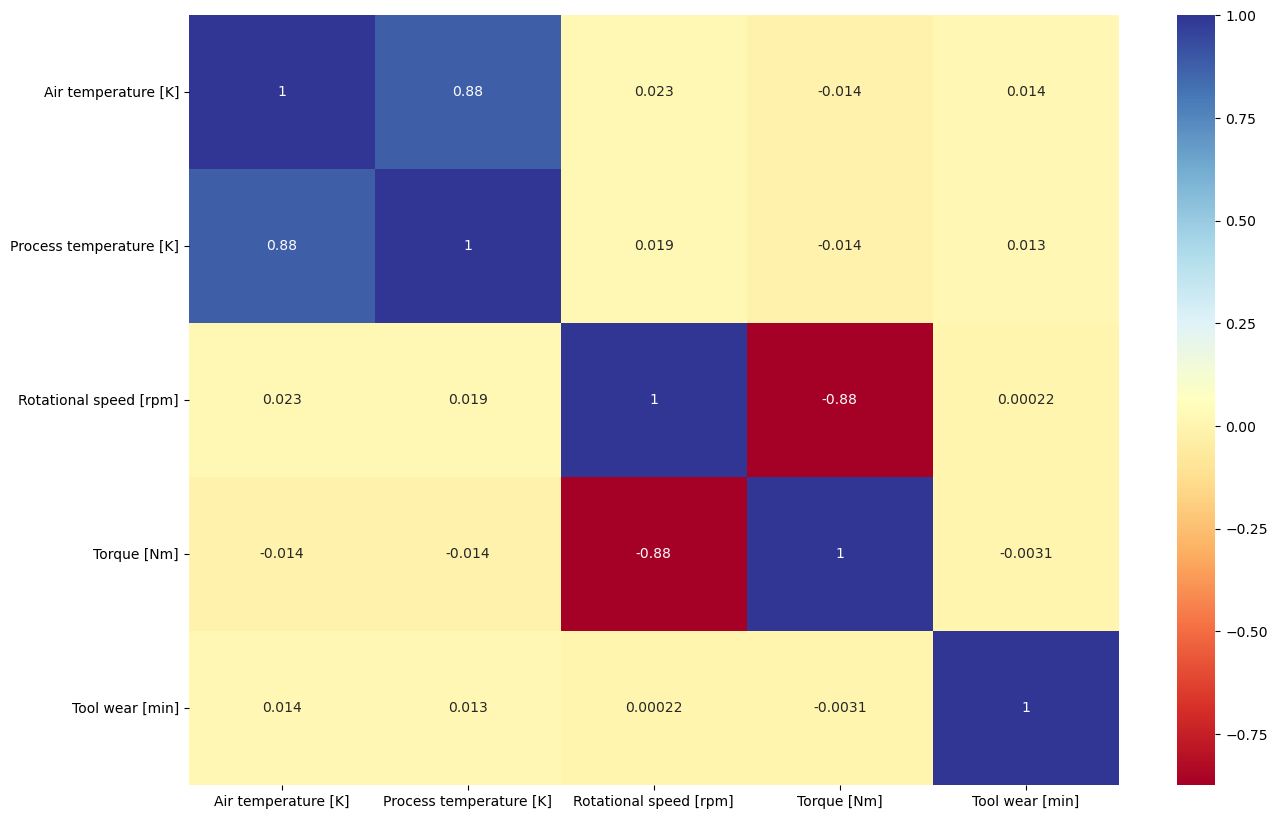

In [7]:
plt.figure(figsize=(15,10))
df_numeric = df.select_dtypes(include=[np.number])
sns.heatmap(df_numeric.corr(), annot=True, cmap="RdYlBu")
plt.show()

In [8]:
df.isnull().values.any()

False

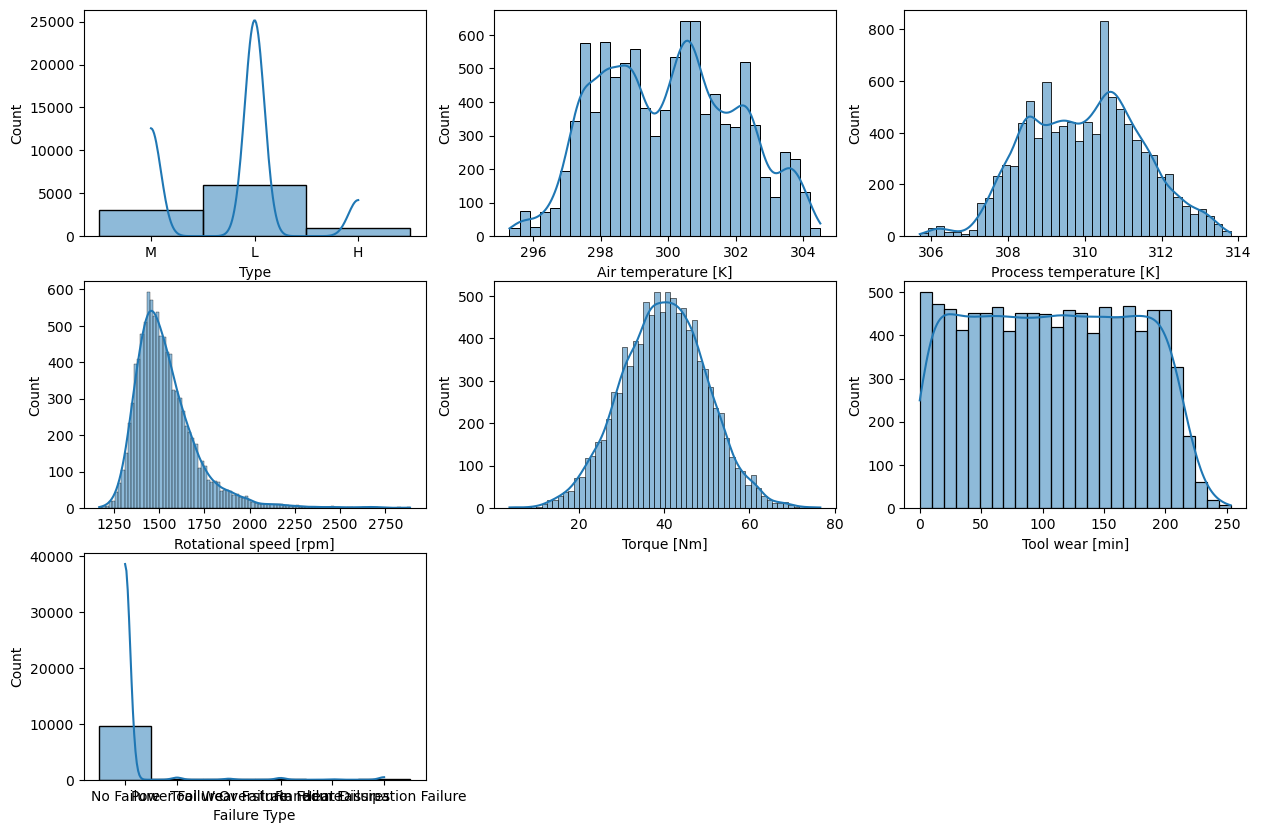

In [9]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(3,3,i)
    sns.histplot(df[col],kde=True)

array([[<Axes: title={'center': 'Air temperature [K]'}>,
        <Axes: title={'center': 'Process temperature [K]'}>],
       [<Axes: title={'center': 'Rotational speed [rpm]'}>,
        <Axes: title={'center': 'Torque [Nm]'}>],
       [<Axes: title={'center': 'Tool wear [min]'}>, <Axes: >]],
      dtype=object)

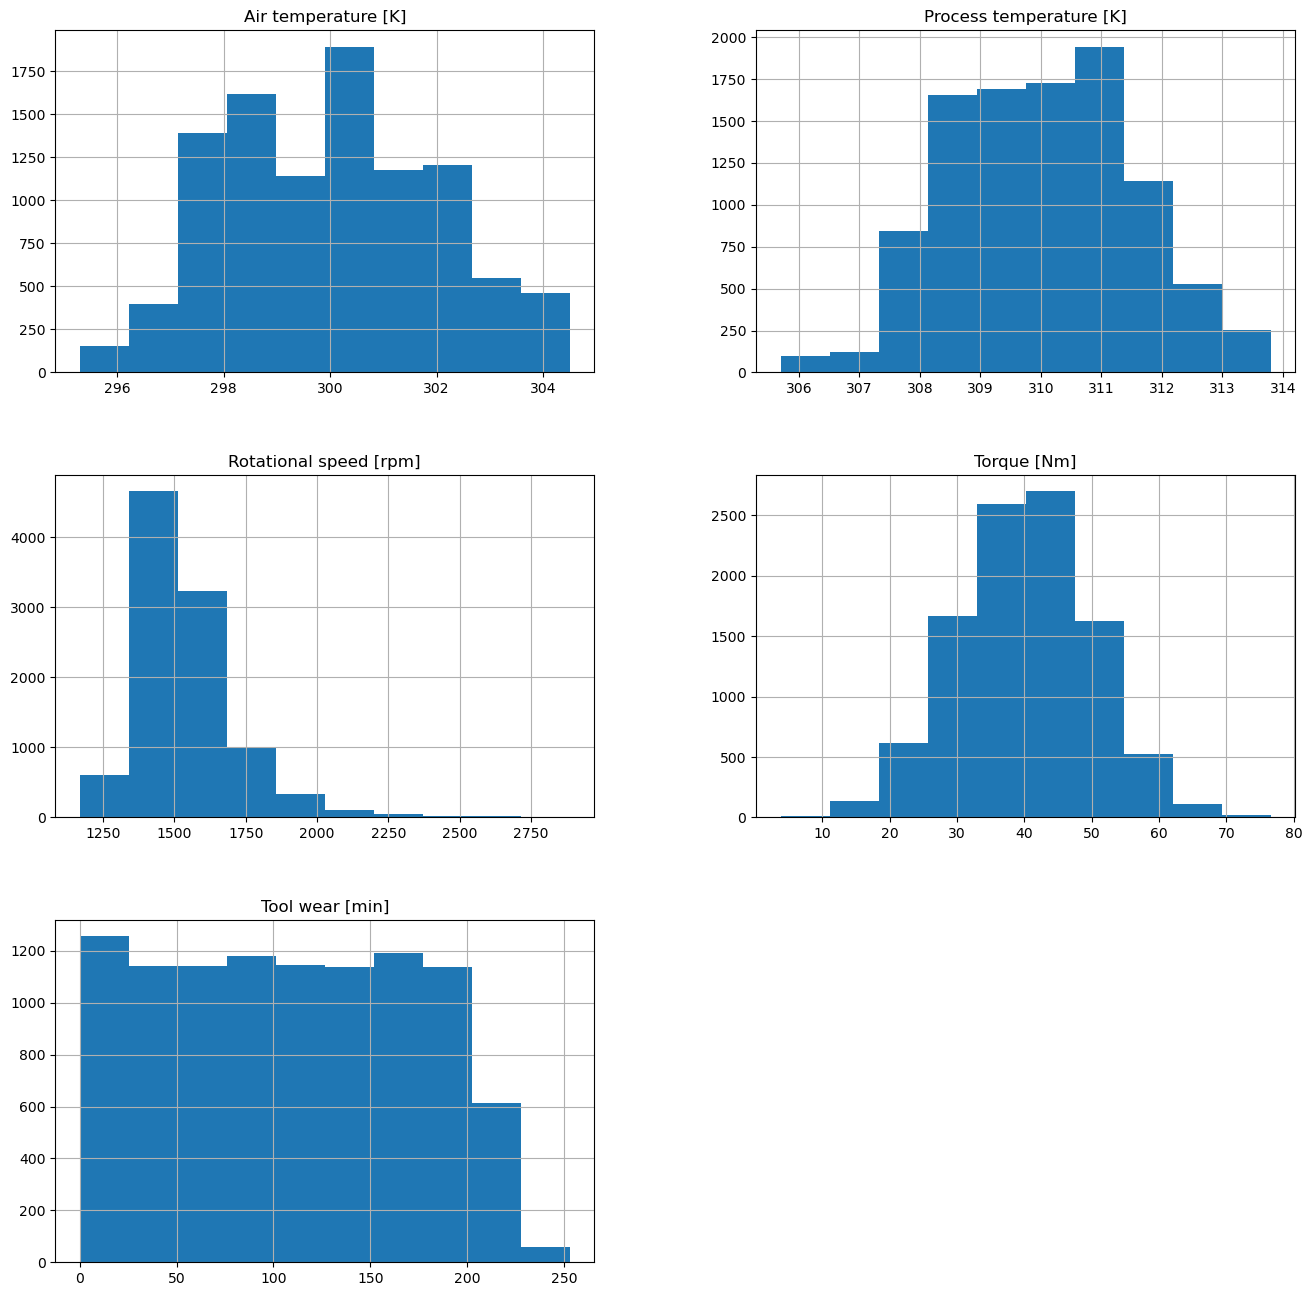

In [10]:
df.hist(figsize=(16, 16))

In [11]:
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


C:\Users\HP\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


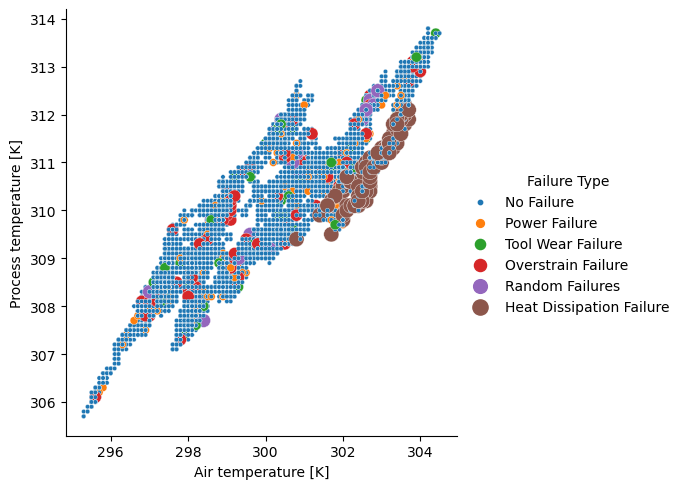

In [12]:
_ = sns.relplot(x="Air temperature [K]", y="Process temperature [K]", hue="Failure Type",size="Failure Type", sizes=(120, 10),data=df)

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


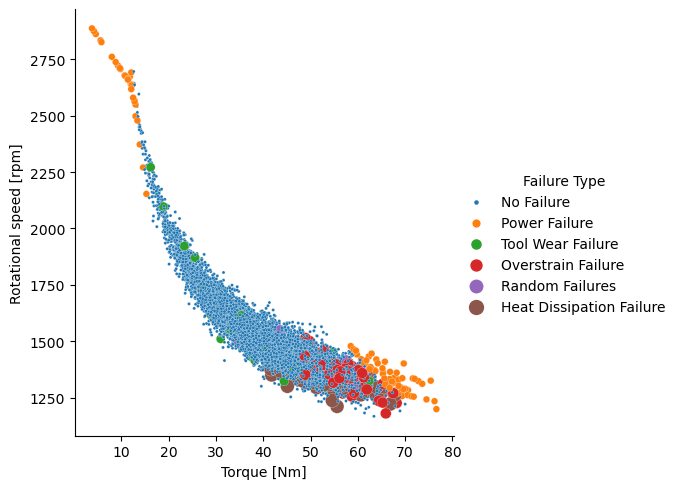

In [13]:
_ = sns.relplot(x="Torque [Nm]", y="Rotational speed [rpm]", hue="Failure Type",size="Failure Type", sizes=(100, 5),data=df)

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


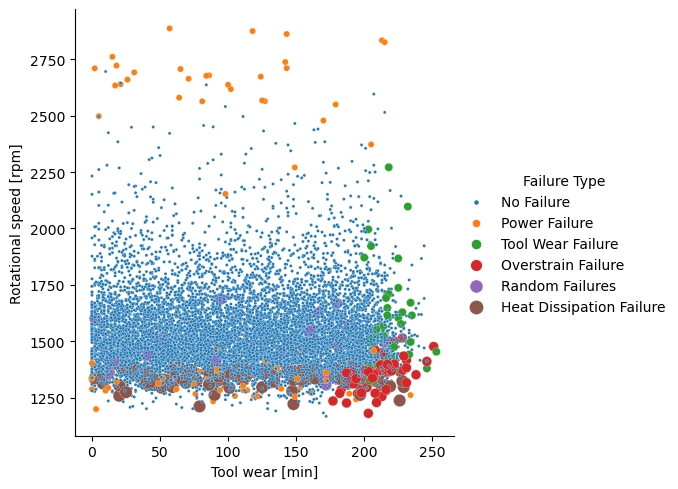

In [14]:
_ = sns.relplot(x="Tool wear [min]", 
                y="Rotational speed [rpm]", 
                hue="Failure Type",
                size="Failure Type", 
                sizes=(80, 5), 
                data=df)

In [15]:
df["Failure Type"].replace({"No Failure": 0,"Heat Dissipation Failure": 1,"Power Failure": 2,"Overstrain Failure": 3,"Tool Wear Failure": 4,"Random Failures": 5},inplace=True)

In [16]:
df["Type"].replace({"H":0,"L":1,"M":2}, inplace=True)

In [17]:
col_name=df.columns.to_list()

In [18]:
col_name

['Type',
 'Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Failure Type']

In [19]:
predictive_columns = col_name[0:6]
X = df[predictive_columns]
y = df["Failure Type"]

In [20]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=5, random_state=None)
for train_index,test_index in skf.split(X,y):
    x1_train,x1_test=X.iloc[train_index],X.iloc[test_index]
    y1_train,y1_test=y.iloc[train_index],y.iloc[test_index]
    train_0, train_1 = len(y1_train[y1_train==0]), len(y1_train[y1_train==1])
    test_0, test_1 = len(y1_test[y1_test==0]), len(y1_test[y1_test==1])
    print('train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

train: 0=7721, 1=90, Test: 0=1931, 1=22
train: 0=7721, 1=90, Test: 0=1931, 1=22
train: 0=7722, 1=90, Test: 0=1930, 1=22
train: 0=7722, 1=89, Test: 0=1930, 1=23
train: 0=7722, 1=89, Test: 0=1930, 1=23


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=40, test_size=0.33, stratify=y)

In [22]:
from imblearn.combine import SMOTETomek
smote = SMOTETomek(random_state=42)
X1_res, y1_res = smote.fit_resample(X_train,y_train)

In [23]:
X1_res.shape

(38748, 6)

In [24]:
X1_res

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,1,297.500000,308.700000,1371,46.500000,121
1,2,297.400000,308.600000,1452,41.200000,197
2,2,296.400000,307.300000,2077,19.100000,80
3,1,300.400000,309.300000,1413,50.300000,101
4,1,297.400000,308.100000,1348,57.400000,66
...,...,...,...,...,...,...
38743,1,302.567982,312.035964,1437,42.908492,201
38744,1,302.766184,312.183092,1507,36.246384,79
38745,1,299.733107,309.612309,1567,35.541596,183
38746,1,302.463023,311.872267,1308,59.649157,168


In [25]:
y1_res.shape

(38748,)

In [26]:
df_x = pd.DataFrame(X1_res)

In [27]:
df_x["Type"].replace({0:"H",1:"L",2:"M"}, inplace=True)

In [28]:
df_y = pd.DataFrame(y1_res)

In [29]:
df_y["Failure Type"].replace({0:"No Failure",1:"Heat Dissipation Failure",2:"Power Failure",3:"Overstrain Failure",4:"Tool Wear Failure",5:"Random Failures"},inplace=True)

In [30]:
df1 = pd.concat([df_x,df_y], axis=1)

In [31]:
df1['Failure Type'].value_counts()

Failure Type
Overstrain Failure          6467
Heat Dissipation Failure    6464
Power Failure               6462
Tool Wear Failure           6461
Random Failures             6454
No Failure                  6440
Name: count, dtype: int64

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


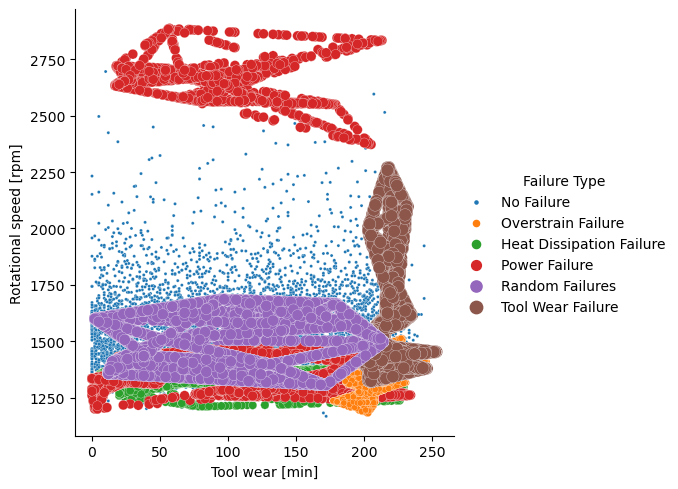

In [32]:
_ = sns.relplot(x="Tool wear [min]", 
                y="Rotational speed [rpm]", 
                hue="Failure Type",
                size="Failure Type", 
                sizes=(80, 5), 
                data=df1)

In [33]:
X_test.shape

(3300, 6)

In [34]:
y_test.shape

(3300,)

In [35]:
categorical_cols = X.select_dtypes(include="object").columns.to_list()
categorical_pipe = make_pipeline(OneHotEncoder(sparse_output=False, handle_unknown="ignore"))

to_log = ["Rotational speed [rpm]",	"Tool wear [min]"]
to_scale = ["Air temperature [K]","Process temperature [K]", "Torque [Nm]"]
numeric_pipe_1 = make_pipeline(PowerTransformer())
numeric_pipe_2 = make_pipeline(StandardScaler())

full = ColumnTransformer(
    transformers=[
        ("categorical", categorical_pipe, categorical_cols),
        ("power_transform", numeric_pipe_1, to_log),
        ("standardization", numeric_pipe_2, to_scale)])

### Random Forest Classifier 

In [36]:
rfc = OutputCodeClassifier(RandomForestClassifier(), code_size=6, random_state=40)

In [37]:
pipeline = Pipeline(
    steps=[("preprocess", full),("base",rfc)])

In [38]:
model_rfc = pipeline.fit(X1_res, y1_res)
y_pred_rfc = model_rfc.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3185
           1       0.73      0.86      0.79        37
           2       0.77      0.77      0.77        31
           3       0.67      0.69      0.68        26
           4       0.06      0.20      0.09        15
           5       0.04      0.17      0.07         6

    accuracy                           0.96      3300
   macro avg       0.54      0.61      0.56      3300
weighted avg       0.98      0.96      0.97      3300



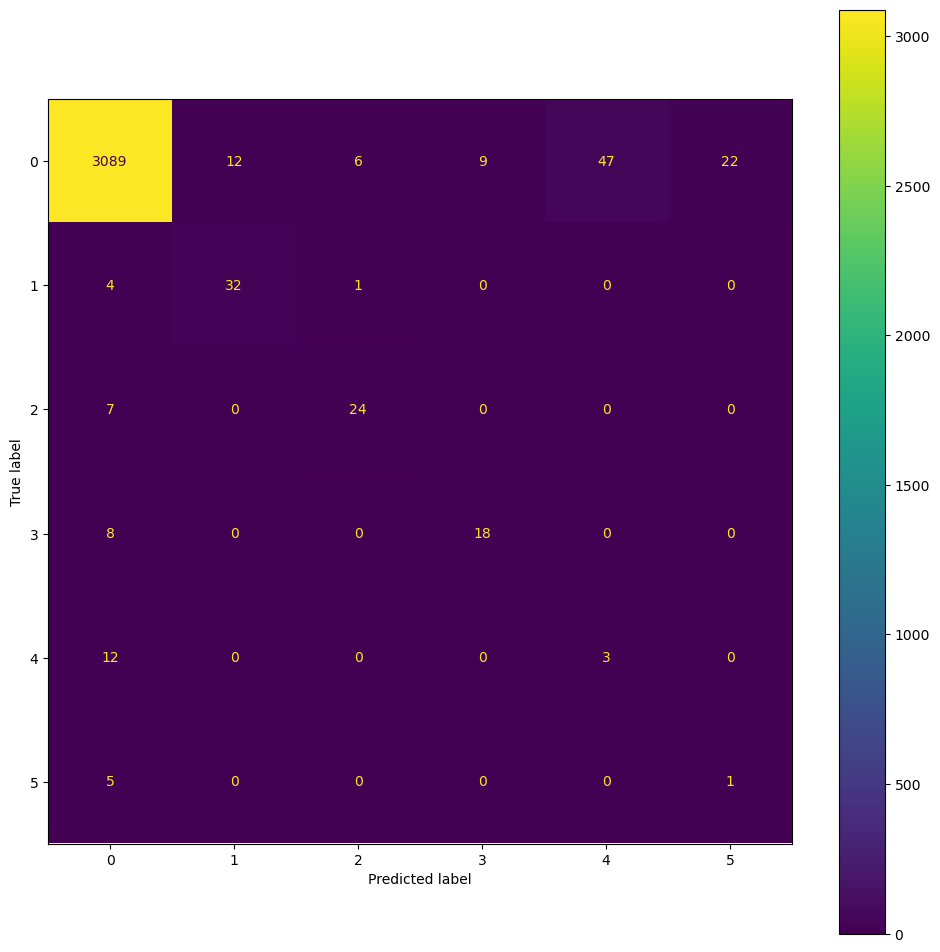

In [39]:
fig, ax = plt.subplots(figsize=(12, 12))
print(classification_report(y_test, y_pred_rfc))
cm = confusion_matrix(y_test, y_pred_rfc)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)
plt.show();

In [40]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3185
           1       0.73      0.86      0.79        37
           2       0.77      0.77      0.77        31
           3       0.67      0.69      0.68        26
           4       0.06      0.20      0.09        15
           5       0.04      0.17      0.07         6

    accuracy                           0.96      3300
   macro avg       0.54      0.61      0.56      3300
weighted avg       0.98      0.96      0.97      3300



In [41]:
rf_accuracy = accuracy_score(y_test, y_pred_rfc)
rf_mcc = matthews_corrcoef(y_test, y_pred_rfc)

print("Random Forest:")
print("Accuracy Score: %.4f" % rf_accuracy)
print("Matthews Correlation Coefficient: %.4f\n" % rf_mcc)

Random Forest:
Accuracy Score: 0.9597
Matthews Correlation Coefficient: 0.5420



### Light Gradient Boosted Machine

In [42]:
lgbm = OutputCodeClassifier(LGBMClassifier(), code_size=6, random_state=42)

In [43]:
pipeline_lgbm = Pipeline(
    steps=[
        ("preprocess", full),
        ("base",lgbm,),])

In [44]:
model_lgbm = pipeline_lgbm.fit(X1_res, y1_res)
y_pred_lgbm = model_lgbm.predict(X_test)

[LightGBM] [Info] Number of positive: 12902, number of negative: 25846
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 38748, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.332972 -> initscore=-0.694774
[LightGBM] [Info] Start training from score -0.694774
[LightGBM] [Info] Number of positive: 32281, number of negative: 6467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 38748, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.833101 -> initscore=1.607766
[Light

[LightGBM] [Info] Number of positive: 25846, number of negative: 12902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 38748, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.667028 -> initscore=0.694774
[LightGBM] [Info] Start training from score 0.694774
[LightGBM] [Info] Number of positive: 32308, number of negative: 6440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 38748, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.833798 -> initscore=1.612786
[LightGB

[LightGBM] [Info] Number of positive: 12902, number of negative: 25846
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 38748, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.332972 -> initscore=-0.694774
[LightGBM] [Info] Start training from score -0.694774


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\ut

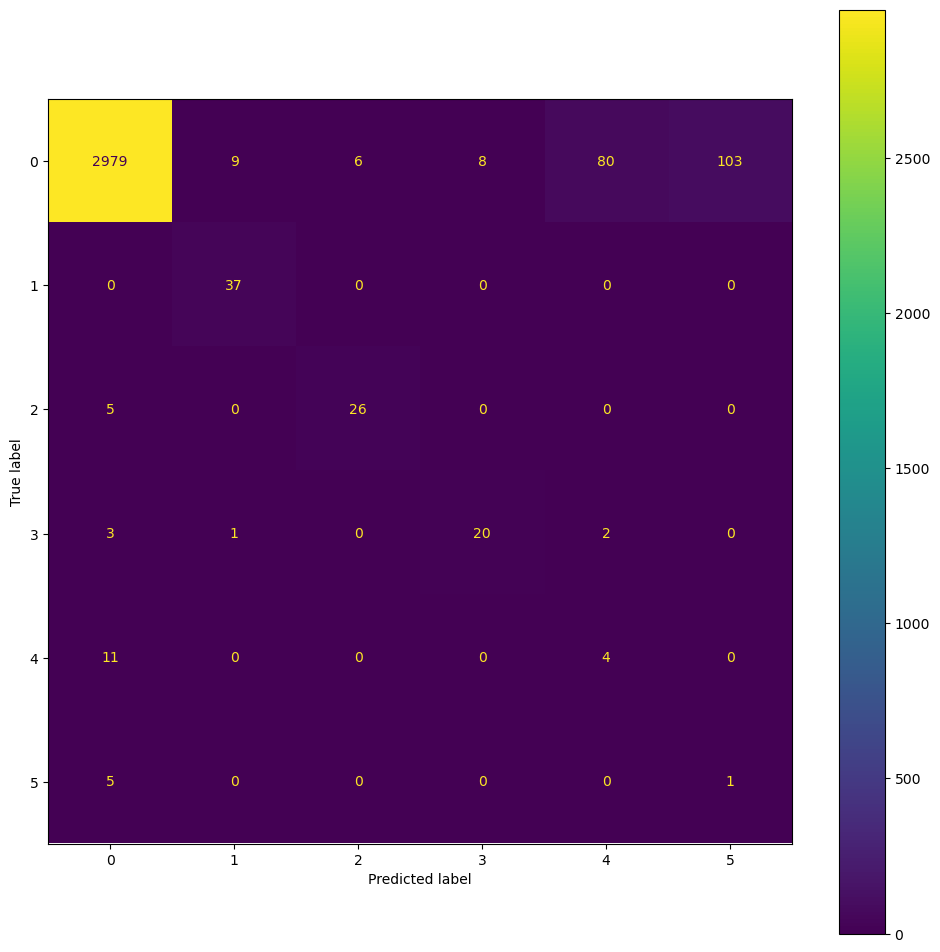

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      3185
           1       0.79      1.00      0.88        37
           2       0.81      0.84      0.83        31
           3       0.71      0.77      0.74        26
           4       0.05      0.27      0.08        15
           5       0.01      0.17      0.02         6

    accuracy                           0.93      3300
   macro avg       0.56      0.66      0.58      3300
weighted avg       0.98      0.93      0.95      3300



In [45]:
fig, ax = plt.subplots(figsize=(12, 12))
cm = confusion_matrix(y_test, y_pred_lgbm)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)
plt.show();
print(classification_report(y_test, y_pred_lgbm))

In [46]:
lgb_accuracy = accuracy_score(y_test, y_pred_lgbm)
lgb_mcc = matthews_corrcoef(y_test, y_pred_lgbm)
print("LightGBM:")
print("Accuracy Score: %.4f" % lgb_accuracy)
print("Matthews Correlation Coefficient: %.4f" % lgb_mcc)

LightGBM:
Accuracy Score: 0.9294
Matthews Correlation Coefficient: 0.4703


### XGBoost

In [47]:
# !pip install xgboost

# import xgboost
# print(xgboost.__version__)

In [48]:
from xgboost import XGBClassifier

In [49]:
xgb = OutputCodeClassifier(XGBClassifier(), code_size=6, random_state=42)

In [50]:
pipeline_xgb = Pipeline(
    steps=[("preprocess", full),("base",xgb)])

In [51]:
model_xgb = pipeline_xgb.fit(X1_res, y1_res)
y_pred_xgb = model_xgb.predict(X_test)

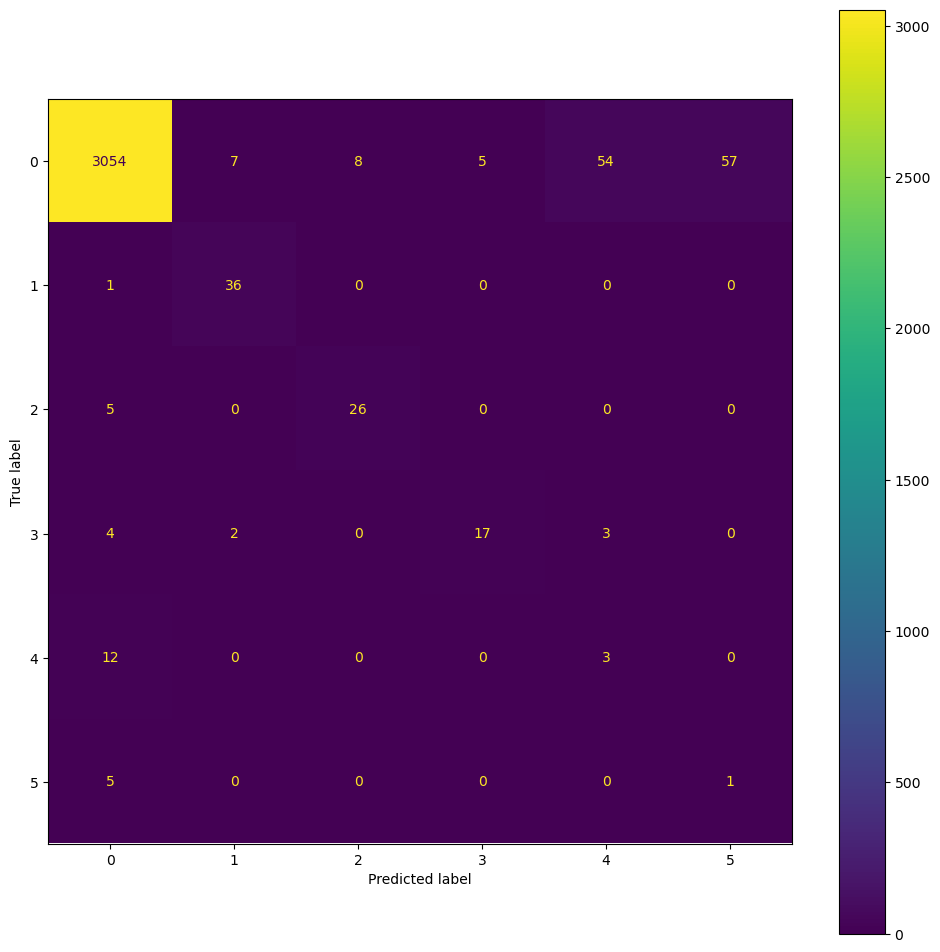

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3185
           1       0.80      0.97      0.88        37
           2       0.76      0.84      0.80        31
           3       0.77      0.65      0.71        26
           4       0.05      0.20      0.08        15
           5       0.02      0.17      0.03         6

    accuracy                           0.95      3300
   macro avg       0.57      0.63      0.58      3300
weighted avg       0.98      0.95      0.96      3300



In [52]:
fig, ax = plt.subplots(figsize=(12, 12))
cm = confusion_matrix(y_test, y_pred_xgb)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)
plt.show();
print(classification_report(y_test, y_pred_xgb))

In [53]:
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_mcc = matthews_corrcoef(y_test, y_pred_xgb)

print("XGBoost:")
print("Accuracy Score: %.4f" % xgb_accuracy)
print("Matthews Correlation Coefficient: %.4f\n" % xgb_mcc)

XGBoost:
Accuracy Score: 0.9506
Matthews Correlation Coefficient: 0.5268



### CatBoost

In [54]:
# !pip install catboost

In [55]:
from catboost import CatBoostClassifier, Pool, cv

In [56]:
catb = OutputCodeClassifier(CatBoostClassifier(random_seed=42,logging_level='Silent'), code_size=6, random_state=42)

In [57]:
pipeline_catb = Pipeline(steps=[("preprocess", full),("base",catb)])

In [58]:
model_catb = catb.fit(X1_res, y1_res)
y_pred_catb = model_catb.predict(X_test)

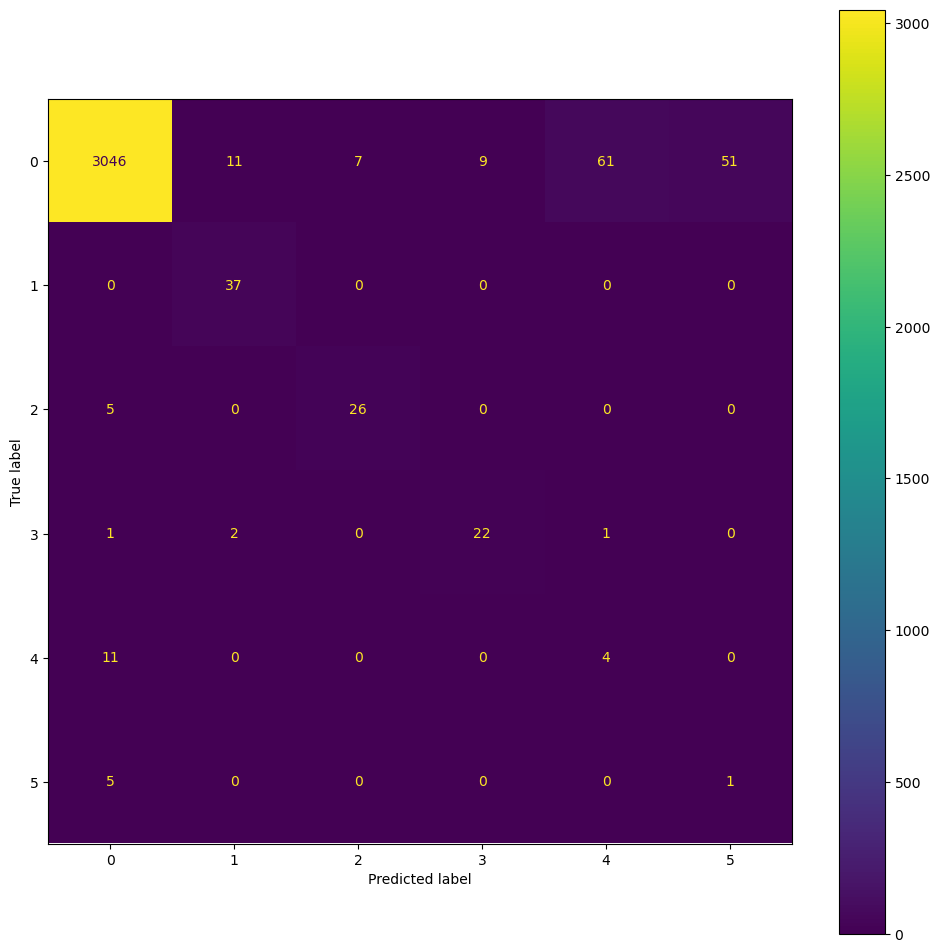

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3185
           1       0.74      1.00      0.85        37
           2       0.79      0.84      0.81        31
           3       0.71      0.85      0.77        26
           4       0.06      0.27      0.10        15
           5       0.02      0.17      0.03         6

    accuracy                           0.95      3300
   macro avg       0.55      0.68      0.59      3300
weighted avg       0.98      0.95      0.96      3300



In [59]:
fig, ax = plt.subplots(figsize=(12, 12))
cm = confusion_matrix(y_test, y_pred_catb)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)
plt.show();
print(classification_report(y_test, y_pred_catb))

In [60]:
print("Accuracy Score: %.4f" %(accuracy_score(y_test,y_pred_catb)))
print("Matthews correlation coefficient: %.4f" %(matthews_corrcoef(y_test,y_pred_catb)))

Accuracy Score: 0.9503
Matthews correlation coefficient: 0.5485


In [61]:
catb_ov = CatBoostClassifier()
ovr = OneVsRestClassifier(catb_ov)

In [62]:
ovr.fit(X1_res, y1_res)
yhat_ovr = ovr.predict(X_test)

Learning rate set to 0.049104
0:	learn: 0.6323075	total: 21.6ms	remaining: 21.6s
1:	learn: 0.5766394	total: 40.5ms	remaining: 20.2s
2:	learn: 0.5331696	total: 59ms	remaining: 19.6s
3:	learn: 0.4925902	total: 78.3ms	remaining: 19.5s
4:	learn: 0.4604442	total: 97ms	remaining: 19.3s
5:	learn: 0.4327774	total: 115ms	remaining: 19s
6:	learn: 0.4108182	total: 132ms	remaining: 18.8s
7:	learn: 0.3882560	total: 151ms	remaining: 18.7s
8:	learn: 0.3730292	total: 169ms	remaining: 18.6s
9:	learn: 0.3518721	total: 188ms	remaining: 18.6s
10:	learn: 0.3359159	total: 206ms	remaining: 18.5s
11:	learn: 0.3239283	total: 224ms	remaining: 18.5s
12:	learn: 0.3114504	total: 242ms	remaining: 18.4s
13:	learn: 0.3012472	total: 260ms	remaining: 18.3s
14:	learn: 0.2916470	total: 278ms	remaining: 18.3s
15:	learn: 0.2819417	total: 296ms	remaining: 18.2s
16:	learn: 0.2738199	total: 316ms	remaining: 18.2s
17:	learn: 0.2687344	total: 334ms	remaining: 18.2s
18:	learn: 0.2620494	total: 352ms	remaining: 18.2s
19:	learn: 0

161:	learn: 0.1027994	total: 2.98s	remaining: 15.4s
162:	learn: 0.1023893	total: 3s	remaining: 15.4s
163:	learn: 0.1022298	total: 3.02s	remaining: 15.4s
164:	learn: 0.1020560	total: 3.03s	remaining: 15.4s
165:	learn: 0.1017999	total: 3.05s	remaining: 15.3s
166:	learn: 0.1011820	total: 3.07s	remaining: 15.3s
167:	learn: 0.1009617	total: 3.08s	remaining: 15.3s
168:	learn: 0.1007665	total: 3.1s	remaining: 15.2s
169:	learn: 0.1002179	total: 3.12s	remaining: 15.2s
170:	learn: 0.0996092	total: 3.13s	remaining: 15.2s
171:	learn: 0.0992701	total: 3.15s	remaining: 15.2s
172:	learn: 0.0990320	total: 3.17s	remaining: 15.2s
173:	learn: 0.0987732	total: 3.19s	remaining: 15.1s
174:	learn: 0.0982779	total: 3.21s	remaining: 15.1s
175:	learn: 0.0980222	total: 3.23s	remaining: 15.1s
176:	learn: 0.0977885	total: 3.24s	remaining: 15.1s
177:	learn: 0.0974202	total: 3.26s	remaining: 15.1s
178:	learn: 0.0970832	total: 3.28s	remaining: 15s
179:	learn: 0.0967828	total: 3.3s	remaining: 15s
180:	learn: 0.0966443

323:	learn: 0.0641919	total: 5.91s	remaining: 12.3s
324:	learn: 0.0640448	total: 5.93s	remaining: 12.3s
325:	learn: 0.0639799	total: 5.95s	remaining: 12.3s
326:	learn: 0.0638357	total: 5.96s	remaining: 12.3s
327:	learn: 0.0635627	total: 5.98s	remaining: 12.3s
328:	learn: 0.0633165	total: 6s	remaining: 12.2s
329:	learn: 0.0631740	total: 6.02s	remaining: 12.2s
330:	learn: 0.0630133	total: 6.04s	remaining: 12.2s
331:	learn: 0.0628151	total: 6.05s	remaining: 12.2s
332:	learn: 0.0626460	total: 6.07s	remaining: 12.2s
333:	learn: 0.0625131	total: 6.09s	remaining: 12.1s
334:	learn: 0.0623898	total: 6.11s	remaining: 12.1s
335:	learn: 0.0621981	total: 6.13s	remaining: 12.1s
336:	learn: 0.0619459	total: 6.14s	remaining: 12.1s
337:	learn: 0.0617814	total: 6.16s	remaining: 12.1s
338:	learn: 0.0615618	total: 6.18s	remaining: 12s
339:	learn: 0.0613542	total: 6.2s	remaining: 12s
340:	learn: 0.0611641	total: 6.22s	remaining: 12s
341:	learn: 0.0609849	total: 6.24s	remaining: 12s
342:	learn: 0.0607835	to

482:	learn: 0.0433743	total: 8.75s	remaining: 9.37s
483:	learn: 0.0433073	total: 8.77s	remaining: 9.35s
484:	learn: 0.0432219	total: 8.79s	remaining: 9.33s
485:	learn: 0.0431364	total: 8.81s	remaining: 9.31s
486:	learn: 0.0430114	total: 8.82s	remaining: 9.3s
487:	learn: 0.0429256	total: 8.84s	remaining: 9.28s
488:	learn: 0.0428058	total: 8.86s	remaining: 9.26s
489:	learn: 0.0426993	total: 8.88s	remaining: 9.24s
490:	learn: 0.0426161	total: 8.9s	remaining: 9.22s
491:	learn: 0.0425211	total: 8.91s	remaining: 9.2s
492:	learn: 0.0423747	total: 8.93s	remaining: 9.19s
493:	learn: 0.0423270	total: 8.95s	remaining: 9.17s
494:	learn: 0.0422174	total: 8.97s	remaining: 9.15s
495:	learn: 0.0421141	total: 8.98s	remaining: 9.13s
496:	learn: 0.0419325	total: 9s	remaining: 9.11s
497:	learn: 0.0418646	total: 9.02s	remaining: 9.09s
498:	learn: 0.0418096	total: 9.04s	remaining: 9.08s
499:	learn: 0.0417351	total: 9.06s	remaining: 9.06s
500:	learn: 0.0416596	total: 9.07s	remaining: 9.04s
501:	learn: 0.0415

646:	learn: 0.0317946	total: 11.7s	remaining: 6.38s
647:	learn: 0.0317453	total: 11.7s	remaining: 6.36s
648:	learn: 0.0317272	total: 11.7s	remaining: 6.34s
649:	learn: 0.0316919	total: 11.7s	remaining: 6.32s
650:	learn: 0.0316092	total: 11.8s	remaining: 6.3s
651:	learn: 0.0315645	total: 11.8s	remaining: 6.28s
652:	learn: 0.0315309	total: 11.8s	remaining: 6.27s
653:	learn: 0.0314922	total: 11.8s	remaining: 6.25s
654:	learn: 0.0314593	total: 11.8s	remaining: 6.23s
655:	learn: 0.0313876	total: 11.8s	remaining: 6.21s
656:	learn: 0.0313599	total: 11.9s	remaining: 6.19s
657:	learn: 0.0313102	total: 11.9s	remaining: 6.17s
658:	learn: 0.0312426	total: 11.9s	remaining: 6.16s
659:	learn: 0.0311500	total: 11.9s	remaining: 6.14s
660:	learn: 0.0311218	total: 11.9s	remaining: 6.12s
661:	learn: 0.0310725	total: 12s	remaining: 6.1s
662:	learn: 0.0309806	total: 12s	remaining: 6.08s
663:	learn: 0.0309509	total: 12s	remaining: 6.07s
664:	learn: 0.0309144	total: 12s	remaining: 6.05s
665:	learn: 0.0308559	

813:	learn: 0.0242990	total: 14.7s	remaining: 3.35s
814:	learn: 0.0242439	total: 14.7s	remaining: 3.33s
815:	learn: 0.0242089	total: 14.7s	remaining: 3.31s
816:	learn: 0.0241435	total: 14.7s	remaining: 3.29s
817:	learn: 0.0240867	total: 14.7s	remaining: 3.27s
818:	learn: 0.0240260	total: 14.7s	remaining: 3.26s
819:	learn: 0.0239531	total: 14.8s	remaining: 3.24s
820:	learn: 0.0239255	total: 14.8s	remaining: 3.22s
821:	learn: 0.0238743	total: 14.8s	remaining: 3.2s
822:	learn: 0.0238509	total: 14.8s	remaining: 3.19s
823:	learn: 0.0238325	total: 14.8s	remaining: 3.17s
824:	learn: 0.0237818	total: 14.8s	remaining: 3.15s
825:	learn: 0.0237663	total: 14.9s	remaining: 3.13s
826:	learn: 0.0237435	total: 14.9s	remaining: 3.11s
827:	learn: 0.0237316	total: 14.9s	remaining: 3.1s
828:	learn: 0.0236730	total: 14.9s	remaining: 3.08s
829:	learn: 0.0236302	total: 14.9s	remaining: 3.06s
830:	learn: 0.0235967	total: 15s	remaining: 3.04s
831:	learn: 0.0235366	total: 15s	remaining: 3.02s
832:	learn: 0.0234

978:	learn: 0.0191681	total: 17.6s	remaining: 378ms
979:	learn: 0.0191190	total: 17.7s	remaining: 360ms
980:	learn: 0.0191092	total: 17.7s	remaining: 342ms
981:	learn: 0.0190682	total: 17.7s	remaining: 324ms
982:	learn: 0.0190449	total: 17.7s	remaining: 306ms
983:	learn: 0.0190138	total: 17.7s	remaining: 288ms
984:	learn: 0.0189770	total: 17.7s	remaining: 270ms
985:	learn: 0.0189415	total: 17.8s	remaining: 252ms
986:	learn: 0.0189066	total: 17.8s	remaining: 234ms
987:	learn: 0.0188893	total: 17.8s	remaining: 216ms
988:	learn: 0.0188616	total: 17.8s	remaining: 198ms
989:	learn: 0.0188405	total: 17.8s	remaining: 180ms
990:	learn: 0.0188054	total: 17.9s	remaining: 162ms
991:	learn: 0.0187721	total: 17.9s	remaining: 144ms
992:	learn: 0.0187657	total: 17.9s	remaining: 126ms
993:	learn: 0.0187371	total: 17.9s	remaining: 108ms
994:	learn: 0.0187162	total: 17.9s	remaining: 90.1ms
995:	learn: 0.0187022	total: 17.9s	remaining: 72.1ms
996:	learn: 0.0186960	total: 18s	remaining: 54.1ms
997:	learn:

139:	learn: 0.0021124	total: 2.53s	remaining: 15.6s
140:	learn: 0.0020666	total: 2.55s	remaining: 15.5s
141:	learn: 0.0020516	total: 2.57s	remaining: 15.5s
142:	learn: 0.0020100	total: 2.59s	remaining: 15.5s
143:	learn: 0.0019799	total: 2.6s	remaining: 15.5s
144:	learn: 0.0019691	total: 2.62s	remaining: 15.5s
145:	learn: 0.0019213	total: 2.64s	remaining: 15.4s
146:	learn: 0.0018909	total: 2.66s	remaining: 15.4s
147:	learn: 0.0018496	total: 2.68s	remaining: 15.4s
148:	learn: 0.0018218	total: 2.69s	remaining: 15.4s
149:	learn: 0.0018015	total: 2.71s	remaining: 15.4s
150:	learn: 0.0017867	total: 2.73s	remaining: 15.4s
151:	learn: 0.0017570	total: 2.75s	remaining: 15.3s
152:	learn: 0.0017312	total: 2.77s	remaining: 15.3s
153:	learn: 0.0017063	total: 2.79s	remaining: 15.3s
154:	learn: 0.0016913	total: 2.8s	remaining: 15.3s
155:	learn: 0.0016568	total: 2.82s	remaining: 15.3s
156:	learn: 0.0016418	total: 2.84s	remaining: 15.3s
157:	learn: 0.0016335	total: 2.86s	remaining: 15.2s
158:	learn: 0.

310:	learn: 0.0006396	total: 5.48s	remaining: 12.1s
311:	learn: 0.0006396	total: 5.5s	remaining: 12.1s
312:	learn: 0.0006396	total: 5.51s	remaining: 12.1s
313:	learn: 0.0006396	total: 5.53s	remaining: 12.1s
314:	learn: 0.0006396	total: 5.54s	remaining: 12.1s
315:	learn: 0.0006396	total: 5.56s	remaining: 12s
316:	learn: 0.0006396	total: 5.57s	remaining: 12s
317:	learn: 0.0006396	total: 5.59s	remaining: 12s
318:	learn: 0.0006396	total: 5.6s	remaining: 12s
319:	learn: 0.0006396	total: 5.62s	remaining: 11.9s
320:	learn: 0.0006396	total: 5.63s	remaining: 11.9s
321:	learn: 0.0006396	total: 5.65s	remaining: 11.9s
322:	learn: 0.0006396	total: 5.66s	remaining: 11.9s
323:	learn: 0.0006396	total: 5.67s	remaining: 11.8s
324:	learn: 0.0006396	total: 5.69s	remaining: 11.8s
325:	learn: 0.0006396	total: 5.7s	remaining: 11.8s
326:	learn: 0.0006396	total: 5.71s	remaining: 11.8s
327:	learn: 0.0006396	total: 5.73s	remaining: 11.7s
328:	learn: 0.0006396	total: 5.74s	remaining: 11.7s
329:	learn: 0.0006396	t

473:	learn: 0.0006395	total: 7.96s	remaining: 8.84s
474:	learn: 0.0006395	total: 7.98s	remaining: 8.82s
475:	learn: 0.0006395	total: 7.99s	remaining: 8.8s
476:	learn: 0.0006395	total: 8.01s	remaining: 8.78s
477:	learn: 0.0006395	total: 8.03s	remaining: 8.76s
478:	learn: 0.0006395	total: 8.04s	remaining: 8.75s
479:	learn: 0.0006395	total: 8.06s	remaining: 8.73s
480:	learn: 0.0006395	total: 8.07s	remaining: 8.71s
481:	learn: 0.0006394	total: 8.09s	remaining: 8.69s
482:	learn: 0.0006394	total: 8.1s	remaining: 8.67s
483:	learn: 0.0006394	total: 8.12s	remaining: 8.65s
484:	learn: 0.0006394	total: 8.13s	remaining: 8.64s
485:	learn: 0.0006394	total: 8.15s	remaining: 8.62s
486:	learn: 0.0006394	total: 8.16s	remaining: 8.6s
487:	learn: 0.0006394	total: 8.18s	remaining: 8.58s
488:	learn: 0.0006394	total: 8.2s	remaining: 8.56s
489:	learn: 0.0006394	total: 8.21s	remaining: 8.55s
490:	learn: 0.0006394	total: 8.23s	remaining: 8.53s
491:	learn: 0.0006394	total: 8.24s	remaining: 8.51s
492:	learn: 0.00

633:	learn: 0.0006394	total: 10.3s	remaining: 5.92s
634:	learn: 0.0006394	total: 10.3s	remaining: 5.9s
635:	learn: 0.0006394	total: 10.3s	remaining: 5.89s
636:	learn: 0.0006394	total: 10.3s	remaining: 5.87s
637:	learn: 0.0006394	total: 10.3s	remaining: 5.85s
638:	learn: 0.0006394	total: 10.3s	remaining: 5.83s
639:	learn: 0.0006394	total: 10.3s	remaining: 5.82s
640:	learn: 0.0006394	total: 10.4s	remaining: 5.8s
641:	learn: 0.0006394	total: 10.4s	remaining: 5.79s
642:	learn: 0.0006394	total: 10.4s	remaining: 5.77s
643:	learn: 0.0006394	total: 10.4s	remaining: 5.75s
644:	learn: 0.0006394	total: 10.4s	remaining: 5.73s
645:	learn: 0.0006394	total: 10.4s	remaining: 5.72s
646:	learn: 0.0006394	total: 10.4s	remaining: 5.7s
647:	learn: 0.0006394	total: 10.5s	remaining: 5.68s
648:	learn: 0.0006394	total: 10.5s	remaining: 5.66s
649:	learn: 0.0006394	total: 10.5s	remaining: 5.65s
650:	learn: 0.0006394	total: 10.5s	remaining: 5.63s
651:	learn: 0.0006394	total: 10.5s	remaining: 5.61s
652:	learn: 0.0

798:	learn: 0.0006394	total: 12.6s	remaining: 3.16s
799:	learn: 0.0006394	total: 12.6s	remaining: 3.14s
800:	learn: 0.0006394	total: 12.6s	remaining: 3.13s
801:	learn: 0.0006394	total: 12.6s	remaining: 3.11s
802:	learn: 0.0006394	total: 12.6s	remaining: 3.1s
803:	learn: 0.0006394	total: 12.6s	remaining: 3.08s
804:	learn: 0.0006394	total: 12.6s	remaining: 3.06s
805:	learn: 0.0006394	total: 12.7s	remaining: 3.05s
806:	learn: 0.0006394	total: 12.7s	remaining: 3.03s
807:	learn: 0.0006394	total: 12.7s	remaining: 3.01s
808:	learn: 0.0006394	total: 12.7s	remaining: 3s
809:	learn: 0.0006394	total: 12.7s	remaining: 2.98s
810:	learn: 0.0006394	total: 12.7s	remaining: 2.97s
811:	learn: 0.0006394	total: 12.7s	remaining: 2.95s
812:	learn: 0.0006394	total: 12.8s	remaining: 2.93s
813:	learn: 0.0006394	total: 12.8s	remaining: 2.92s
814:	learn: 0.0006394	total: 12.8s	remaining: 2.9s
815:	learn: 0.0006394	total: 12.8s	remaining: 2.89s
816:	learn: 0.0006394	total: 12.8s	remaining: 2.87s
817:	learn: 0.000

963:	learn: 0.0006394	total: 14.9s	remaining: 556ms
964:	learn: 0.0006394	total: 14.9s	remaining: 540ms
965:	learn: 0.0006394	total: 14.9s	remaining: 525ms
966:	learn: 0.0006394	total: 14.9s	remaining: 509ms
967:	learn: 0.0006394	total: 14.9s	remaining: 494ms
968:	learn: 0.0006394	total: 15s	remaining: 478ms
969:	learn: 0.0006394	total: 15s	remaining: 463ms
970:	learn: 0.0006394	total: 15s	remaining: 448ms
971:	learn: 0.0006394	total: 15s	remaining: 432ms
972:	learn: 0.0006394	total: 15s	remaining: 417ms
973:	learn: 0.0006394	total: 15s	remaining: 401ms
974:	learn: 0.0006394	total: 15s	remaining: 386ms
975:	learn: 0.0006394	total: 15.1s	remaining: 370ms
976:	learn: 0.0006394	total: 15.1s	remaining: 355ms
977:	learn: 0.0006394	total: 15.1s	remaining: 339ms
978:	learn: 0.0006394	total: 15.1s	remaining: 324ms
979:	learn: 0.0006394	total: 15.1s	remaining: 308ms
980:	learn: 0.0006394	total: 15.1s	remaining: 293ms
981:	learn: 0.0006394	total: 15.1s	remaining: 277ms
982:	learn: 0.0006394	tota

134:	learn: 0.0017835	total: 2.17s	remaining: 13.9s
135:	learn: 0.0017675	total: 2.19s	remaining: 13.9s
136:	learn: 0.0017421	total: 2.21s	remaining: 13.9s
137:	learn: 0.0017349	total: 2.22s	remaining: 13.9s
138:	learn: 0.0017271	total: 2.24s	remaining: 13.9s
139:	learn: 0.0016935	total: 2.25s	remaining: 13.9s
140:	learn: 0.0016746	total: 2.27s	remaining: 13.8s
141:	learn: 0.0016554	total: 2.29s	remaining: 13.8s
142:	learn: 0.0016511	total: 2.3s	remaining: 13.8s
143:	learn: 0.0016340	total: 2.32s	remaining: 13.8s
144:	learn: 0.0016234	total: 2.34s	remaining: 13.8s
145:	learn: 0.0016069	total: 2.35s	remaining: 13.8s
146:	learn: 0.0015728	total: 2.37s	remaining: 13.7s
147:	learn: 0.0015676	total: 2.38s	remaining: 13.7s
148:	learn: 0.0015513	total: 2.4s	remaining: 13.7s
149:	learn: 0.0015273	total: 2.41s	remaining: 13.7s
150:	learn: 0.0014931	total: 2.43s	remaining: 13.6s
151:	learn: 0.0014830	total: 2.44s	remaining: 13.6s
152:	learn: 0.0014577	total: 2.46s	remaining: 13.6s
153:	learn: 0.

294:	learn: 0.0005849	total: 4.73s	remaining: 11.3s
295:	learn: 0.0005849	total: 4.74s	remaining: 11.3s
296:	learn: 0.0005849	total: 4.76s	remaining: 11.3s
297:	learn: 0.0005849	total: 4.77s	remaining: 11.2s
298:	learn: 0.0005849	total: 4.79s	remaining: 11.2s
299:	learn: 0.0005849	total: 4.8s	remaining: 11.2s
300:	learn: 0.0005849	total: 4.81s	remaining: 11.2s
301:	learn: 0.0005849	total: 4.83s	remaining: 11.2s
302:	learn: 0.0005849	total: 4.84s	remaining: 11.1s
303:	learn: 0.0005849	total: 4.86s	remaining: 11.1s
304:	learn: 0.0005849	total: 4.87s	remaining: 11.1s
305:	learn: 0.0005849	total: 4.89s	remaining: 11.1s
306:	learn: 0.0005849	total: 4.9s	remaining: 11.1s
307:	learn: 0.0005849	total: 4.92s	remaining: 11s
308:	learn: 0.0005849	total: 4.93s	remaining: 11s
309:	learn: 0.0005849	total: 4.94s	remaining: 11s
310:	learn: 0.0005849	total: 4.96s	remaining: 11s
311:	learn: 0.0005849	total: 4.97s	remaining: 11s
312:	learn: 0.0005849	total: 4.99s	remaining: 10.9s
313:	learn: 0.0005849	to

455:	learn: 0.0005849	total: 7.04s	remaining: 8.4s
456:	learn: 0.0005849	total: 7.05s	remaining: 8.38s
457:	learn: 0.0005849	total: 7.07s	remaining: 8.37s
458:	learn: 0.0005849	total: 7.08s	remaining: 8.35s
459:	learn: 0.0005849	total: 7.1s	remaining: 8.33s
460:	learn: 0.0005849	total: 7.11s	remaining: 8.31s
461:	learn: 0.0005849	total: 7.13s	remaining: 8.3s
462:	learn: 0.0005849	total: 7.14s	remaining: 8.28s
463:	learn: 0.0005849	total: 7.15s	remaining: 8.26s
464:	learn: 0.0005849	total: 7.17s	remaining: 8.25s
465:	learn: 0.0005849	total: 7.18s	remaining: 8.23s
466:	learn: 0.0005849	total: 7.2s	remaining: 8.21s
467:	learn: 0.0005849	total: 7.21s	remaining: 8.2s
468:	learn: 0.0005849	total: 7.23s	remaining: 8.18s
469:	learn: 0.0005849	total: 7.24s	remaining: 8.17s
470:	learn: 0.0005849	total: 7.25s	remaining: 8.15s
471:	learn: 0.0005849	total: 7.27s	remaining: 8.13s
472:	learn: 0.0005849	total: 7.28s	remaining: 8.12s
473:	learn: 0.0005849	total: 7.3s	remaining: 8.1s
474:	learn: 0.00058

619:	learn: 0.0005849	total: 9.39s	remaining: 5.75s
620:	learn: 0.0005849	total: 9.4s	remaining: 5.74s
621:	learn: 0.0005849	total: 9.41s	remaining: 5.72s
622:	learn: 0.0005849	total: 9.43s	remaining: 5.7s
623:	learn: 0.0005849	total: 9.44s	remaining: 5.69s
624:	learn: 0.0005849	total: 9.46s	remaining: 5.67s
625:	learn: 0.0005849	total: 9.47s	remaining: 5.66s
626:	learn: 0.0005849	total: 9.49s	remaining: 5.64s
627:	learn: 0.0005849	total: 9.5s	remaining: 5.63s
628:	learn: 0.0005849	total: 9.52s	remaining: 5.61s
629:	learn: 0.0005849	total: 9.53s	remaining: 5.6s
630:	learn: 0.0005849	total: 9.55s	remaining: 5.58s
631:	learn: 0.0005849	total: 9.56s	remaining: 5.57s
632:	learn: 0.0005849	total: 9.57s	remaining: 5.55s
633:	learn: 0.0005849	total: 9.59s	remaining: 5.54s
634:	learn: 0.0005849	total: 9.6s	remaining: 5.52s
635:	learn: 0.0005849	total: 9.62s	remaining: 5.5s
636:	learn: 0.0005849	total: 9.63s	remaining: 5.49s
637:	learn: 0.0005849	total: 9.64s	remaining: 5.47s
638:	learn: 0.0005

781:	learn: 0.0005849	total: 11.7s	remaining: 3.27s
782:	learn: 0.0005849	total: 11.8s	remaining: 3.26s
783:	learn: 0.0005849	total: 11.8s	remaining: 3.24s
784:	learn: 0.0005849	total: 11.8s	remaining: 3.23s
785:	learn: 0.0005849	total: 11.8s	remaining: 3.21s
786:	learn: 0.0005849	total: 11.8s	remaining: 3.2s
787:	learn: 0.0005849	total: 11.8s	remaining: 3.18s
788:	learn: 0.0005849	total: 11.8s	remaining: 3.17s
789:	learn: 0.0005849	total: 11.9s	remaining: 3.15s
790:	learn: 0.0005849	total: 11.9s	remaining: 3.13s
791:	learn: 0.0005849	total: 11.9s	remaining: 3.12s
792:	learn: 0.0005849	total: 11.9s	remaining: 3.1s
793:	learn: 0.0005849	total: 11.9s	remaining: 3.09s
794:	learn: 0.0005849	total: 11.9s	remaining: 3.08s
795:	learn: 0.0005849	total: 11.9s	remaining: 3.06s
796:	learn: 0.0005849	total: 12s	remaining: 3.04s
797:	learn: 0.0005849	total: 12s	remaining: 3.03s
798:	learn: 0.0005849	total: 12s	remaining: 3.01s
799:	learn: 0.0005849	total: 12s	remaining: 3s
800:	learn: 0.0005849	tot

944:	learn: 0.0005849	total: 14s	remaining: 817ms
945:	learn: 0.0005849	total: 14.1s	remaining: 802ms
946:	learn: 0.0005849	total: 14.1s	remaining: 788ms
947:	learn: 0.0005849	total: 14.1s	remaining: 773ms
948:	learn: 0.0005849	total: 14.1s	remaining: 758ms
949:	learn: 0.0005849	total: 14.1s	remaining: 743ms
950:	learn: 0.0005849	total: 14.1s	remaining: 728ms
951:	learn: 0.0005849	total: 14.1s	remaining: 713ms
952:	learn: 0.0005849	total: 14.2s	remaining: 698ms
953:	learn: 0.0005849	total: 14.2s	remaining: 683ms
954:	learn: 0.0005849	total: 14.2s	remaining: 668ms
955:	learn: 0.0005849	total: 14.2s	remaining: 653ms
956:	learn: 0.0005849	total: 14.2s	remaining: 639ms
957:	learn: 0.0005849	total: 14.2s	remaining: 624ms
958:	learn: 0.0005849	total: 14.2s	remaining: 609ms
959:	learn: 0.0005849	total: 14.3s	remaining: 594ms
960:	learn: 0.0005849	total: 14.3s	remaining: 579ms
961:	learn: 0.0005849	total: 14.3s	remaining: 564ms
962:	learn: 0.0005849	total: 14.3s	remaining: 549ms
963:	learn: 0.

106:	learn: 0.0112726	total: 1.89s	remaining: 15.7s
107:	learn: 0.0110910	total: 1.9s	remaining: 15.7s
108:	learn: 0.0109834	total: 1.92s	remaining: 15.7s
109:	learn: 0.0109075	total: 1.94s	remaining: 15.7s
110:	learn: 0.0107407	total: 1.96s	remaining: 15.7s
111:	learn: 0.0106063	total: 1.97s	remaining: 15.7s
112:	learn: 0.0105036	total: 1.99s	remaining: 15.6s
113:	learn: 0.0103744	total: 2.01s	remaining: 15.6s
114:	learn: 0.0102575	total: 2.03s	remaining: 15.6s
115:	learn: 0.0101661	total: 2.04s	remaining: 15.6s
116:	learn: 0.0100156	total: 2.06s	remaining: 15.6s
117:	learn: 0.0097980	total: 2.08s	remaining: 15.6s
118:	learn: 0.0096495	total: 2.1s	remaining: 15.5s
119:	learn: 0.0095747	total: 2.12s	remaining: 15.5s
120:	learn: 0.0094664	total: 2.13s	remaining: 15.5s
121:	learn: 0.0093484	total: 2.15s	remaining: 15.5s
122:	learn: 0.0093023	total: 2.17s	remaining: 15.5s
123:	learn: 0.0091895	total: 2.19s	remaining: 15.5s
124:	learn: 0.0091138	total: 2.21s	remaining: 15.4s
125:	learn: 0.

274:	learn: 0.0025468	total: 4.85s	remaining: 12.8s
275:	learn: 0.0025164	total: 4.86s	remaining: 12.8s
276:	learn: 0.0024986	total: 4.88s	remaining: 12.7s
277:	learn: 0.0024986	total: 4.9s	remaining: 12.7s
278:	learn: 0.0024986	total: 4.91s	remaining: 12.7s
279:	learn: 0.0024986	total: 4.93s	remaining: 12.7s
280:	learn: 0.0024808	total: 4.95s	remaining: 12.7s
281:	learn: 0.0024626	total: 4.96s	remaining: 12.6s
282:	learn: 0.0024543	total: 4.98s	remaining: 12.6s
283:	learn: 0.0024542	total: 5s	remaining: 12.6s
284:	learn: 0.0024496	total: 5.01s	remaining: 12.6s
285:	learn: 0.0024496	total: 5.03s	remaining: 12.6s
286:	learn: 0.0024376	total: 5.05s	remaining: 12.5s
287:	learn: 0.0024321	total: 5.06s	remaining: 12.5s
288:	learn: 0.0024157	total: 5.08s	remaining: 12.5s
289:	learn: 0.0024021	total: 5.1s	remaining: 12.5s
290:	learn: 0.0023991	total: 5.12s	remaining: 12.5s
291:	learn: 0.0023859	total: 5.13s	remaining: 12.4s
292:	learn: 0.0023822	total: 5.15s	remaining: 12.4s
293:	learn: 0.002

435:	learn: 0.0017407	total: 7.39s	remaining: 9.56s
436:	learn: 0.0017407	total: 7.41s	remaining: 9.54s
437:	learn: 0.0017407	total: 7.42s	remaining: 9.53s
438:	learn: 0.0017407	total: 7.44s	remaining: 9.5s
439:	learn: 0.0017387	total: 7.46s	remaining: 9.49s
440:	learn: 0.0017387	total: 7.47s	remaining: 9.47s
441:	learn: 0.0017387	total: 7.48s	remaining: 9.45s
442:	learn: 0.0017387	total: 7.5s	remaining: 9.43s
443:	learn: 0.0017387	total: 7.51s	remaining: 9.41s
444:	learn: 0.0017387	total: 7.53s	remaining: 9.39s
445:	learn: 0.0017387	total: 7.54s	remaining: 9.37s
446:	learn: 0.0017387	total: 7.56s	remaining: 9.35s
447:	learn: 0.0017387	total: 7.57s	remaining: 9.33s
448:	learn: 0.0017387	total: 7.59s	remaining: 9.31s
449:	learn: 0.0017387	total: 7.6s	remaining: 9.29s
450:	learn: 0.0017387	total: 7.61s	remaining: 9.27s
451:	learn: 0.0017387	total: 7.63s	remaining: 9.25s
452:	learn: 0.0017387	total: 7.64s	remaining: 9.23s
453:	learn: 0.0017387	total: 7.66s	remaining: 9.21s
454:	learn: 0.0

601:	learn: 0.0016085	total: 9.84s	remaining: 6.5s
602:	learn: 0.0016044	total: 9.85s	remaining: 6.49s
603:	learn: 0.0016044	total: 9.87s	remaining: 6.47s
604:	learn: 0.0016044	total: 9.88s	remaining: 6.45s
605:	learn: 0.0016044	total: 9.9s	remaining: 6.43s
606:	learn: 0.0016044	total: 9.91s	remaining: 6.42s
607:	learn: 0.0016044	total: 9.93s	remaining: 6.4s
608:	learn: 0.0016044	total: 9.94s	remaining: 6.38s
609:	learn: 0.0016044	total: 9.96s	remaining: 6.37s
610:	learn: 0.0016043	total: 9.97s	remaining: 6.35s
611:	learn: 0.0016043	total: 9.99s	remaining: 6.33s
612:	learn: 0.0016043	total: 10s	remaining: 6.31s
613:	learn: 0.0016043	total: 10s	remaining: 6.3s
614:	learn: 0.0016043	total: 10s	remaining: 6.28s
615:	learn: 0.0016043	total: 10s	remaining: 6.26s
616:	learn: 0.0016043	total: 10.1s	remaining: 6.24s
617:	learn: 0.0016043	total: 10.1s	remaining: 6.23s
618:	learn: 0.0016043	total: 10.1s	remaining: 6.21s
619:	learn: 0.0016043	total: 10.1s	remaining: 6.19s
620:	learn: 0.0016043	to

766:	learn: 0.0013831	total: 12.4s	remaining: 3.75s
767:	learn: 0.0013831	total: 12.4s	remaining: 3.74s
768:	learn: 0.0013831	total: 12.4s	remaining: 3.72s
769:	learn: 0.0013831	total: 12.4s	remaining: 3.7s
770:	learn: 0.0013831	total: 12.4s	remaining: 3.69s
771:	learn: 0.0013831	total: 12.4s	remaining: 3.67s
772:	learn: 0.0013831	total: 12.4s	remaining: 3.65s
773:	learn: 0.0013831	total: 12.5s	remaining: 3.64s
774:	learn: 0.0013831	total: 12.5s	remaining: 3.62s
775:	learn: 0.0013831	total: 12.5s	remaining: 3.6s
776:	learn: 0.0013831	total: 12.5s	remaining: 3.59s
777:	learn: 0.0013792	total: 12.5s	remaining: 3.57s
778:	learn: 0.0013792	total: 12.5s	remaining: 3.56s
779:	learn: 0.0013726	total: 12.5s	remaining: 3.54s
780:	learn: 0.0013726	total: 12.6s	remaining: 3.52s
781:	learn: 0.0013726	total: 12.6s	remaining: 3.51s
782:	learn: 0.0013726	total: 12.6s	remaining: 3.49s
783:	learn: 0.0013726	total: 12.6s	remaining: 3.47s
784:	learn: 0.0013726	total: 12.6s	remaining: 3.46s
785:	learn: 0.

926:	learn: 0.0013505	total: 14.7s	remaining: 1.16s
927:	learn: 0.0013505	total: 14.7s	remaining: 1.14s
928:	learn: 0.0013505	total: 14.7s	remaining: 1.12s
929:	learn: 0.0013505	total: 14.7s	remaining: 1.11s
930:	learn: 0.0013505	total: 14.7s	remaining: 1.09s
931:	learn: 0.0013505	total: 14.7s	remaining: 1.07s
932:	learn: 0.0013505	total: 14.8s	remaining: 1.06s
933:	learn: 0.0013505	total: 14.8s	remaining: 1.04s
934:	learn: 0.0013505	total: 14.8s	remaining: 1.03s
935:	learn: 0.0013505	total: 14.8s	remaining: 1.01s
936:	learn: 0.0013505	total: 14.8s	remaining: 997ms
937:	learn: 0.0013505	total: 14.8s	remaining: 981ms
938:	learn: 0.0013460	total: 14.9s	remaining: 965ms
939:	learn: 0.0013460	total: 14.9s	remaining: 949ms
940:	learn: 0.0013460	total: 14.9s	remaining: 933ms
941:	learn: 0.0013460	total: 14.9s	remaining: 917ms
942:	learn: 0.0013460	total: 14.9s	remaining: 901ms
943:	learn: 0.0013460	total: 14.9s	remaining: 886ms
944:	learn: 0.0013460	total: 14.9s	remaining: 870ms
945:	learn: 

87:	learn: 0.0313574	total: 1.58s	remaining: 16.4s
88:	learn: 0.0312137	total: 1.6s	remaining: 16.4s
89:	learn: 0.0310639	total: 1.62s	remaining: 16.4s
90:	learn: 0.0308129	total: 1.63s	remaining: 16.3s
91:	learn: 0.0305817	total: 1.65s	remaining: 16.3s
92:	learn: 0.0303252	total: 1.67s	remaining: 16.3s
93:	learn: 0.0301911	total: 1.69s	remaining: 16.3s
94:	learn: 0.0299798	total: 1.71s	remaining: 16.3s
95:	learn: 0.0298745	total: 1.73s	remaining: 16.2s
96:	learn: 0.0295361	total: 1.74s	remaining: 16.2s
97:	learn: 0.0293388	total: 1.76s	remaining: 16.2s
98:	learn: 0.0290375	total: 1.78s	remaining: 16.2s
99:	learn: 0.0287429	total: 1.8s	remaining: 16.2s
100:	learn: 0.0285741	total: 1.81s	remaining: 16.1s
101:	learn: 0.0283631	total: 1.83s	remaining: 16.1s
102:	learn: 0.0282893	total: 1.85s	remaining: 16.1s
103:	learn: 0.0280067	total: 1.87s	remaining: 16.1s
104:	learn: 0.0277312	total: 1.89s	remaining: 16.1s
105:	learn: 0.0275003	total: 1.9s	remaining: 16.1s
106:	learn: 0.0272839	total:

254:	learn: 0.0134387	total: 4.54s	remaining: 13.3s
255:	learn: 0.0134034	total: 4.56s	remaining: 13.3s
256:	learn: 0.0133631	total: 4.58s	remaining: 13.2s
257:	learn: 0.0133518	total: 4.6s	remaining: 13.2s
258:	learn: 0.0132453	total: 4.62s	remaining: 13.2s
259:	learn: 0.0132039	total: 4.63s	remaining: 13.2s
260:	learn: 0.0131434	total: 4.65s	remaining: 13.2s
261:	learn: 0.0131223	total: 4.67s	remaining: 13.2s
262:	learn: 0.0130852	total: 4.69s	remaining: 13.1s
263:	learn: 0.0130609	total: 4.71s	remaining: 13.1s
264:	learn: 0.0130166	total: 4.73s	remaining: 13.1s
265:	learn: 0.0129482	total: 4.74s	remaining: 13.1s
266:	learn: 0.0129256	total: 4.76s	remaining: 13.1s
267:	learn: 0.0128736	total: 4.78s	remaining: 13s
268:	learn: 0.0128124	total: 4.79s	remaining: 13s
269:	learn: 0.0127516	total: 4.81s	remaining: 13s
270:	learn: 0.0127395	total: 4.83s	remaining: 13s
271:	learn: 0.0126918	total: 4.85s	remaining: 13s
272:	learn: 0.0126845	total: 4.87s	remaining: 13s
273:	learn: 0.0126451	tot

421:	learn: 0.0079175	total: 7.49s	remaining: 10.3s
422:	learn: 0.0078965	total: 7.51s	remaining: 10.2s
423:	learn: 0.0078675	total: 7.53s	remaining: 10.2s
424:	learn: 0.0078591	total: 7.54s	remaining: 10.2s
425:	learn: 0.0078410	total: 7.56s	remaining: 10.2s
426:	learn: 0.0078084	total: 7.58s	remaining: 10.2s
427:	learn: 0.0078062	total: 7.6s	remaining: 10.2s
428:	learn: 0.0077860	total: 7.62s	remaining: 10.1s
429:	learn: 0.0077280	total: 7.63s	remaining: 10.1s
430:	learn: 0.0077194	total: 7.65s	remaining: 10.1s
431:	learn: 0.0076951	total: 7.67s	remaining: 10.1s
432:	learn: 0.0076786	total: 7.69s	remaining: 10.1s
433:	learn: 0.0076600	total: 7.71s	remaining: 10.1s
434:	learn: 0.0076331	total: 7.72s	remaining: 10s
435:	learn: 0.0076237	total: 7.74s	remaining: 10s
436:	learn: 0.0076173	total: 7.76s	remaining: 9.99s
437:	learn: 0.0075855	total: 7.77s	remaining: 9.97s
438:	learn: 0.0075555	total: 7.79s	remaining: 9.96s
439:	learn: 0.0075023	total: 7.81s	remaining: 9.94s
440:	learn: 0.007

591:	learn: 0.0053414	total: 10.5s	remaining: 7.22s
592:	learn: 0.0053322	total: 10.5s	remaining: 7.21s
593:	learn: 0.0053151	total: 10.5s	remaining: 7.19s
594:	learn: 0.0053095	total: 10.5s	remaining: 7.17s
595:	learn: 0.0053081	total: 10.6s	remaining: 7.15s
596:	learn: 0.0053057	total: 10.6s	remaining: 7.13s
597:	learn: 0.0052950	total: 10.6s	remaining: 7.12s
598:	learn: 0.0052883	total: 10.6s	remaining: 7.1s
599:	learn: 0.0052694	total: 10.6s	remaining: 7.08s
600:	learn: 0.0052601	total: 10.6s	remaining: 7.07s
601:	learn: 0.0052575	total: 10.7s	remaining: 7.05s
602:	learn: 0.0052404	total: 10.7s	remaining: 7.03s
603:	learn: 0.0052184	total: 10.7s	remaining: 7.01s
604:	learn: 0.0052160	total: 10.7s	remaining: 6.99s
605:	learn: 0.0052159	total: 10.7s	remaining: 6.97s
606:	learn: 0.0052006	total: 10.7s	remaining: 6.96s
607:	learn: 0.0051979	total: 10.8s	remaining: 6.94s
608:	learn: 0.0051941	total: 10.8s	remaining: 6.92s
609:	learn: 0.0051859	total: 10.8s	remaining: 6.9s
610:	learn: 0.

757:	learn: 0.0038208	total: 13.4s	remaining: 4.28s
758:	learn: 0.0038160	total: 13.4s	remaining: 4.26s
759:	learn: 0.0038122	total: 13.4s	remaining: 4.24s
760:	learn: 0.0037963	total: 13.4s	remaining: 4.22s
761:	learn: 0.0037936	total: 13.5s	remaining: 4.2s
762:	learn: 0.0037881	total: 13.5s	remaining: 4.18s
763:	learn: 0.0037714	total: 13.5s	remaining: 4.17s
764:	learn: 0.0037653	total: 13.5s	remaining: 4.15s
765:	learn: 0.0037619	total: 13.5s	remaining: 4.13s
766:	learn: 0.0037506	total: 13.5s	remaining: 4.11s
767:	learn: 0.0037450	total: 13.5s	remaining: 4.09s
768:	learn: 0.0037412	total: 13.6s	remaining: 4.07s
769:	learn: 0.0037339	total: 13.6s	remaining: 4.05s
770:	learn: 0.0037246	total: 13.6s	remaining: 4.04s
771:	learn: 0.0037173	total: 13.6s	remaining: 4.02s
772:	learn: 0.0037145	total: 13.6s	remaining: 4s
773:	learn: 0.0037118	total: 13.6s	remaining: 3.98s
774:	learn: 0.0037072	total: 13.7s	remaining: 3.96s
775:	learn: 0.0036879	total: 13.7s	remaining: 3.95s
776:	learn: 0.00

924:	learn: 0.0029062	total: 16.4s	remaining: 1.33s
925:	learn: 0.0029031	total: 16.4s	remaining: 1.31s
926:	learn: 0.0029008	total: 16.4s	remaining: 1.29s
927:	learn: 0.0028980	total: 16.4s	remaining: 1.27s
928:	learn: 0.0028980	total: 16.4s	remaining: 1.25s
929:	learn: 0.0028980	total: 16.4s	remaining: 1.24s
930:	learn: 0.0028927	total: 16.5s	remaining: 1.22s
931:	learn: 0.0028855	total: 16.5s	remaining: 1.2s
932:	learn: 0.0028807	total: 16.5s	remaining: 1.18s
933:	learn: 0.0028736	total: 16.5s	remaining: 1.17s
934:	learn: 0.0028736	total: 16.5s	remaining: 1.15s
935:	learn: 0.0028666	total: 16.5s	remaining: 1.13s
936:	learn: 0.0028572	total: 16.6s	remaining: 1.11s
937:	learn: 0.0028536	total: 16.6s	remaining: 1.1s
938:	learn: 0.0028501	total: 16.6s	remaining: 1.08s
939:	learn: 0.0028431	total: 16.6s	remaining: 1.06s
940:	learn: 0.0028381	total: 16.6s	remaining: 1.04s
941:	learn: 0.0028345	total: 16.7s	remaining: 1.02s
942:	learn: 0.0028308	total: 16.7s	remaining: 1.01s
943:	learn: 0.

89:	learn: 0.0611683	total: 1.62s	remaining: 16.4s
90:	learn: 0.0605303	total: 1.64s	remaining: 16.4s
91:	learn: 0.0601294	total: 1.66s	remaining: 16.4s
92:	learn: 0.0597522	total: 1.68s	remaining: 16.4s
93:	learn: 0.0594160	total: 1.7s	remaining: 16.4s
94:	learn: 0.0589822	total: 1.72s	remaining: 16.3s
95:	learn: 0.0584015	total: 1.73s	remaining: 16.3s
96:	learn: 0.0578540	total: 1.75s	remaining: 16.3s
97:	learn: 0.0574805	total: 1.77s	remaining: 16.3s
98:	learn: 0.0571442	total: 1.79s	remaining: 16.3s
99:	learn: 0.0567593	total: 1.8s	remaining: 16.3s
100:	learn: 0.0561872	total: 1.82s	remaining: 16.2s
101:	learn: 0.0556301	total: 1.84s	remaining: 16.2s
102:	learn: 0.0552288	total: 1.86s	remaining: 16.2s
103:	learn: 0.0545233	total: 1.87s	remaining: 16.2s
104:	learn: 0.0541580	total: 1.9s	remaining: 16.2s
105:	learn: 0.0536829	total: 1.91s	remaining: 16.1s
106:	learn: 0.0533437	total: 1.93s	remaining: 16.1s
107:	learn: 0.0528741	total: 1.95s	remaining: 16.1s
108:	learn: 0.0526624	tota

253:	learn: 0.0253842	total: 4.66s	remaining: 13.7s
254:	learn: 0.0253079	total: 4.68s	remaining: 13.7s
255:	learn: 0.0252403	total: 4.72s	remaining: 13.7s
256:	learn: 0.0250413	total: 4.75s	remaining: 13.7s
257:	learn: 0.0248842	total: 4.78s	remaining: 13.7s
258:	learn: 0.0248048	total: 4.8s	remaining: 13.7s
259:	learn: 0.0247250	total: 4.83s	remaining: 13.7s
260:	learn: 0.0246187	total: 4.85s	remaining: 13.7s
261:	learn: 0.0244676	total: 4.88s	remaining: 13.8s
262:	learn: 0.0243644	total: 4.91s	remaining: 13.8s
263:	learn: 0.0242090	total: 4.94s	remaining: 13.8s
264:	learn: 0.0240988	total: 4.97s	remaining: 13.8s
265:	learn: 0.0240378	total: 4.99s	remaining: 13.8s
266:	learn: 0.0239482	total: 5.01s	remaining: 13.8s
267:	learn: 0.0238201	total: 5.04s	remaining: 13.8s
268:	learn: 0.0236926	total: 5.07s	remaining: 13.8s
269:	learn: 0.0236183	total: 5.09s	remaining: 13.8s
270:	learn: 0.0235637	total: 5.13s	remaining: 13.8s
271:	learn: 0.0234558	total: 5.15s	remaining: 13.8s
272:	learn: 0

413:	learn: 0.0148185	total: 7.63s	remaining: 10.8s
414:	learn: 0.0147751	total: 7.65s	remaining: 10.8s
415:	learn: 0.0147205	total: 7.67s	remaining: 10.8s
416:	learn: 0.0147052	total: 7.69s	remaining: 10.7s
417:	learn: 0.0146373	total: 7.7s	remaining: 10.7s
418:	learn: 0.0146047	total: 7.72s	remaining: 10.7s
419:	learn: 0.0145756	total: 7.74s	remaining: 10.7s
420:	learn: 0.0145491	total: 7.75s	remaining: 10.7s
421:	learn: 0.0145366	total: 7.77s	remaining: 10.6s
422:	learn: 0.0144763	total: 7.79s	remaining: 10.6s
423:	learn: 0.0144255	total: 7.81s	remaining: 10.6s
424:	learn: 0.0144064	total: 7.82s	remaining: 10.6s
425:	learn: 0.0143747	total: 7.84s	remaining: 10.6s
426:	learn: 0.0143720	total: 7.86s	remaining: 10.5s
427:	learn: 0.0143361	total: 7.88s	remaining: 10.5s
428:	learn: 0.0143034	total: 7.89s	remaining: 10.5s
429:	learn: 0.0142448	total: 7.91s	remaining: 10.5s
430:	learn: 0.0141884	total: 7.93s	remaining: 10.5s
431:	learn: 0.0141427	total: 7.95s	remaining: 10.5s
432:	learn: 0

581:	learn: 0.0098375	total: 10.6s	remaining: 7.6s
582:	learn: 0.0098188	total: 10.6s	remaining: 7.59s
583:	learn: 0.0098082	total: 10.6s	remaining: 7.57s
584:	learn: 0.0097900	total: 10.6s	remaining: 7.55s
585:	learn: 0.0097548	total: 10.7s	remaining: 7.53s
586:	learn: 0.0097462	total: 10.7s	remaining: 7.51s
587:	learn: 0.0097323	total: 10.7s	remaining: 7.49s
588:	learn: 0.0097190	total: 10.7s	remaining: 7.47s
589:	learn: 0.0097125	total: 10.7s	remaining: 7.46s
590:	learn: 0.0096894	total: 10.7s	remaining: 7.44s
591:	learn: 0.0096588	total: 10.8s	remaining: 7.42s
592:	learn: 0.0096395	total: 10.8s	remaining: 7.4s
593:	learn: 0.0096241	total: 10.8s	remaining: 7.38s
594:	learn: 0.0095944	total: 10.8s	remaining: 7.36s
595:	learn: 0.0095652	total: 10.8s	remaining: 7.34s
596:	learn: 0.0095547	total: 10.8s	remaining: 7.32s
597:	learn: 0.0095315	total: 10.9s	remaining: 7.3s
598:	learn: 0.0095132	total: 10.9s	remaining: 7.29s
599:	learn: 0.0094823	total: 10.9s	remaining: 7.27s
600:	learn: 0.0

745:	learn: 0.0072966	total: 13.6s	remaining: 4.62s
746:	learn: 0.0072789	total: 13.6s	remaining: 4.61s
747:	learn: 0.0072632	total: 13.6s	remaining: 4.59s
748:	learn: 0.0072525	total: 13.6s	remaining: 4.57s
749:	learn: 0.0072376	total: 13.7s	remaining: 4.55s
750:	learn: 0.0072300	total: 13.7s	remaining: 4.53s
751:	learn: 0.0072070	total: 13.7s	remaining: 4.52s
752:	learn: 0.0071929	total: 13.7s	remaining: 4.5s
753:	learn: 0.0071805	total: 13.7s	remaining: 4.48s
754:	learn: 0.0071580	total: 13.8s	remaining: 4.46s
755:	learn: 0.0071404	total: 13.8s	remaining: 4.44s
756:	learn: 0.0071221	total: 13.8s	remaining: 4.43s
757:	learn: 0.0070938	total: 13.8s	remaining: 4.41s
758:	learn: 0.0070769	total: 13.8s	remaining: 4.39s
759:	learn: 0.0070655	total: 13.8s	remaining: 4.37s
760:	learn: 0.0070513	total: 13.9s	remaining: 4.36s
761:	learn: 0.0070391	total: 13.9s	remaining: 4.34s
762:	learn: 0.0070280	total: 13.9s	remaining: 4.32s
763:	learn: 0.0070239	total: 13.9s	remaining: 4.3s
764:	learn: 0.

915:	learn: 0.0054017	total: 16.5s	remaining: 1.52s
916:	learn: 0.0053935	total: 16.6s	remaining: 1.5s
917:	learn: 0.0053903	total: 16.6s	remaining: 1.48s
918:	learn: 0.0053803	total: 16.6s	remaining: 1.46s
919:	learn: 0.0053711	total: 16.6s	remaining: 1.44s
920:	learn: 0.0053599	total: 16.6s	remaining: 1.43s
921:	learn: 0.0053476	total: 16.7s	remaining: 1.41s
922:	learn: 0.0053323	total: 16.7s	remaining: 1.39s
923:	learn: 0.0053220	total: 16.7s	remaining: 1.37s
924:	learn: 0.0053169	total: 16.7s	remaining: 1.35s
925:	learn: 0.0053053	total: 16.7s	remaining: 1.33s
926:	learn: 0.0053040	total: 16.7s	remaining: 1.32s
927:	learn: 0.0052900	total: 16.7s	remaining: 1.3s
928:	learn: 0.0052851	total: 16.8s	remaining: 1.28s
929:	learn: 0.0052788	total: 16.8s	remaining: 1.26s
930:	learn: 0.0052723	total: 16.8s	remaining: 1.25s
931:	learn: 0.0052673	total: 16.8s	remaining: 1.23s
932:	learn: 0.0052585	total: 16.8s	remaining: 1.21s
933:	learn: 0.0052558	total: 16.9s	remaining: 1.19s
934:	learn: 0.

In [63]:
pipeline = Pipeline(
    steps=[("preprocess", full),("base",ovr)])

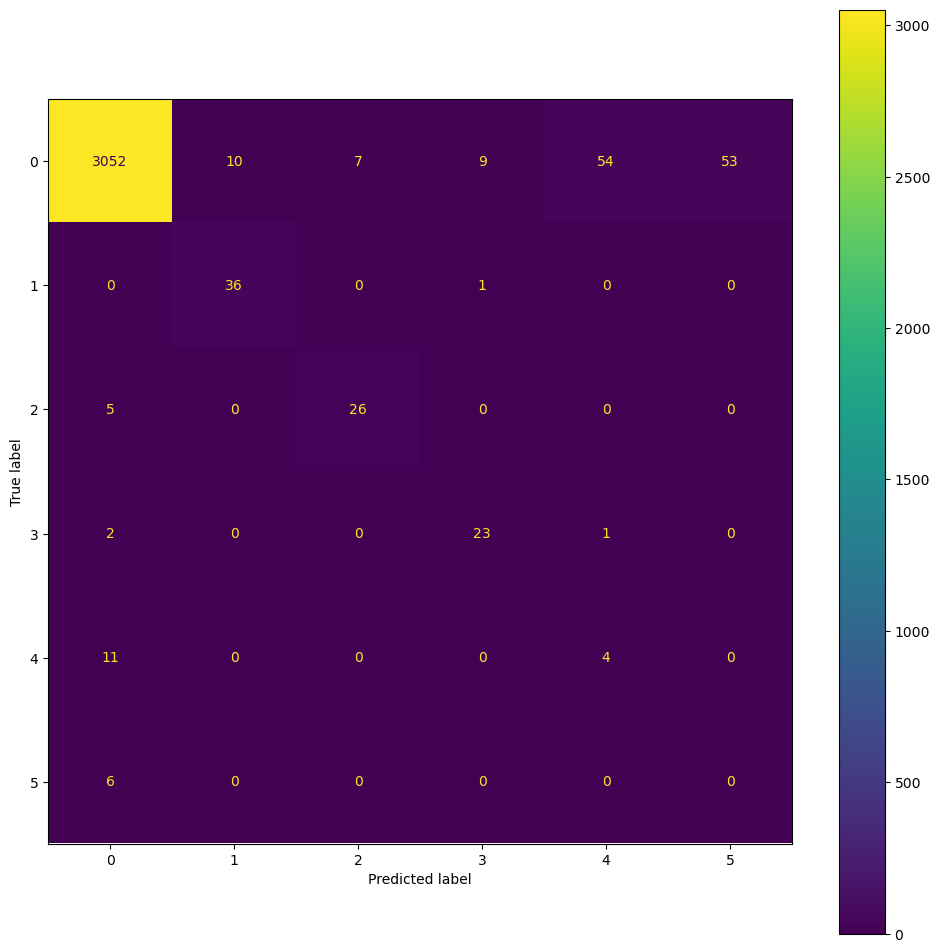

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3185
           1       0.78      0.97      0.87        37
           2       0.79      0.84      0.81        31
           3       0.70      0.88      0.78        26
           4       0.07      0.27      0.11        15
           5       0.00      0.00      0.00         6

    accuracy                           0.95      3300
   macro avg       0.55      0.65      0.59      3300
weighted avg       0.98      0.95      0.96      3300



In [64]:
fig, ax = plt.subplots(figsize=(12, 12))
cm = confusion_matrix(y_test, yhat_ovr)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)
plt.show();
print(classification_report(y_test, yhat_ovr))

In [65]:
cat_accuracy = accuracy_score(y_test, yhat_ovr)
cat_mcc = matthews_corrcoef(y_test, yhat_ovr)

print("CatBoost:")
print("Balanced Accuracy Score: %.4f" %(balanced_accuracy_score(y_test, yhat_ovr)))
print("Accuracy Score: %.4f" % cat_accuracy)
print("Matthews Correlation Coefficient: %.4f\n" % cat_mcc)

CatBoost:
Balanced Accuracy Score: 0.6535
Accuracy Score: 0.9518
Matthews Correlation Coefficient: 0.5492



In [66]:
catb_ovo = CatBoostClassifier()
ovo = OneVsOneClassifier(catb_ovo)

In [67]:
ovo.fit(X1_res, y1_res)
yhat_ovo = ovo.predict(X_test)

Learning rate set to 0.030705
0:	learn: 0.6176637	total: 16.1ms	remaining: 16.1s
1:	learn: 0.5471166	total: 28.8ms	remaining: 14.3s
2:	learn: 0.4854804	total: 44.3ms	remaining: 14.7s
3:	learn: 0.4335119	total: 55ms	remaining: 13.7s
4:	learn: 0.3893886	total: 67ms	remaining: 13.3s
5:	learn: 0.3491452	total: 82.5ms	remaining: 13.7s
6:	learn: 0.3122628	total: 97ms	remaining: 13.8s
7:	learn: 0.2781418	total: 111ms	remaining: 13.8s
8:	learn: 0.2503753	total: 127ms	remaining: 14s
9:	learn: 0.2251029	total: 141ms	remaining: 13.9s
10:	learn: 0.2031221	total: 155ms	remaining: 13.9s
11:	learn: 0.1792219	total: 170ms	remaining: 14s
12:	learn: 0.1622441	total: 185ms	remaining: 14s
13:	learn: 0.1481496	total: 199ms	remaining: 14s
14:	learn: 0.1362959	total: 211ms	remaining: 13.9s
15:	learn: 0.1250623	total: 222ms	remaining: 13.7s
16:	learn: 0.1168150	total: 233ms	remaining: 13.5s
17:	learn: 0.1064346	total: 247ms	remaining: 13.5s
18:	learn: 0.0980770	total: 260ms	remaining: 13.4s
19:	learn: 0.09190

164:	learn: 0.0049452	total: 2.31s	remaining: 11.7s
165:	learn: 0.0049343	total: 2.33s	remaining: 11.7s
166:	learn: 0.0048895	total: 2.34s	remaining: 11.7s
167:	learn: 0.0048721	total: 2.36s	remaining: 11.7s
168:	learn: 0.0048212	total: 2.37s	remaining: 11.7s
169:	learn: 0.0047955	total: 2.39s	remaining: 11.7s
170:	learn: 0.0047508	total: 2.4s	remaining: 11.6s
171:	learn: 0.0047193	total: 2.41s	remaining: 11.6s
172:	learn: 0.0046895	total: 2.42s	remaining: 11.6s
173:	learn: 0.0046536	total: 2.44s	remaining: 11.6s
174:	learn: 0.0046217	total: 2.45s	remaining: 11.6s
175:	learn: 0.0045870	total: 2.47s	remaining: 11.5s
176:	learn: 0.0045768	total: 2.48s	remaining: 11.5s
177:	learn: 0.0045322	total: 2.49s	remaining: 11.5s
178:	learn: 0.0045017	total: 2.5s	remaining: 11.5s
179:	learn: 0.0044920	total: 2.52s	remaining: 11.5s
180:	learn: 0.0044671	total: 2.53s	remaining: 11.5s
181:	learn: 0.0044163	total: 2.54s	remaining: 11.4s
182:	learn: 0.0043655	total: 2.56s	remaining: 11.4s
183:	learn: 0.

339:	learn: 0.0019380	total: 4.63s	remaining: 8.98s
340:	learn: 0.0019249	total: 4.64s	remaining: 8.97s
341:	learn: 0.0019249	total: 4.65s	remaining: 8.95s
342:	learn: 0.0019102	total: 4.66s	remaining: 8.93s
343:	learn: 0.0019102	total: 4.67s	remaining: 8.9s
344:	learn: 0.0019102	total: 4.68s	remaining: 8.89s
345:	learn: 0.0019102	total: 4.69s	remaining: 8.87s
346:	learn: 0.0019102	total: 4.7s	remaining: 8.85s
347:	learn: 0.0019102	total: 4.71s	remaining: 8.83s
348:	learn: 0.0019102	total: 4.73s	remaining: 8.81s
349:	learn: 0.0019102	total: 4.74s	remaining: 8.79s
350:	learn: 0.0018962	total: 4.75s	remaining: 8.78s
351:	learn: 0.0018895	total: 4.76s	remaining: 8.76s
352:	learn: 0.0018752	total: 4.78s	remaining: 8.75s
353:	learn: 0.0018752	total: 4.79s	remaining: 8.74s
354:	learn: 0.0018662	total: 4.8s	remaining: 8.72s
355:	learn: 0.0018662	total: 4.81s	remaining: 8.71s
356:	learn: 0.0018662	total: 4.82s	remaining: 8.69s
357:	learn: 0.0018662	total: 4.83s	remaining: 8.67s
358:	learn: 0.0

505:	learn: 0.0018399	total: 6.51s	remaining: 6.35s
506:	learn: 0.0018399	total: 6.52s	remaining: 6.34s
507:	learn: 0.0018399	total: 6.53s	remaining: 6.33s
508:	learn: 0.0018399	total: 6.54s	remaining: 6.31s
509:	learn: 0.0018399	total: 6.56s	remaining: 6.3s
510:	learn: 0.0018399	total: 6.57s	remaining: 6.29s
511:	learn: 0.0018399	total: 6.58s	remaining: 6.27s
512:	learn: 0.0018399	total: 6.59s	remaining: 6.26s
513:	learn: 0.0018399	total: 6.61s	remaining: 6.25s
514:	learn: 0.0018399	total: 6.62s	remaining: 6.23s
515:	learn: 0.0018399	total: 6.63s	remaining: 6.22s
516:	learn: 0.0018399	total: 6.64s	remaining: 6.2s
517:	learn: 0.0018399	total: 6.65s	remaining: 6.19s
518:	learn: 0.0018399	total: 6.67s	remaining: 6.18s
519:	learn: 0.0018399	total: 6.68s	remaining: 6.16s
520:	learn: 0.0018399	total: 6.69s	remaining: 6.15s
521:	learn: 0.0018399	total: 6.7s	remaining: 6.13s
522:	learn: 0.0018399	total: 6.71s	remaining: 6.12s
523:	learn: 0.0018399	total: 6.72s	remaining: 6.11s
524:	learn: 0.0

677:	learn: 0.0018397	total: 8.4s	remaining: 3.99s
678:	learn: 0.0018397	total: 8.41s	remaining: 3.98s
679:	learn: 0.0018397	total: 8.42s	remaining: 3.96s
680:	learn: 0.0018397	total: 8.43s	remaining: 3.95s
681:	learn: 0.0018397	total: 8.44s	remaining: 3.94s
682:	learn: 0.0018397	total: 8.46s	remaining: 3.92s
683:	learn: 0.0018397	total: 8.47s	remaining: 3.91s
684:	learn: 0.0018397	total: 8.48s	remaining: 3.9s
685:	learn: 0.0018397	total: 8.49s	remaining: 3.89s
686:	learn: 0.0018397	total: 8.5s	remaining: 3.87s
687:	learn: 0.0018397	total: 8.51s	remaining: 3.86s
688:	learn: 0.0018397	total: 8.52s	remaining: 3.85s
689:	learn: 0.0018397	total: 8.54s	remaining: 3.83s
690:	learn: 0.0018397	total: 8.54s	remaining: 3.82s
691:	learn: 0.0018397	total: 8.55s	remaining: 3.81s
692:	learn: 0.0018397	total: 8.56s	remaining: 3.79s
693:	learn: 0.0018397	total: 8.57s	remaining: 3.78s
694:	learn: 0.0018397	total: 8.59s	remaining: 3.77s
695:	learn: 0.0018397	total: 8.6s	remaining: 3.75s
696:	learn: 0.00

849:	learn: 0.0018397	total: 10.3s	remaining: 1.82s
850:	learn: 0.0018397	total: 10.3s	remaining: 1.81s
851:	learn: 0.0018397	total: 10.3s	remaining: 1.79s
852:	learn: 0.0018397	total: 10.3s	remaining: 1.78s
853:	learn: 0.0018397	total: 10.4s	remaining: 1.77s
854:	learn: 0.0018397	total: 10.4s	remaining: 1.76s
855:	learn: 0.0018397	total: 10.4s	remaining: 1.75s
856:	learn: 0.0018397	total: 10.4s	remaining: 1.73s
857:	learn: 0.0018397	total: 10.4s	remaining: 1.72s
858:	learn: 0.0018397	total: 10.4s	remaining: 1.71s
859:	learn: 0.0018397	total: 10.4s	remaining: 1.7s
860:	learn: 0.0018397	total: 10.4s	remaining: 1.68s
861:	learn: 0.0018397	total: 10.4s	remaining: 1.67s
862:	learn: 0.0018397	total: 10.5s	remaining: 1.66s
863:	learn: 0.0018397	total: 10.5s	remaining: 1.65s
864:	learn: 0.0018396	total: 10.5s	remaining: 1.63s
865:	learn: 0.0018396	total: 10.5s	remaining: 1.62s
866:	learn: 0.0018396	total: 10.5s	remaining: 1.61s
867:	learn: 0.0018396	total: 10.5s	remaining: 1.6s
868:	learn: 0.

13:	learn: 0.1567373	total: 198ms	remaining: 13.9s
14:	learn: 0.1382254	total: 210ms	remaining: 13.8s
15:	learn: 0.1241341	total: 226ms	remaining: 13.9s
16:	learn: 0.1143010	total: 241ms	remaining: 13.9s
17:	learn: 0.1034440	total: 256ms	remaining: 13.9s
18:	learn: 0.0969190	total: 270ms	remaining: 13.9s
19:	learn: 0.0891987	total: 283ms	remaining: 13.9s
20:	learn: 0.0836953	total: 298ms	remaining: 13.9s
21:	learn: 0.0778258	total: 314ms	remaining: 13.9s
22:	learn: 0.0740132	total: 329ms	remaining: 14s
23:	learn: 0.0706912	total: 341ms	remaining: 13.9s
24:	learn: 0.0648571	total: 355ms	remaining: 13.8s
25:	learn: 0.0609496	total: 369ms	remaining: 13.8s
26:	learn: 0.0574984	total: 382ms	remaining: 13.8s
27:	learn: 0.0546799	total: 396ms	remaining: 13.8s
28:	learn: 0.0506187	total: 409ms	remaining: 13.7s
29:	learn: 0.0462505	total: 423ms	remaining: 13.7s
30:	learn: 0.0425415	total: 438ms	remaining: 13.7s
31:	learn: 0.0403959	total: 452ms	remaining: 13.7s
32:	learn: 0.0386795	total: 466ms

182:	learn: 0.0046530	total: 2.55s	remaining: 11.4s
183:	learn: 0.0046317	total: 2.56s	remaining: 11.4s
184:	learn: 0.0046223	total: 2.58s	remaining: 11.4s
185:	learn: 0.0045574	total: 2.59s	remaining: 11.3s
186:	learn: 0.0045354	total: 2.6s	remaining: 11.3s
187:	learn: 0.0045226	total: 2.62s	remaining: 11.3s
188:	learn: 0.0045094	total: 2.63s	remaining: 11.3s
189:	learn: 0.0045012	total: 2.64s	remaining: 11.3s
190:	learn: 0.0044786	total: 2.66s	remaining: 11.3s
191:	learn: 0.0044698	total: 2.67s	remaining: 11.3s
192:	learn: 0.0044451	total: 2.69s	remaining: 11.2s
193:	learn: 0.0043915	total: 2.7s	remaining: 11.2s
194:	learn: 0.0043623	total: 2.71s	remaining: 11.2s
195:	learn: 0.0043509	total: 2.73s	remaining: 11.2s
196:	learn: 0.0043250	total: 2.74s	remaining: 11.2s
197:	learn: 0.0042941	total: 2.75s	remaining: 11.2s
198:	learn: 0.0042560	total: 2.77s	remaining: 11.1s
199:	learn: 0.0042341	total: 2.78s	remaining: 11.1s
200:	learn: 0.0042166	total: 2.79s	remaining: 11.1s
201:	learn: 0.

350:	learn: 0.0019483	total: 4.83s	remaining: 8.93s
351:	learn: 0.0019483	total: 4.84s	remaining: 8.9s
352:	learn: 0.0019483	total: 4.85s	remaining: 8.89s
353:	learn: 0.0019483	total: 4.86s	remaining: 8.87s
354:	learn: 0.0019483	total: 4.87s	remaining: 8.84s
355:	learn: 0.0019483	total: 4.88s	remaining: 8.82s
356:	learn: 0.0019449	total: 4.89s	remaining: 8.81s
357:	learn: 0.0019341	total: 4.91s	remaining: 8.8s
358:	learn: 0.0019341	total: 4.92s	remaining: 8.78s
359:	learn: 0.0019341	total: 4.93s	remaining: 8.76s
360:	learn: 0.0019341	total: 4.94s	remaining: 8.74s
361:	learn: 0.0019198	total: 4.95s	remaining: 8.73s
362:	learn: 0.0019198	total: 4.96s	remaining: 8.71s
363:	learn: 0.0019198	total: 4.98s	remaining: 8.69s
364:	learn: 0.0019198	total: 4.99s	remaining: 8.68s
365:	learn: 0.0019198	total: 5s	remaining: 8.66s
366:	learn: 0.0019198	total: 5.01s	remaining: 8.64s
367:	learn: 0.0019198	total: 5.02s	remaining: 8.62s
368:	learn: 0.0019150	total: 5.03s	remaining: 8.61s
369:	learn: 0.001

516:	learn: 0.0018903	total: 6.72s	remaining: 6.28s
517:	learn: 0.0018903	total: 6.73s	remaining: 6.26s
518:	learn: 0.0018903	total: 6.74s	remaining: 6.24s
519:	learn: 0.0018902	total: 6.75s	remaining: 6.23s
520:	learn: 0.0018902	total: 6.76s	remaining: 6.22s
521:	learn: 0.0018902	total: 6.77s	remaining: 6.2s
522:	learn: 0.0018902	total: 6.79s	remaining: 6.19s
523:	learn: 0.0018902	total: 6.8s	remaining: 6.17s
524:	learn: 0.0018902	total: 6.81s	remaining: 6.16s
525:	learn: 0.0018902	total: 6.82s	remaining: 6.15s
526:	learn: 0.0018902	total: 6.83s	remaining: 6.13s
527:	learn: 0.0018902	total: 6.84s	remaining: 6.12s
528:	learn: 0.0018902	total: 6.85s	remaining: 6.1s
529:	learn: 0.0018902	total: 6.87s	remaining: 6.09s
530:	learn: 0.0018902	total: 6.88s	remaining: 6.07s
531:	learn: 0.0018902	total: 6.89s	remaining: 6.06s
532:	learn: 0.0018902	total: 6.9s	remaining: 6.04s
533:	learn: 0.0018902	total: 6.91s	remaining: 6.03s
534:	learn: 0.0018902	total: 6.92s	remaining: 6.01s
535:	learn: 0.00

683:	learn: 0.0018900	total: 8.58s	remaining: 3.96s
684:	learn: 0.0018900	total: 8.59s	remaining: 3.95s
685:	learn: 0.0018900	total: 8.6s	remaining: 3.94s
686:	learn: 0.0018900	total: 8.62s	remaining: 3.92s
687:	learn: 0.0018900	total: 8.63s	remaining: 3.91s
688:	learn: 0.0018900	total: 8.64s	remaining: 3.9s
689:	learn: 0.0018900	total: 8.65s	remaining: 3.88s
690:	learn: 0.0018900	total: 8.66s	remaining: 3.87s
691:	learn: 0.0018900	total: 8.67s	remaining: 3.86s
692:	learn: 0.0018900	total: 8.68s	remaining: 3.85s
693:	learn: 0.0018900	total: 8.69s	remaining: 3.83s
694:	learn: 0.0018900	total: 8.7s	remaining: 3.82s
695:	learn: 0.0018900	total: 8.71s	remaining: 3.81s
696:	learn: 0.0018900	total: 8.73s	remaining: 3.79s
697:	learn: 0.0018900	total: 8.74s	remaining: 3.78s
698:	learn: 0.0018900	total: 8.75s	remaining: 3.77s
699:	learn: 0.0018900	total: 8.76s	remaining: 3.75s
700:	learn: 0.0018900	total: 8.77s	remaining: 3.74s
701:	learn: 0.0018900	total: 8.78s	remaining: 3.73s
702:	learn: 0.0

850:	learn: 0.0018900	total: 10.4s	remaining: 1.83s
851:	learn: 0.0018900	total: 10.5s	remaining: 1.81s
852:	learn: 0.0018900	total: 10.5s	remaining: 1.8s
853:	learn: 0.0018900	total: 10.5s	remaining: 1.79s
854:	learn: 0.0018900	total: 10.5s	remaining: 1.78s
855:	learn: 0.0018900	total: 10.5s	remaining: 1.76s
856:	learn: 0.0018900	total: 10.5s	remaining: 1.75s
857:	learn: 0.0018900	total: 10.5s	remaining: 1.74s
858:	learn: 0.0018900	total: 10.5s	remaining: 1.73s
859:	learn: 0.0018900	total: 10.5s	remaining: 1.72s
860:	learn: 0.0018900	total: 10.6s	remaining: 1.7s
861:	learn: 0.0018900	total: 10.6s	remaining: 1.69s
862:	learn: 0.0018900	total: 10.6s	remaining: 1.68s
863:	learn: 0.0018900	total: 10.6s	remaining: 1.67s
864:	learn: 0.0018900	total: 10.6s	remaining: 1.65s
865:	learn: 0.0018900	total: 10.6s	remaining: 1.64s
866:	learn: 0.0018900	total: 10.6s	remaining: 1.63s
867:	learn: 0.0018900	total: 10.6s	remaining: 1.62s
868:	learn: 0.0018900	total: 10.6s	remaining: 1.6s
869:	learn: 0.0

13:	learn: 0.1411973	total: 202ms	remaining: 14.3s
14:	learn: 0.1277897	total: 215ms	remaining: 14.1s
15:	learn: 0.1170474	total: 228ms	remaining: 14s
16:	learn: 0.1076108	total: 242ms	remaining: 14s
17:	learn: 0.0989900	total: 257ms	remaining: 14s
18:	learn: 0.0908812	total: 270ms	remaining: 13.9s
19:	learn: 0.0826480	total: 284ms	remaining: 13.9s
20:	learn: 0.0765526	total: 298ms	remaining: 13.9s
21:	learn: 0.0703772	total: 313ms	remaining: 13.9s
22:	learn: 0.0652546	total: 327ms	remaining: 13.9s
23:	learn: 0.0602392	total: 341ms	remaining: 13.9s
24:	learn: 0.0553355	total: 357ms	remaining: 13.9s
25:	learn: 0.0515774	total: 372ms	remaining: 13.9s
26:	learn: 0.0481803	total: 387ms	remaining: 14s
27:	learn: 0.0447486	total: 401ms	remaining: 13.9s
28:	learn: 0.0417211	total: 413ms	remaining: 13.8s
29:	learn: 0.0391922	total: 427ms	remaining: 13.8s
30:	learn: 0.0367869	total: 440ms	remaining: 13.7s
31:	learn: 0.0348947	total: 453ms	remaining: 13.7s
32:	learn: 0.0328002	total: 468ms	remai

181:	learn: 0.0033427	total: 2.54s	remaining: 11.4s
182:	learn: 0.0033247	total: 2.55s	remaining: 11.4s
183:	learn: 0.0033070	total: 2.56s	remaining: 11.4s
184:	learn: 0.0032875	total: 2.58s	remaining: 11.4s
185:	learn: 0.0032542	total: 2.59s	remaining: 11.4s
186:	learn: 0.0032448	total: 2.61s	remaining: 11.3s
187:	learn: 0.0032164	total: 2.62s	remaining: 11.3s
188:	learn: 0.0032055	total: 2.64s	remaining: 11.3s
189:	learn: 0.0031873	total: 2.65s	remaining: 11.3s
190:	learn: 0.0031735	total: 2.67s	remaining: 11.3s
191:	learn: 0.0031609	total: 2.68s	remaining: 11.3s
192:	learn: 0.0031243	total: 2.69s	remaining: 11.3s
193:	learn: 0.0030880	total: 2.71s	remaining: 11.3s
194:	learn: 0.0030690	total: 2.72s	remaining: 11.2s
195:	learn: 0.0030596	total: 2.73s	remaining: 11.2s
196:	learn: 0.0030345	total: 2.75s	remaining: 11.2s
197:	learn: 0.0030201	total: 2.76s	remaining: 11.2s
198:	learn: 0.0030008	total: 2.77s	remaining: 11.2s
199:	learn: 0.0029861	total: 2.79s	remaining: 11.2s
200:	learn: 

341:	learn: 0.0016806	total: 4.64s	remaining: 8.94s
342:	learn: 0.0016806	total: 4.66s	remaining: 8.92s
343:	learn: 0.0016806	total: 4.67s	remaining: 8.9s
344:	learn: 0.0016806	total: 4.68s	remaining: 8.88s
345:	learn: 0.0016806	total: 4.69s	remaining: 8.87s
346:	learn: 0.0016806	total: 4.7s	remaining: 8.85s
347:	learn: 0.0016806	total: 4.71s	remaining: 8.83s
348:	learn: 0.0016806	total: 4.73s	remaining: 8.82s
349:	learn: 0.0016806	total: 4.74s	remaining: 8.8s
350:	learn: 0.0016806	total: 4.75s	remaining: 8.78s
351:	learn: 0.0016806	total: 4.76s	remaining: 8.76s
352:	learn: 0.0016806	total: 4.77s	remaining: 8.75s
353:	learn: 0.0016806	total: 4.78s	remaining: 8.73s
354:	learn: 0.0016805	total: 4.79s	remaining: 8.71s
355:	learn: 0.0016805	total: 4.8s	remaining: 8.69s
356:	learn: 0.0016805	total: 4.82s	remaining: 8.67s
357:	learn: 0.0016805	total: 4.83s	remaining: 8.65s
358:	learn: 0.0016805	total: 4.84s	remaining: 8.64s
359:	learn: 0.0016805	total: 4.85s	remaining: 8.62s
360:	learn: 0.00

508:	learn: 0.0016795	total: 6.52s	remaining: 6.29s
509:	learn: 0.0016794	total: 6.53s	remaining: 6.28s
510:	learn: 0.0016795	total: 6.54s	remaining: 6.26s
511:	learn: 0.0016795	total: 6.56s	remaining: 6.25s
512:	learn: 0.0016794	total: 6.57s	remaining: 6.23s
513:	learn: 0.0016795	total: 6.58s	remaining: 6.22s
514:	learn: 0.0016794	total: 6.59s	remaining: 6.21s
515:	learn: 0.0016794	total: 6.6s	remaining: 6.19s
516:	learn: 0.0016794	total: 6.61s	remaining: 6.18s
517:	learn: 0.0016794	total: 6.62s	remaining: 6.16s
518:	learn: 0.0016794	total: 6.63s	remaining: 6.15s
519:	learn: 0.0016794	total: 6.64s	remaining: 6.13s
520:	learn: 0.0016794	total: 6.65s	remaining: 6.12s
521:	learn: 0.0016794	total: 6.67s	remaining: 6.1s
522:	learn: 0.0016794	total: 6.68s	remaining: 6.09s
523:	learn: 0.0016794	total: 6.69s	remaining: 6.08s
524:	learn: 0.0016794	total: 6.7s	remaining: 6.06s
525:	learn: 0.0016794	total: 6.71s	remaining: 6.05s
526:	learn: 0.0016794	total: 6.73s	remaining: 6.04s
527:	learn: 0.0

674:	learn: 0.0016788	total: 8.4s	remaining: 4.05s
675:	learn: 0.0016788	total: 8.41s	remaining: 4.03s
676:	learn: 0.0016788	total: 8.43s	remaining: 4.02s
677:	learn: 0.0016788	total: 8.44s	remaining: 4.01s
678:	learn: 0.0016788	total: 8.45s	remaining: 3.99s
679:	learn: 0.0016788	total: 8.46s	remaining: 3.98s
680:	learn: 0.0016788	total: 8.47s	remaining: 3.97s
681:	learn: 0.0016788	total: 8.48s	remaining: 3.96s
682:	learn: 0.0016788	total: 8.49s	remaining: 3.94s
683:	learn: 0.0016788	total: 8.51s	remaining: 3.93s
684:	learn: 0.0016788	total: 8.52s	remaining: 3.92s
685:	learn: 0.0016788	total: 8.53s	remaining: 3.9s
686:	learn: 0.0016788	total: 8.54s	remaining: 3.89s
687:	learn: 0.0016787	total: 8.55s	remaining: 3.88s
688:	learn: 0.0016787	total: 8.57s	remaining: 3.87s
689:	learn: 0.0016787	total: 8.58s	remaining: 3.85s
690:	learn: 0.0016787	total: 8.59s	remaining: 3.84s
691:	learn: 0.0016787	total: 8.6s	remaining: 3.83s
692:	learn: 0.0016787	total: 8.62s	remaining: 3.82s
693:	learn: 0.0

839:	learn: 0.0016783	total: 10.3s	remaining: 1.96s
840:	learn: 0.0016783	total: 10.3s	remaining: 1.95s
841:	learn: 0.0016783	total: 10.3s	remaining: 1.94s
842:	learn: 0.0016783	total: 10.3s	remaining: 1.92s
843:	learn: 0.0016783	total: 10.3s	remaining: 1.91s
844:	learn: 0.0016783	total: 10.3s	remaining: 1.9s
845:	learn: 0.0016783	total: 10.4s	remaining: 1.89s
846:	learn: 0.0016783	total: 10.4s	remaining: 1.87s
847:	learn: 0.0016783	total: 10.4s	remaining: 1.86s
848:	learn: 0.0016783	total: 10.4s	remaining: 1.85s
849:	learn: 0.0016783	total: 10.4s	remaining: 1.83s
850:	learn: 0.0016783	total: 10.4s	remaining: 1.82s
851:	learn: 0.0016782	total: 10.4s	remaining: 1.81s
852:	learn: 0.0016782	total: 10.4s	remaining: 1.8s
853:	learn: 0.0016782	total: 10.4s	remaining: 1.79s
854:	learn: 0.0016782	total: 10.5s	remaining: 1.77s
855:	learn: 0.0016782	total: 10.5s	remaining: 1.76s
856:	learn: 0.0016782	total: 10.5s	remaining: 1.75s
857:	learn: 0.0016782	total: 10.5s	remaining: 1.74s
858:	learn: 0.

Learning rate set to 0.030702
0:	learn: 0.6279867	total: 17.2ms	remaining: 17.2s
1:	learn: 0.5663509	total: 33.2ms	remaining: 16.6s
2:	learn: 0.5128276	total: 48.3ms	remaining: 16.1s
3:	learn: 0.4705805	total: 62.3ms	remaining: 15.5s
4:	learn: 0.4323306	total: 77.3ms	remaining: 15.4s
5:	learn: 0.3958452	total: 91.5ms	remaining: 15.2s
6:	learn: 0.3623660	total: 106ms	remaining: 15s
7:	learn: 0.3331237	total: 119ms	remaining: 14.8s
8:	learn: 0.3082811	total: 133ms	remaining: 14.6s
9:	learn: 0.2867860	total: 146ms	remaining: 14.5s
10:	learn: 0.2696536	total: 161ms	remaining: 14.5s
11:	learn: 0.2517565	total: 175ms	remaining: 14.4s
12:	learn: 0.2362161	total: 190ms	remaining: 14.4s
13:	learn: 0.2221045	total: 205ms	remaining: 14.4s
14:	learn: 0.2100924	total: 220ms	remaining: 14.4s
15:	learn: 0.1995749	total: 233ms	remaining: 14.4s
16:	learn: 0.1906624	total: 248ms	remaining: 14.4s
17:	learn: 0.1820859	total: 262ms	remaining: 14.3s
18:	learn: 0.1741183	total: 275ms	remaining: 14.2s
19:	lea

162:	learn: 0.0465096	total: 2.31s	remaining: 11.9s
163:	learn: 0.0463733	total: 2.33s	remaining: 11.9s
164:	learn: 0.0461211	total: 2.34s	remaining: 11.9s
165:	learn: 0.0459645	total: 2.36s	remaining: 11.8s
166:	learn: 0.0458212	total: 2.37s	remaining: 11.8s
167:	learn: 0.0454445	total: 2.38s	remaining: 11.8s
168:	learn: 0.0453528	total: 2.4s	remaining: 11.8s
169:	learn: 0.0449917	total: 2.41s	remaining: 11.8s
170:	learn: 0.0448575	total: 2.43s	remaining: 11.8s
171:	learn: 0.0446831	total: 2.44s	remaining: 11.8s
172:	learn: 0.0444692	total: 2.46s	remaining: 11.8s
173:	learn: 0.0443871	total: 2.47s	remaining: 11.7s
174:	learn: 0.0442610	total: 2.48s	remaining: 11.7s
175:	learn: 0.0441669	total: 2.5s	remaining: 11.7s
176:	learn: 0.0441099	total: 2.51s	remaining: 11.7s
177:	learn: 0.0437900	total: 2.52s	remaining: 11.7s
178:	learn: 0.0437061	total: 2.54s	remaining: 11.6s
179:	learn: 0.0435822	total: 2.55s	remaining: 11.6s
180:	learn: 0.0433420	total: 2.57s	remaining: 11.6s
181:	learn: 0.

330:	learn: 0.0272701	total: 4.65s	remaining: 9.41s
331:	learn: 0.0271740	total: 4.67s	remaining: 9.39s
332:	learn: 0.0271568	total: 4.68s	remaining: 9.38s
333:	learn: 0.0270989	total: 4.7s	remaining: 9.37s
334:	learn: 0.0269834	total: 4.71s	remaining: 9.36s
335:	learn: 0.0269434	total: 4.73s	remaining: 9.35s
336:	learn: 0.0268587	total: 4.75s	remaining: 9.34s
337:	learn: 0.0267868	total: 4.76s	remaining: 9.32s
338:	learn: 0.0267272	total: 4.78s	remaining: 9.31s
339:	learn: 0.0267144	total: 4.79s	remaining: 9.29s
340:	learn: 0.0266850	total: 4.8s	remaining: 9.28s
341:	learn: 0.0266524	total: 4.82s	remaining: 9.27s
342:	learn: 0.0265488	total: 4.83s	remaining: 9.25s
343:	learn: 0.0264656	total: 4.84s	remaining: 9.24s
344:	learn: 0.0263683	total: 4.86s	remaining: 9.22s
345:	learn: 0.0263154	total: 4.87s	remaining: 9.21s
346:	learn: 0.0262270	total: 4.88s	remaining: 9.19s
347:	learn: 0.0260785	total: 4.9s	remaining: 9.18s
348:	learn: 0.0260419	total: 4.91s	remaining: 9.17s
349:	learn: 0.0

490:	learn: 0.0188811	total: 6.93s	remaining: 7.19s
491:	learn: 0.0188390	total: 6.94s	remaining: 7.17s
492:	learn: 0.0187726	total: 6.96s	remaining: 7.16s
493:	learn: 0.0187570	total: 6.97s	remaining: 7.14s
494:	learn: 0.0187246	total: 6.99s	remaining: 7.13s
495:	learn: 0.0186998	total: 7s	remaining: 7.11s
496:	learn: 0.0186849	total: 7.01s	remaining: 7.1s
497:	learn: 0.0186299	total: 7.03s	remaining: 7.08s
498:	learn: 0.0185611	total: 7.04s	remaining: 7.07s
499:	learn: 0.0185459	total: 7.06s	remaining: 7.06s
500:	learn: 0.0185356	total: 7.07s	remaining: 7.04s
501:	learn: 0.0185212	total: 7.09s	remaining: 7.03s
502:	learn: 0.0184766	total: 7.1s	remaining: 7.01s
503:	learn: 0.0184045	total: 7.11s	remaining: 7s
504:	learn: 0.0183832	total: 7.13s	remaining: 6.99s
505:	learn: 0.0183365	total: 7.14s	remaining: 6.97s
506:	learn: 0.0182796	total: 7.15s	remaining: 6.96s
507:	learn: 0.0182344	total: 7.17s	remaining: 6.94s
508:	learn: 0.0182051	total: 7.18s	remaining: 6.93s
509:	learn: 0.018182

655:	learn: 0.0137228	total: 9.24s	remaining: 4.84s
656:	learn: 0.0136935	total: 9.25s	remaining: 4.83s
657:	learn: 0.0136818	total: 9.26s	remaining: 4.82s
658:	learn: 0.0136434	total: 9.28s	remaining: 4.8s
659:	learn: 0.0136308	total: 9.29s	remaining: 4.79s
660:	learn: 0.0136184	total: 9.31s	remaining: 4.77s
661:	learn: 0.0135764	total: 9.32s	remaining: 4.76s
662:	learn: 0.0135492	total: 9.34s	remaining: 4.75s
663:	learn: 0.0135233	total: 9.35s	remaining: 4.73s
664:	learn: 0.0134989	total: 9.37s	remaining: 4.72s
665:	learn: 0.0134741	total: 9.38s	remaining: 4.71s
666:	learn: 0.0134574	total: 9.4s	remaining: 4.69s
667:	learn: 0.0134288	total: 9.41s	remaining: 4.68s
668:	learn: 0.0133920	total: 9.42s	remaining: 4.66s
669:	learn: 0.0133737	total: 9.44s	remaining: 4.65s
670:	learn: 0.0133686	total: 9.45s	remaining: 4.63s
671:	learn: 0.0133636	total: 9.47s	remaining: 4.62s
672:	learn: 0.0133287	total: 9.48s	remaining: 4.61s
673:	learn: 0.0132945	total: 9.49s	remaining: 4.59s
674:	learn: 0.

822:	learn: 0.0106539	total: 11.5s	remaining: 2.48s
823:	learn: 0.0106464	total: 11.6s	remaining: 2.47s
824:	learn: 0.0106396	total: 11.6s	remaining: 2.45s
825:	learn: 0.0106202	total: 11.6s	remaining: 2.44s
826:	learn: 0.0106030	total: 11.6s	remaining: 2.42s
827:	learn: 0.0105864	total: 11.6s	remaining: 2.41s
828:	learn: 0.0105788	total: 11.6s	remaining: 2.4s
829:	learn: 0.0105788	total: 11.6s	remaining: 2.38s
830:	learn: 0.0105788	total: 11.7s	remaining: 2.37s
831:	learn: 0.0105788	total: 11.7s	remaining: 2.35s
832:	learn: 0.0105788	total: 11.7s	remaining: 2.34s
833:	learn: 0.0105788	total: 11.7s	remaining: 2.33s
834:	learn: 0.0105788	total: 11.7s	remaining: 2.31s
835:	learn: 0.0105547	total: 11.7s	remaining: 2.3s
836:	learn: 0.0105547	total: 11.7s	remaining: 2.28s
837:	learn: 0.0105464	total: 11.7s	remaining: 2.27s
838:	learn: 0.0105464	total: 11.7s	remaining: 2.25s
839:	learn: 0.0105370	total: 11.8s	remaining: 2.24s
840:	learn: 0.0105370	total: 11.8s	remaining: 2.23s
841:	learn: 0.

982:	learn: 0.0091980	total: 13.7s	remaining: 236ms
983:	learn: 0.0091843	total: 13.7s	remaining: 222ms
984:	learn: 0.0091843	total: 13.7s	remaining: 209ms
985:	learn: 0.0091767	total: 13.7s	remaining: 195ms
986:	learn: 0.0091767	total: 13.7s	remaining: 181ms
987:	learn: 0.0091767	total: 13.7s	remaining: 167ms
988:	learn: 0.0091767	total: 13.7s	remaining: 153ms
989:	learn: 0.0091767	total: 13.8s	remaining: 139ms
990:	learn: 0.0091767	total: 13.8s	remaining: 125ms
991:	learn: 0.0091767	total: 13.8s	remaining: 111ms
992:	learn: 0.0091767	total: 13.8s	remaining: 97.2ms
993:	learn: 0.0091574	total: 13.8s	remaining: 83.3ms
994:	learn: 0.0091474	total: 13.8s	remaining: 69.4ms
995:	learn: 0.0091410	total: 13.8s	remaining: 55.5ms
996:	learn: 0.0091410	total: 13.8s	remaining: 41.6ms
997:	learn: 0.0091410	total: 13.8s	remaining: 27.8ms
998:	learn: 0.0091410	total: 13.9s	remaining: 13.9ms
999:	learn: 0.0091410	total: 13.9s	remaining: 0us
Learning rate set to 0.030695
0:	learn: 0.6618875	total: 17

147:	learn: 0.1399801	total: 2.08s	remaining: 12s
148:	learn: 0.1390742	total: 2.1s	remaining: 12s
149:	learn: 0.1380968	total: 2.11s	remaining: 12s
150:	learn: 0.1374663	total: 2.13s	remaining: 12s
151:	learn: 0.1368158	total: 2.14s	remaining: 11.9s
152:	learn: 0.1361000	total: 2.15s	remaining: 11.9s
153:	learn: 0.1351999	total: 2.17s	remaining: 11.9s
154:	learn: 0.1348563	total: 2.19s	remaining: 11.9s
155:	learn: 0.1342228	total: 2.2s	remaining: 11.9s
156:	learn: 0.1334123	total: 2.21s	remaining: 11.9s
157:	learn: 0.1331243	total: 2.23s	remaining: 11.9s
158:	learn: 0.1325366	total: 2.24s	remaining: 11.9s
159:	learn: 0.1321009	total: 2.25s	remaining: 11.8s
160:	learn: 0.1317837	total: 2.27s	remaining: 11.8s
161:	learn: 0.1308472	total: 2.29s	remaining: 11.8s
162:	learn: 0.1302823	total: 2.3s	remaining: 11.8s
163:	learn: 0.1296887	total: 2.31s	remaining: 11.8s
164:	learn: 0.1288197	total: 2.33s	remaining: 11.8s
165:	learn: 0.1282742	total: 2.34s	remaining: 11.8s
166:	learn: 0.1275859	t

311:	learn: 0.0749426	total: 4.41s	remaining: 9.73s
312:	learn: 0.0747095	total: 4.43s	remaining: 9.72s
313:	learn: 0.0744505	total: 4.44s	remaining: 9.71s
314:	learn: 0.0743401	total: 4.46s	remaining: 9.69s
315:	learn: 0.0740687	total: 4.47s	remaining: 9.68s
316:	learn: 0.0739022	total: 4.49s	remaining: 9.67s
317:	learn: 0.0737308	total: 4.5s	remaining: 9.65s
318:	learn: 0.0734861	total: 4.51s	remaining: 9.63s
319:	learn: 0.0732277	total: 4.53s	remaining: 9.62s
320:	learn: 0.0728375	total: 4.54s	remaining: 9.61s
321:	learn: 0.0726784	total: 4.55s	remaining: 9.59s
322:	learn: 0.0721447	total: 4.57s	remaining: 9.57s
323:	learn: 0.0718692	total: 4.58s	remaining: 9.56s
324:	learn: 0.0716011	total: 4.59s	remaining: 9.54s
325:	learn: 0.0714347	total: 4.61s	remaining: 9.53s
326:	learn: 0.0712684	total: 4.62s	remaining: 9.52s
327:	learn: 0.0710550	total: 4.64s	remaining: 9.5s
328:	learn: 0.0708091	total: 4.65s	remaining: 9.49s
329:	learn: 0.0706315	total: 4.67s	remaining: 9.48s
330:	learn: 0.

479:	learn: 0.0450716	total: 6.76s	remaining: 7.33s
480:	learn: 0.0449287	total: 6.78s	remaining: 7.32s
481:	learn: 0.0448083	total: 6.79s	remaining: 7.3s
482:	learn: 0.0447318	total: 6.81s	remaining: 7.29s
483:	learn: 0.0446539	total: 6.82s	remaining: 7.28s
484:	learn: 0.0445434	total: 6.84s	remaining: 7.26s
485:	learn: 0.0443973	total: 6.85s	remaining: 7.25s
486:	learn: 0.0443617	total: 6.86s	remaining: 7.23s
487:	learn: 0.0442631	total: 6.88s	remaining: 7.22s
488:	learn: 0.0441734	total: 6.89s	remaining: 7.2s
489:	learn: 0.0440589	total: 6.91s	remaining: 7.19s
490:	learn: 0.0439387	total: 6.92s	remaining: 7.18s
491:	learn: 0.0438446	total: 6.94s	remaining: 7.16s
492:	learn: 0.0436563	total: 6.95s	remaining: 7.15s
493:	learn: 0.0435876	total: 6.96s	remaining: 7.13s
494:	learn: 0.0434592	total: 6.98s	remaining: 7.12s
495:	learn: 0.0433978	total: 6.99s	remaining: 7.1s
496:	learn: 0.0433179	total: 7s	remaining: 7.09s
497:	learn: 0.0432676	total: 7.02s	remaining: 7.08s
498:	learn: 0.0431

644:	learn: 0.0307769	total: 9.06s	remaining: 4.99s
645:	learn: 0.0307202	total: 9.07s	remaining: 4.97s
646:	learn: 0.0306714	total: 9.09s	remaining: 4.96s
647:	learn: 0.0306410	total: 9.1s	remaining: 4.94s
648:	learn: 0.0306032	total: 9.12s	remaining: 4.93s
649:	learn: 0.0305297	total: 9.13s	remaining: 4.92s
650:	learn: 0.0304504	total: 9.14s	remaining: 4.9s
651:	learn: 0.0303963	total: 9.16s	remaining: 4.89s
652:	learn: 0.0303646	total: 9.17s	remaining: 4.87s
653:	learn: 0.0302926	total: 9.19s	remaining: 4.86s
654:	learn: 0.0302656	total: 9.2s	remaining: 4.84s
655:	learn: 0.0302142	total: 9.21s	remaining: 4.83s
656:	learn: 0.0301589	total: 9.23s	remaining: 4.82s
657:	learn: 0.0300925	total: 9.24s	remaining: 4.8s
658:	learn: 0.0300214	total: 9.26s	remaining: 4.79s
659:	learn: 0.0299314	total: 9.27s	remaining: 4.78s
660:	learn: 0.0298869	total: 9.29s	remaining: 4.76s
661:	learn: 0.0297932	total: 9.3s	remaining: 4.75s
662:	learn: 0.0297435	total: 9.31s	remaining: 4.73s
663:	learn: 0.029

808:	learn: 0.0226764	total: 11.3s	remaining: 2.68s
809:	learn: 0.0226454	total: 11.4s	remaining: 2.66s
810:	learn: 0.0226113	total: 11.4s	remaining: 2.65s
811:	learn: 0.0225936	total: 11.4s	remaining: 2.64s
812:	learn: 0.0225423	total: 11.4s	remaining: 2.62s
813:	learn: 0.0225134	total: 11.4s	remaining: 2.61s
814:	learn: 0.0224897	total: 11.4s	remaining: 2.6s
815:	learn: 0.0224539	total: 11.4s	remaining: 2.58s
816:	learn: 0.0224134	total: 11.5s	remaining: 2.57s
817:	learn: 0.0223995	total: 11.5s	remaining: 2.55s
818:	learn: 0.0223434	total: 11.5s	remaining: 2.54s
819:	learn: 0.0222783	total: 11.5s	remaining: 2.52s
820:	learn: 0.0222460	total: 11.5s	remaining: 2.51s
821:	learn: 0.0222145	total: 11.5s	remaining: 2.5s
822:	learn: 0.0221855	total: 11.5s	remaining: 2.48s
823:	learn: 0.0221214	total: 11.6s	remaining: 2.47s
824:	learn: 0.0220769	total: 11.6s	remaining: 2.46s
825:	learn: 0.0220433	total: 11.6s	remaining: 2.44s
826:	learn: 0.0219940	total: 11.6s	remaining: 2.43s
827:	learn: 0.

974:	learn: 0.0173270	total: 13.7s	remaining: 350ms
975:	learn: 0.0173038	total: 13.7s	remaining: 336ms
976:	learn: 0.0172843	total: 13.7s	remaining: 322ms
977:	learn: 0.0172592	total: 13.7s	remaining: 308ms
978:	learn: 0.0172385	total: 13.7s	remaining: 294ms
979:	learn: 0.0172162	total: 13.7s	remaining: 280ms
980:	learn: 0.0171960	total: 13.7s	remaining: 266ms
981:	learn: 0.0171861	total: 13.7s	remaining: 252ms
982:	learn: 0.0171485	total: 13.8s	remaining: 238ms
983:	learn: 0.0171162	total: 13.8s	remaining: 224ms
984:	learn: 0.0170602	total: 13.8s	remaining: 210ms
985:	learn: 0.0170316	total: 13.8s	remaining: 196ms
986:	learn: 0.0170191	total: 13.8s	remaining: 182ms
987:	learn: 0.0169826	total: 13.8s	remaining: 168ms
988:	learn: 0.0169670	total: 13.8s	remaining: 154ms
989:	learn: 0.0169590	total: 13.9s	remaining: 140ms
990:	learn: 0.0169483	total: 13.9s	remaining: 126ms
991:	learn: 0.0169284	total: 13.9s	remaining: 112ms
992:	learn: 0.0168935	total: 13.9s	remaining: 98ms
993:	learn: 0

138:	learn: 0.0003923	total: 1.88s	remaining: 11.7s
139:	learn: 0.0003923	total: 1.9s	remaining: 11.7s
140:	learn: 0.0003923	total: 1.91s	remaining: 11.6s
141:	learn: 0.0003923	total: 1.92s	remaining: 11.6s
142:	learn: 0.0003923	total: 1.93s	remaining: 11.6s
143:	learn: 0.0003923	total: 1.94s	remaining: 11.6s
144:	learn: 0.0003840	total: 1.96s	remaining: 11.5s
145:	learn: 0.0003840	total: 1.97s	remaining: 11.5s
146:	learn: 0.0003840	total: 1.98s	remaining: 11.5s
147:	learn: 0.0003840	total: 1.99s	remaining: 11.5s
148:	learn: 0.0003840	total: 2s	remaining: 11.4s
149:	learn: 0.0003774	total: 2.02s	remaining: 11.4s
150:	learn: 0.0003706	total: 2.03s	remaining: 11.4s
151:	learn: 0.0003706	total: 2.04s	remaining: 11.4s
152:	learn: 0.0003706	total: 2.05s	remaining: 11.4s
153:	learn: 0.0003706	total: 2.06s	remaining: 11.3s
154:	learn: 0.0003706	total: 2.08s	remaining: 11.3s
155:	learn: 0.0003706	total: 2.09s	remaining: 11.3s
156:	learn: 0.0003706	total: 2.1s	remaining: 11.3s
157:	learn: 0.000

302:	learn: 0.0003463	total: 3.77s	remaining: 8.67s
303:	learn: 0.0003464	total: 3.78s	remaining: 8.66s
304:	learn: 0.0003464	total: 3.79s	remaining: 8.64s
305:	learn: 0.0003463	total: 3.8s	remaining: 8.63s
306:	learn: 0.0003464	total: 3.82s	remaining: 8.62s
307:	learn: 0.0003463	total: 3.83s	remaining: 8.6s
308:	learn: 0.0003463	total: 3.84s	remaining: 8.58s
309:	learn: 0.0003463	total: 3.85s	remaining: 8.57s
310:	learn: 0.0003463	total: 3.86s	remaining: 8.56s
311:	learn: 0.0003463	total: 3.87s	remaining: 8.54s
312:	learn: 0.0003463	total: 3.89s	remaining: 8.53s
313:	learn: 0.0003463	total: 3.9s	remaining: 8.51s
314:	learn: 0.0003463	total: 3.91s	remaining: 8.5s
315:	learn: 0.0003463	total: 3.92s	remaining: 8.48s
316:	learn: 0.0003463	total: 3.93s	remaining: 8.47s
317:	learn: 0.0003464	total: 3.94s	remaining: 8.45s
318:	learn: 0.0003464	total: 3.95s	remaining: 8.44s
319:	learn: 0.0003464	total: 3.96s	remaining: 8.42s
320:	learn: 0.0003463	total: 3.97s	remaining: 8.4s
321:	learn: 0.000

462:	learn: 0.0003461	total: 5.62s	remaining: 6.52s
463:	learn: 0.0003461	total: 5.63s	remaining: 6.5s
464:	learn: 0.0003461	total: 5.64s	remaining: 6.49s
465:	learn: 0.0003461	total: 5.66s	remaining: 6.48s
466:	learn: 0.0003461	total: 5.67s	remaining: 6.47s
467:	learn: 0.0003461	total: 5.68s	remaining: 6.45s
468:	learn: 0.0003461	total: 5.69s	remaining: 6.44s
469:	learn: 0.0003461	total: 5.7s	remaining: 6.43s
470:	learn: 0.0003461	total: 5.71s	remaining: 6.42s
471:	learn: 0.0003461	total: 5.73s	remaining: 6.41s
472:	learn: 0.0003461	total: 5.74s	remaining: 6.39s
473:	learn: 0.0003461	total: 5.75s	remaining: 6.38s
474:	learn: 0.0003461	total: 5.76s	remaining: 6.37s
475:	learn: 0.0003460	total: 5.77s	remaining: 6.36s
476:	learn: 0.0003461	total: 5.79s	remaining: 6.34s
477:	learn: 0.0003460	total: 5.79s	remaining: 6.33s
478:	learn: 0.0003460	total: 5.81s	remaining: 6.32s
479:	learn: 0.0003460	total: 5.82s	remaining: 6.31s
480:	learn: 0.0003460	total: 5.83s	remaining: 6.29s
481:	learn: 0.

627:	learn: 0.0003459	total: 7.53s	remaining: 4.46s
628:	learn: 0.0003459	total: 7.54s	remaining: 4.45s
629:	learn: 0.0003459	total: 7.55s	remaining: 4.43s
630:	learn: 0.0003458	total: 7.56s	remaining: 4.42s
631:	learn: 0.0003458	total: 7.57s	remaining: 4.41s
632:	learn: 0.0003458	total: 7.58s	remaining: 4.4s
633:	learn: 0.0003458	total: 7.59s	remaining: 4.38s
634:	learn: 0.0003458	total: 7.61s	remaining: 4.37s
635:	learn: 0.0003458	total: 7.62s	remaining: 4.36s
636:	learn: 0.0003458	total: 7.63s	remaining: 4.35s
637:	learn: 0.0003458	total: 7.64s	remaining: 4.34s
638:	learn: 0.0003458	total: 7.65s	remaining: 4.32s
639:	learn: 0.0003458	total: 7.66s	remaining: 4.31s
640:	learn: 0.0003458	total: 7.67s	remaining: 4.3s
641:	learn: 0.0003458	total: 7.68s	remaining: 4.29s
642:	learn: 0.0003458	total: 7.7s	remaining: 4.27s
643:	learn: 0.0003458	total: 7.71s	remaining: 4.26s
644:	learn: 0.0003458	total: 7.72s	remaining: 4.25s
645:	learn: 0.0003458	total: 7.73s	remaining: 4.23s
646:	learn: 0.0

794:	learn: 0.0003458	total: 9.4s	remaining: 2.42s
795:	learn: 0.0003458	total: 9.42s	remaining: 2.41s
796:	learn: 0.0003458	total: 9.43s	remaining: 2.4s
797:	learn: 0.0003458	total: 9.44s	remaining: 2.39s
798:	learn: 0.0003458	total: 9.45s	remaining: 2.38s
799:	learn: 0.0003458	total: 9.46s	remaining: 2.36s
800:	learn: 0.0003458	total: 9.47s	remaining: 2.35s
801:	learn: 0.0003458	total: 9.48s	remaining: 2.34s
802:	learn: 0.0003458	total: 9.49s	remaining: 2.33s
803:	learn: 0.0003458	total: 9.5s	remaining: 2.32s
804:	learn: 0.0003458	total: 9.52s	remaining: 2.31s
805:	learn: 0.0003458	total: 9.53s	remaining: 2.29s
806:	learn: 0.0003458	total: 9.54s	remaining: 2.28s
807:	learn: 0.0003458	total: 9.55s	remaining: 2.27s
808:	learn: 0.0003458	total: 9.56s	remaining: 2.26s
809:	learn: 0.0003458	total: 9.57s	remaining: 2.25s
810:	learn: 0.0003458	total: 9.58s	remaining: 2.23s
811:	learn: 0.0003458	total: 9.59s	remaining: 2.22s
812:	learn: 0.0003458	total: 9.6s	remaining: 2.21s
813:	learn: 0.00

960:	learn: 0.0003458	total: 11.3s	remaining: 458ms
961:	learn: 0.0003458	total: 11.3s	remaining: 447ms
962:	learn: 0.0003458	total: 11.3s	remaining: 435ms
963:	learn: 0.0003458	total: 11.3s	remaining: 423ms
964:	learn: 0.0003458	total: 11.3s	remaining: 411ms
965:	learn: 0.0003458	total: 11.4s	remaining: 400ms
966:	learn: 0.0003458	total: 11.4s	remaining: 388ms
967:	learn: 0.0003458	total: 11.4s	remaining: 376ms
968:	learn: 0.0003458	total: 11.4s	remaining: 364ms
969:	learn: 0.0003458	total: 11.4s	remaining: 352ms
970:	learn: 0.0003458	total: 11.4s	remaining: 341ms
971:	learn: 0.0003458	total: 11.4s	remaining: 329ms
972:	learn: 0.0003458	total: 11.4s	remaining: 317ms
973:	learn: 0.0003458	total: 11.4s	remaining: 305ms
974:	learn: 0.0003458	total: 11.5s	remaining: 294ms
975:	learn: 0.0003458	total: 11.5s	remaining: 282ms
976:	learn: 0.0003458	total: 11.5s	remaining: 270ms
977:	learn: 0.0003458	total: 11.5s	remaining: 258ms
978:	learn: 0.0003458	total: 11.5s	remaining: 247ms
979:	learn: 

122:	learn: 0.0006577	total: 1.72s	remaining: 12.3s
123:	learn: 0.0006480	total: 1.74s	remaining: 12.3s
124:	learn: 0.0006480	total: 1.75s	remaining: 12.3s
125:	learn: 0.0006387	total: 1.76s	remaining: 12.2s
126:	learn: 0.0006387	total: 1.77s	remaining: 12.2s
127:	learn: 0.0006270	total: 1.79s	remaining: 12.2s
128:	learn: 0.0006178	total: 1.8s	remaining: 12.2s
129:	learn: 0.0006092	total: 1.82s	remaining: 12.2s
130:	learn: 0.0006092	total: 1.83s	remaining: 12.1s
131:	learn: 0.0006007	total: 1.84s	remaining: 12.1s
132:	learn: 0.0006007	total: 1.85s	remaining: 12.1s
133:	learn: 0.0005921	total: 1.87s	remaining: 12.1s
134:	learn: 0.0005833	total: 1.88s	remaining: 12.1s
135:	learn: 0.0005833	total: 1.89s	remaining: 12s
136:	learn: 0.0005833	total: 1.9s	remaining: 12s
137:	learn: 0.0005728	total: 1.92s	remaining: 12s
138:	learn: 0.0005649	total: 1.93s	remaining: 12s
139:	learn: 0.0005586	total: 1.95s	remaining: 12s
140:	learn: 0.0005586	total: 1.96s	remaining: 11.9s
141:	learn: 0.0005482	to

296:	learn: 0.0004287	total: 3.82s	remaining: 9.04s
297:	learn: 0.0004287	total: 3.83s	remaining: 9.02s
298:	learn: 0.0004287	total: 3.84s	remaining: 9.01s
299:	learn: 0.0004287	total: 3.85s	remaining: 8.99s
300:	learn: 0.0004287	total: 3.87s	remaining: 8.98s
301:	learn: 0.0004287	total: 3.88s	remaining: 8.96s
302:	learn: 0.0004287	total: 3.89s	remaining: 8.95s
303:	learn: 0.0004287	total: 3.9s	remaining: 8.93s
304:	learn: 0.0004287	total: 3.91s	remaining: 8.92s
305:	learn: 0.0004287	total: 3.92s	remaining: 8.9s
306:	learn: 0.0004287	total: 3.93s	remaining: 8.88s
307:	learn: 0.0004287	total: 3.95s	remaining: 8.87s
308:	learn: 0.0004287	total: 3.96s	remaining: 8.85s
309:	learn: 0.0004287	total: 3.97s	remaining: 8.83s
310:	learn: 0.0004286	total: 3.98s	remaining: 8.82s
311:	learn: 0.0004286	total: 3.99s	remaining: 8.81s
312:	learn: 0.0004286	total: 4s	remaining: 8.79s
313:	learn: 0.0004286	total: 4.02s	remaining: 8.78s
314:	learn: 0.0004286	total: 4.03s	remaining: 8.76s
315:	learn: 0.000

456:	learn: 0.0004278	total: 5.72s	remaining: 6.8s
457:	learn: 0.0004278	total: 5.74s	remaining: 6.79s
458:	learn: 0.0004278	total: 5.75s	remaining: 6.78s
459:	learn: 0.0004278	total: 5.76s	remaining: 6.76s
460:	learn: 0.0004278	total: 5.77s	remaining: 6.75s
461:	learn: 0.0004278	total: 5.79s	remaining: 6.74s
462:	learn: 0.0004277	total: 5.8s	remaining: 6.72s
463:	learn: 0.0004277	total: 5.81s	remaining: 6.71s
464:	learn: 0.0004277	total: 5.82s	remaining: 6.7s
465:	learn: 0.0004277	total: 5.83s	remaining: 6.68s
466:	learn: 0.0004277	total: 5.84s	remaining: 6.67s
467:	learn: 0.0004277	total: 5.86s	remaining: 6.66s
468:	learn: 0.0004277	total: 5.87s	remaining: 6.64s
469:	learn: 0.0004277	total: 5.88s	remaining: 6.63s
470:	learn: 0.0004277	total: 5.89s	remaining: 6.62s
471:	learn: 0.0004277	total: 5.9s	remaining: 6.61s
472:	learn: 0.0004277	total: 5.92s	remaining: 6.59s
473:	learn: 0.0004277	total: 5.93s	remaining: 6.58s
474:	learn: 0.0004276	total: 5.94s	remaining: 6.57s
475:	learn: 0.00

615:	learn: 0.0004269	total: 7.58s	remaining: 4.73s
616:	learn: 0.0004269	total: 7.6s	remaining: 4.72s
617:	learn: 0.0004269	total: 7.61s	remaining: 4.7s
618:	learn: 0.0004269	total: 7.62s	remaining: 4.69s
619:	learn: 0.0004269	total: 7.63s	remaining: 4.68s
620:	learn: 0.0004269	total: 7.64s	remaining: 4.66s
621:	learn: 0.0004269	total: 7.65s	remaining: 4.65s
622:	learn: 0.0004269	total: 7.66s	remaining: 4.64s
623:	learn: 0.0004269	total: 7.67s	remaining: 4.63s
624:	learn: 0.0004269	total: 7.69s	remaining: 4.61s
625:	learn: 0.0004269	total: 7.7s	remaining: 4.6s
626:	learn: 0.0004269	total: 7.71s	remaining: 4.59s
627:	learn: 0.0004269	total: 7.72s	remaining: 4.57s
628:	learn: 0.0004269	total: 7.73s	remaining: 4.56s
629:	learn: 0.0004269	total: 7.74s	remaining: 4.55s
630:	learn: 0.0004269	total: 7.76s	remaining: 4.54s
631:	learn: 0.0004269	total: 7.77s	remaining: 4.52s
632:	learn: 0.0004269	total: 7.78s	remaining: 4.51s
633:	learn: 0.0004269	total: 7.79s	remaining: 4.5s
634:	learn: 0.000

777:	learn: 0.0004263	total: 9.47s	remaining: 2.7s
778:	learn: 0.0004263	total: 9.48s	remaining: 2.69s
779:	learn: 0.0004263	total: 9.49s	remaining: 2.68s
780:	learn: 0.0004263	total: 9.5s	remaining: 2.66s
781:	learn: 0.0004263	total: 9.51s	remaining: 2.65s
782:	learn: 0.0004263	total: 9.52s	remaining: 2.64s
783:	learn: 0.0004263	total: 9.53s	remaining: 2.63s
784:	learn: 0.0004263	total: 9.55s	remaining: 2.61s
785:	learn: 0.0004263	total: 9.55s	remaining: 2.6s
786:	learn: 0.0004263	total: 9.57s	remaining: 2.59s
787:	learn: 0.0004263	total: 9.58s	remaining: 2.58s
788:	learn: 0.0004263	total: 9.59s	remaining: 2.56s
789:	learn: 0.0004263	total: 9.6s	remaining: 2.55s
790:	learn: 0.0004262	total: 9.61s	remaining: 2.54s
791:	learn: 0.0004262	total: 9.62s	remaining: 2.53s
792:	learn: 0.0004262	total: 9.63s	remaining: 2.51s
793:	learn: 0.0004262	total: 9.64s	remaining: 2.5s
794:	learn: 0.0004262	total: 9.65s	remaining: 2.49s
795:	learn: 0.0004262	total: 9.67s	remaining: 2.48s
796:	learn: 0.000

947:	learn: 0.0004255	total: 11.4s	remaining: 623ms
948:	learn: 0.0004255	total: 11.4s	remaining: 611ms
949:	learn: 0.0004255	total: 11.4s	remaining: 599ms
950:	learn: 0.0004255	total: 11.4s	remaining: 587ms
951:	learn: 0.0004255	total: 11.4s	remaining: 575ms
952:	learn: 0.0004255	total: 11.4s	remaining: 563ms
953:	learn: 0.0004255	total: 11.4s	remaining: 551ms
954:	learn: 0.0004255	total: 11.4s	remaining: 539ms
955:	learn: 0.0004255	total: 11.4s	remaining: 527ms
956:	learn: 0.0004255	total: 11.5s	remaining: 515ms
957:	learn: 0.0004255	total: 11.5s	remaining: 503ms
958:	learn: 0.0004255	total: 11.5s	remaining: 491ms
959:	learn: 0.0004255	total: 11.5s	remaining: 479ms
960:	learn: 0.0004255	total: 11.5s	remaining: 467ms
961:	learn: 0.0004255	total: 11.5s	remaining: 455ms
962:	learn: 0.0004255	total: 11.5s	remaining: 443ms
963:	learn: 0.0004255	total: 11.5s	remaining: 431ms
964:	learn: 0.0004255	total: 11.5s	remaining: 419ms
965:	learn: 0.0004255	total: 11.6s	remaining: 407ms
966:	learn: 

107:	learn: 0.0003852	total: 1.48s	remaining: 12.3s
108:	learn: 0.0003852	total: 1.5s	remaining: 12.2s
109:	learn: 0.0003852	total: 1.51s	remaining: 12.2s
110:	learn: 0.0003852	total: 1.52s	remaining: 12.2s
111:	learn: 0.0003852	total: 1.53s	remaining: 12.1s
112:	learn: 0.0003852	total: 1.54s	remaining: 12.1s
113:	learn: 0.0003852	total: 1.55s	remaining: 12.1s
114:	learn: 0.0003852	total: 1.57s	remaining: 12.1s
115:	learn: 0.0003851	total: 1.58s	remaining: 12s
116:	learn: 0.0003851	total: 1.59s	remaining: 12s
117:	learn: 0.0003851	total: 1.6s	remaining: 12s
118:	learn: 0.0003851	total: 1.61s	remaining: 12s
119:	learn: 0.0003851	total: 1.63s	remaining: 11.9s
120:	learn: 0.0003851	total: 1.64s	remaining: 11.9s
121:	learn: 0.0003851	total: 1.65s	remaining: 11.9s
122:	learn: 0.0003851	total: 1.66s	remaining: 11.8s
123:	learn: 0.0003851	total: 1.67s	remaining: 11.8s
124:	learn: 0.0003851	total: 1.68s	remaining: 11.8s
125:	learn: 0.0003851	total: 1.7s	remaining: 11.8s
126:	learn: 0.0003851	t

267:	learn: 0.0003848	total: 3.34s	remaining: 9.13s
268:	learn: 0.0003848	total: 3.36s	remaining: 9.12s
269:	learn: 0.0003848	total: 3.37s	remaining: 9.11s
270:	learn: 0.0003848	total: 3.38s	remaining: 9.09s
271:	learn: 0.0003848	total: 3.39s	remaining: 9.08s
272:	learn: 0.0003847	total: 3.4s	remaining: 9.07s
273:	learn: 0.0003847	total: 3.42s	remaining: 9.05s
274:	learn: 0.0003847	total: 3.43s	remaining: 9.04s
275:	learn: 0.0003847	total: 3.44s	remaining: 9.02s
276:	learn: 0.0003847	total: 3.45s	remaining: 9.01s
277:	learn: 0.0003847	total: 3.46s	remaining: 8.99s
278:	learn: 0.0003847	total: 3.47s	remaining: 8.98s
279:	learn: 0.0003847	total: 3.49s	remaining: 8.96s
280:	learn: 0.0003847	total: 3.5s	remaining: 8.95s
281:	learn: 0.0003847	total: 3.51s	remaining: 8.93s
282:	learn: 0.0003847	total: 3.52s	remaining: 8.92s
283:	learn: 0.0003847	total: 3.53s	remaining: 8.91s
284:	learn: 0.0003847	total: 3.54s	remaining: 8.89s
285:	learn: 0.0003847	total: 3.55s	remaining: 8.87s
286:	learn: 0.

430:	learn: 0.0003844	total: 5.23s	remaining: 6.9s
431:	learn: 0.0003844	total: 5.24s	remaining: 6.89s
432:	learn: 0.0003844	total: 5.26s	remaining: 6.88s
433:	learn: 0.0003844	total: 5.27s	remaining: 6.87s
434:	learn: 0.0003844	total: 5.28s	remaining: 6.86s
435:	learn: 0.0003844	total: 5.29s	remaining: 6.84s
436:	learn: 0.0003844	total: 5.3s	remaining: 6.83s
437:	learn: 0.0003844	total: 5.31s	remaining: 6.82s
438:	learn: 0.0003844	total: 5.33s	remaining: 6.8s
439:	learn: 0.0003844	total: 5.33s	remaining: 6.79s
440:	learn: 0.0003844	total: 5.35s	remaining: 6.78s
441:	learn: 0.0003843	total: 5.36s	remaining: 6.76s
442:	learn: 0.0003844	total: 5.37s	remaining: 6.75s
443:	learn: 0.0003843	total: 5.38s	remaining: 6.74s
444:	learn: 0.0003843	total: 5.39s	remaining: 6.73s
445:	learn: 0.0003843	total: 5.41s	remaining: 6.71s
446:	learn: 0.0003843	total: 5.42s	remaining: 6.7s
447:	learn: 0.0003843	total: 5.43s	remaining: 6.69s
448:	learn: 0.0003843	total: 5.44s	remaining: 6.68s
449:	learn: 0.00

591:	learn: 0.0003840	total: 7.1s	remaining: 4.89s
592:	learn: 0.0003840	total: 7.11s	remaining: 4.88s
593:	learn: 0.0003840	total: 7.13s	remaining: 4.87s
594:	learn: 0.0003840	total: 7.14s	remaining: 4.86s
595:	learn: 0.0003840	total: 7.15s	remaining: 4.84s
596:	learn: 0.0003840	total: 7.16s	remaining: 4.83s
597:	learn: 0.0003840	total: 7.17s	remaining: 4.82s
598:	learn: 0.0003840	total: 7.18s	remaining: 4.81s
599:	learn: 0.0003840	total: 7.19s	remaining: 4.79s
600:	learn: 0.0003840	total: 7.21s	remaining: 4.78s
601:	learn: 0.0003840	total: 7.22s	remaining: 4.77s
602:	learn: 0.0003840	total: 7.23s	remaining: 4.76s
603:	learn: 0.0003840	total: 7.24s	remaining: 4.75s
604:	learn: 0.0003840	total: 7.25s	remaining: 4.74s
605:	learn: 0.0003840	total: 7.26s	remaining: 4.72s
606:	learn: 0.0003840	total: 7.28s	remaining: 4.71s
607:	learn: 0.0003840	total: 7.29s	remaining: 4.7s
608:	learn: 0.0003840	total: 7.3s	remaining: 4.68s
609:	learn: 0.0003840	total: 7.31s	remaining: 4.67s
610:	learn: 0.0

756:	learn: 0.0003840	total: 8.97s	remaining: 2.88s
757:	learn: 0.0003840	total: 8.98s	remaining: 2.87s
758:	learn: 0.0003840	total: 9s	remaining: 2.86s
759:	learn: 0.0003840	total: 9.01s	remaining: 2.84s
760:	learn: 0.0003840	total: 9.02s	remaining: 2.83s
761:	learn: 0.0003840	total: 9.03s	remaining: 2.82s
762:	learn: 0.0003840	total: 9.04s	remaining: 2.81s
763:	learn: 0.0003840	total: 9.05s	remaining: 2.8s
764:	learn: 0.0003840	total: 9.06s	remaining: 2.78s
765:	learn: 0.0003840	total: 9.07s	remaining: 2.77s
766:	learn: 0.0003840	total: 9.09s	remaining: 2.76s
767:	learn: 0.0003840	total: 9.1s	remaining: 2.75s
768:	learn: 0.0003840	total: 9.11s	remaining: 2.74s
769:	learn: 0.0003840	total: 9.12s	remaining: 2.72s
770:	learn: 0.0003840	total: 9.13s	remaining: 2.71s
771:	learn: 0.0003840	total: 9.14s	remaining: 2.7s
772:	learn: 0.0003840	total: 9.15s	remaining: 2.69s
773:	learn: 0.0003840	total: 9.16s	remaining: 2.68s
774:	learn: 0.0003840	total: 9.18s	remaining: 2.66s
775:	learn: 0.0003

919:	learn: 0.0003840	total: 10.8s	remaining: 942ms
920:	learn: 0.0003840	total: 10.8s	remaining: 930ms
921:	learn: 0.0003840	total: 10.9s	remaining: 918ms
922:	learn: 0.0003840	total: 10.9s	remaining: 907ms
923:	learn: 0.0003840	total: 10.9s	remaining: 895ms
924:	learn: 0.0003840	total: 10.9s	remaining: 883ms
925:	learn: 0.0003840	total: 10.9s	remaining: 871ms
926:	learn: 0.0003840	total: 10.9s	remaining: 859ms
927:	learn: 0.0003840	total: 10.9s	remaining: 848ms
928:	learn: 0.0003840	total: 10.9s	remaining: 836ms
929:	learn: 0.0003840	total: 10.9s	remaining: 824ms
930:	learn: 0.0003840	total: 11s	remaining: 812ms
931:	learn: 0.0003840	total: 11s	remaining: 801ms
932:	learn: 0.0003840	total: 11s	remaining: 789ms
933:	learn: 0.0003840	total: 11s	remaining: 777ms
934:	learn: 0.0003840	total: 11s	remaining: 765ms
935:	learn: 0.0003840	total: 11s	remaining: 754ms
936:	learn: 0.0003840	total: 11s	remaining: 742ms
937:	learn: 0.0003840	total: 11s	remaining: 730ms
938:	learn: 0.0003840	total:

86:	learn: 0.0011159	total: 1.25s	remaining: 13.1s
87:	learn: 0.0010734	total: 1.26s	remaining: 13.1s
88:	learn: 0.0010375	total: 1.28s	remaining: 13.1s
89:	learn: 0.0010147	total: 1.29s	remaining: 13.1s
90:	learn: 0.0009927	total: 1.31s	remaining: 13s
91:	learn: 0.0009582	total: 1.32s	remaining: 13s
92:	learn: 0.0009310	total: 1.33s	remaining: 13s
93:	learn: 0.0009036	total: 1.35s	remaining: 13s
94:	learn: 0.0008727	total: 1.36s	remaining: 13s
95:	learn: 0.0008511	total: 1.38s	remaining: 13s
96:	learn: 0.0008294	total: 1.39s	remaining: 12.9s
97:	learn: 0.0008081	total: 1.41s	remaining: 12.9s
98:	learn: 0.0007881	total: 1.42s	remaining: 12.9s
99:	learn: 0.0007653	total: 1.44s	remaining: 12.9s
100:	learn: 0.0007498	total: 1.45s	remaining: 12.9s
101:	learn: 0.0007353	total: 1.46s	remaining: 12.9s
102:	learn: 0.0007180	total: 1.48s	remaining: 12.9s
103:	learn: 0.0007046	total: 1.49s	remaining: 12.8s
104:	learn: 0.0006878	total: 1.5s	remaining: 12.8s
105:	learn: 0.0006740	total: 1.52s	rema

256:	learn: 0.0003869	total: 3.33s	remaining: 9.64s
257:	learn: 0.0003869	total: 3.35s	remaining: 9.62s
258:	learn: 0.0003869	total: 3.36s	remaining: 9.61s
259:	learn: 0.0003869	total: 3.37s	remaining: 9.59s
260:	learn: 0.0003869	total: 3.38s	remaining: 9.57s
261:	learn: 0.0003869	total: 3.39s	remaining: 9.55s
262:	learn: 0.0003869	total: 3.4s	remaining: 9.54s
263:	learn: 0.0003869	total: 3.41s	remaining: 9.52s
264:	learn: 0.0003869	total: 3.42s	remaining: 9.5s
265:	learn: 0.0003869	total: 3.44s	remaining: 9.48s
266:	learn: 0.0003870	total: 3.45s	remaining: 9.47s
267:	learn: 0.0003869	total: 3.46s	remaining: 9.44s
268:	learn: 0.0003869	total: 3.47s	remaining: 9.43s
269:	learn: 0.0003869	total: 3.48s	remaining: 9.41s
270:	learn: 0.0003869	total: 3.49s	remaining: 9.39s
271:	learn: 0.0003869	total: 3.5s	remaining: 9.38s
272:	learn: 0.0003869	total: 3.52s	remaining: 9.36s
273:	learn: 0.0003869	total: 3.52s	remaining: 9.34s
274:	learn: 0.0003869	total: 3.54s	remaining: 9.32s
275:	learn: 0.0

421:	learn: 0.0003865	total: 5.21s	remaining: 7.14s
422:	learn: 0.0003865	total: 5.22s	remaining: 7.12s
423:	learn: 0.0003865	total: 5.23s	remaining: 7.11s
424:	learn: 0.0003865	total: 5.24s	remaining: 7.09s
425:	learn: 0.0003864	total: 5.26s	remaining: 7.08s
426:	learn: 0.0003864	total: 5.27s	remaining: 7.07s
427:	learn: 0.0003864	total: 5.28s	remaining: 7.06s
428:	learn: 0.0003864	total: 5.29s	remaining: 7.04s
429:	learn: 0.0003864	total: 5.3s	remaining: 7.03s
430:	learn: 0.0003864	total: 5.31s	remaining: 7.02s
431:	learn: 0.0003864	total: 5.33s	remaining: 7s
432:	learn: 0.0003864	total: 5.34s	remaining: 6.99s
433:	learn: 0.0003864	total: 5.35s	remaining: 6.97s
434:	learn: 0.0003864	total: 5.36s	remaining: 6.96s
435:	learn: 0.0003864	total: 5.37s	remaining: 6.95s
436:	learn: 0.0003864	total: 5.38s	remaining: 6.94s
437:	learn: 0.0003864	total: 5.4s	remaining: 6.92s
438:	learn: 0.0003864	total: 5.41s	remaining: 6.91s
439:	learn: 0.0003864	total: 5.42s	remaining: 6.9s
440:	learn: 0.0003

580:	learn: 0.0003854	total: 7.05s	remaining: 5.08s
581:	learn: 0.0003854	total: 7.06s	remaining: 5.07s
582:	learn: 0.0003854	total: 7.07s	remaining: 5.06s
583:	learn: 0.0003854	total: 7.08s	remaining: 5.04s
584:	learn: 0.0003854	total: 7.09s	remaining: 5.03s
585:	learn: 0.0003854	total: 7.11s	remaining: 5.02s
586:	learn: 0.0003854	total: 7.12s	remaining: 5.01s
587:	learn: 0.0003854	total: 7.13s	remaining: 5s
588:	learn: 0.0003854	total: 7.14s	remaining: 4.98s
589:	learn: 0.0003854	total: 7.15s	remaining: 4.97s
590:	learn: 0.0003854	total: 7.17s	remaining: 4.96s
591:	learn: 0.0003854	total: 7.18s	remaining: 4.95s
592:	learn: 0.0003854	total: 7.19s	remaining: 4.93s
593:	learn: 0.0003854	total: 7.2s	remaining: 4.92s
594:	learn: 0.0003853	total: 7.21s	remaining: 4.91s
595:	learn: 0.0003853	total: 7.22s	remaining: 4.9s
596:	learn: 0.0003853	total: 7.23s	remaining: 4.88s
597:	learn: 0.0003853	total: 7.25s	remaining: 4.87s
598:	learn: 0.0003853	total: 7.26s	remaining: 4.86s
599:	learn: 0.000

742:	learn: 0.0003847	total: 8.92s	remaining: 3.08s
743:	learn: 0.0003847	total: 8.93s	remaining: 3.07s
744:	learn: 0.0003847	total: 8.94s	remaining: 3.06s
745:	learn: 0.0003846	total: 8.95s	remaining: 3.05s
746:	learn: 0.0003846	total: 8.96s	remaining: 3.03s
747:	learn: 0.0003846	total: 8.97s	remaining: 3.02s
748:	learn: 0.0003846	total: 8.98s	remaining: 3.01s
749:	learn: 0.0003847	total: 9s	remaining: 3s
750:	learn: 0.0003847	total: 9.01s	remaining: 2.99s
751:	learn: 0.0003847	total: 9.02s	remaining: 2.97s
752:	learn: 0.0003847	total: 9.03s	remaining: 2.96s
753:	learn: 0.0003846	total: 9.04s	remaining: 2.95s
754:	learn: 0.0003846	total: 9.05s	remaining: 2.94s
755:	learn: 0.0003846	total: 9.06s	remaining: 2.93s
756:	learn: 0.0003846	total: 9.08s	remaining: 2.91s
757:	learn: 0.0003846	total: 9.09s	remaining: 2.9s
758:	learn: 0.0003846	total: 9.1s	remaining: 2.89s
759:	learn: 0.0003846	total: 9.11s	remaining: 2.88s
760:	learn: 0.0003846	total: 9.12s	remaining: 2.87s
761:	learn: 0.000384

907:	learn: 0.0003840	total: 10.8s	remaining: 1.09s
908:	learn: 0.0003840	total: 10.8s	remaining: 1.08s
909:	learn: 0.0003841	total: 10.8s	remaining: 1.07s
910:	learn: 0.0003841	total: 10.8s	remaining: 1.06s
911:	learn: 0.0003840	total: 10.8s	remaining: 1.05s
912:	learn: 0.0003840	total: 10.9s	remaining: 1.03s
913:	learn: 0.0003840	total: 10.9s	remaining: 1.02s
914:	learn: 0.0003840	total: 10.9s	remaining: 1.01s
915:	learn: 0.0003840	total: 10.9s	remaining: 999ms
916:	learn: 0.0003840	total: 10.9s	remaining: 987ms
917:	learn: 0.0003840	total: 10.9s	remaining: 975ms
918:	learn: 0.0003840	total: 10.9s	remaining: 963ms
919:	learn: 0.0003840	total: 10.9s	remaining: 951ms
920:	learn: 0.0003841	total: 11s	remaining: 939ms
921:	learn: 0.0003841	total: 11s	remaining: 927ms
922:	learn: 0.0003840	total: 11s	remaining: 916ms
923:	learn: 0.0003840	total: 11s	remaining: 904ms
924:	learn: 0.0003840	total: 11s	remaining: 892ms
925:	learn: 0.0003840	total: 11s	remaining: 880ms
926:	learn: 0.0003840	to

73:	learn: 0.0041468	total: 1.05s	remaining: 13.2s
74:	learn: 0.0040475	total: 1.06s	remaining: 13.1s
75:	learn: 0.0039347	total: 1.08s	remaining: 13.1s
76:	learn: 0.0037883	total: 1.09s	remaining: 13.1s
77:	learn: 0.0036788	total: 1.11s	remaining: 13.1s
78:	learn: 0.0036186	total: 1.12s	remaining: 13.1s
79:	learn: 0.0035096	total: 1.14s	remaining: 13.1s
80:	learn: 0.0033506	total: 1.15s	remaining: 13.1s
81:	learn: 0.0033059	total: 1.17s	remaining: 13.1s
82:	learn: 0.0032655	total: 1.18s	remaining: 13.1s
83:	learn: 0.0031376	total: 1.2s	remaining: 13s
84:	learn: 0.0030633	total: 1.21s	remaining: 13s
85:	learn: 0.0029528	total: 1.22s	remaining: 13s
86:	learn: 0.0028928	total: 1.24s	remaining: 13s
87:	learn: 0.0028116	total: 1.25s	remaining: 12.9s
88:	learn: 0.0027684	total: 1.26s	remaining: 12.9s
89:	learn: 0.0026746	total: 1.28s	remaining: 12.9s
90:	learn: 0.0026187	total: 1.29s	remaining: 12.9s
91:	learn: 0.0025740	total: 1.31s	remaining: 12.9s
92:	learn: 0.0024975	total: 1.32s	remain

232:	learn: 0.0005440	total: 3.12s	remaining: 10.3s
233:	learn: 0.0005440	total: 3.13s	remaining: 10.3s
234:	learn: 0.0005440	total: 3.15s	remaining: 10.2s
235:	learn: 0.0005440	total: 3.16s	remaining: 10.2s
236:	learn: 0.0005440	total: 3.17s	remaining: 10.2s
237:	learn: 0.0005440	total: 3.18s	remaining: 10.2s
238:	learn: 0.0005440	total: 3.19s	remaining: 10.2s
239:	learn: 0.0005440	total: 3.21s	remaining: 10.2s
240:	learn: 0.0005440	total: 3.22s	remaining: 10.1s
241:	learn: 0.0005440	total: 3.23s	remaining: 10.1s
242:	learn: 0.0005440	total: 3.24s	remaining: 10.1s
243:	learn: 0.0005440	total: 3.25s	remaining: 10.1s
244:	learn: 0.0005440	total: 3.27s	remaining: 10.1s
245:	learn: 0.0005440	total: 3.28s	remaining: 10s
246:	learn: 0.0005440	total: 3.29s	remaining: 10s
247:	learn: 0.0005350	total: 3.3s	remaining: 10s
248:	learn: 0.0005350	total: 3.32s	remaining: 10s
249:	learn: 0.0005350	total: 3.33s	remaining: 9.98s
250:	learn: 0.0005350	total: 3.33s	remaining: 9.95s
251:	learn: 0.0005350

392:	learn: 0.0004904	total: 5.03s	remaining: 7.77s
393:	learn: 0.0004904	total: 5.04s	remaining: 7.75s
394:	learn: 0.0004904	total: 5.05s	remaining: 7.74s
395:	learn: 0.0004904	total: 5.06s	remaining: 7.72s
396:	learn: 0.0004904	total: 5.08s	remaining: 7.71s
397:	learn: 0.0004904	total: 5.09s	remaining: 7.7s
398:	learn: 0.0004904	total: 5.1s	remaining: 7.68s
399:	learn: 0.0004904	total: 5.11s	remaining: 7.67s
400:	learn: 0.0004904	total: 5.12s	remaining: 7.65s
401:	learn: 0.0004904	total: 5.13s	remaining: 7.64s
402:	learn: 0.0004904	total: 5.15s	remaining: 7.63s
403:	learn: 0.0004904	total: 5.16s	remaining: 7.61s
404:	learn: 0.0004904	total: 5.17s	remaining: 7.59s
405:	learn: 0.0004904	total: 5.18s	remaining: 7.58s
406:	learn: 0.0004904	total: 5.19s	remaining: 7.57s
407:	learn: 0.0004904	total: 5.21s	remaining: 7.55s
408:	learn: 0.0004904	total: 5.22s	remaining: 7.54s
409:	learn: 0.0004904	total: 5.23s	remaining: 7.52s
410:	learn: 0.0004904	total: 5.24s	remaining: 7.51s
411:	learn: 0.

557:	learn: 0.0004904	total: 6.89s	remaining: 5.46s
558:	learn: 0.0004904	total: 6.9s	remaining: 5.44s
559:	learn: 0.0004904	total: 6.91s	remaining: 5.43s
560:	learn: 0.0004904	total: 6.92s	remaining: 5.42s
561:	learn: 0.0004904	total: 6.93s	remaining: 5.4s
562:	learn: 0.0004904	total: 6.95s	remaining: 5.39s
563:	learn: 0.0004904	total: 6.96s	remaining: 5.38s
564:	learn: 0.0004904	total: 6.97s	remaining: 5.37s
565:	learn: 0.0004904	total: 6.98s	remaining: 5.35s
566:	learn: 0.0004904	total: 6.99s	remaining: 5.34s
567:	learn: 0.0004904	total: 7s	remaining: 5.33s
568:	learn: 0.0004904	total: 7.01s	remaining: 5.31s
569:	learn: 0.0004904	total: 7.03s	remaining: 5.3s
570:	learn: 0.0004904	total: 7.04s	remaining: 5.29s
571:	learn: 0.0004904	total: 7.05s	remaining: 5.27s
572:	learn: 0.0004904	total: 7.06s	remaining: 5.26s
573:	learn: 0.0004904	total: 7.07s	remaining: 5.25s
574:	learn: 0.0004904	total: 7.08s	remaining: 5.23s
575:	learn: 0.0004904	total: 7.09s	remaining: 5.22s
576:	learn: 0.0004

721:	learn: 0.0004904	total: 8.74s	remaining: 3.37s
722:	learn: 0.0004904	total: 8.75s	remaining: 3.35s
723:	learn: 0.0004904	total: 8.76s	remaining: 3.34s
724:	learn: 0.0004904	total: 8.78s	remaining: 3.33s
725:	learn: 0.0004904	total: 8.79s	remaining: 3.32s
726:	learn: 0.0004904	total: 8.8s	remaining: 3.3s
727:	learn: 0.0004904	total: 8.81s	remaining: 3.29s
728:	learn: 0.0004904	total: 8.82s	remaining: 3.28s
729:	learn: 0.0004904	total: 8.84s	remaining: 3.27s
730:	learn: 0.0004904	total: 8.85s	remaining: 3.26s
731:	learn: 0.0004904	total: 8.86s	remaining: 3.24s
732:	learn: 0.0004904	total: 8.87s	remaining: 3.23s
733:	learn: 0.0004904	total: 8.88s	remaining: 3.22s
734:	learn: 0.0004904	total: 8.89s	remaining: 3.21s
735:	learn: 0.0004904	total: 8.9s	remaining: 3.19s
736:	learn: 0.0004904	total: 8.91s	remaining: 3.18s
737:	learn: 0.0004904	total: 8.93s	remaining: 3.17s
738:	learn: 0.0004904	total: 8.94s	remaining: 3.16s
739:	learn: 0.0004904	total: 8.95s	remaining: 3.14s
740:	learn: 0.0

887:	learn: 0.0004904	total: 10.6s	remaining: 1.34s
888:	learn: 0.0004904	total: 10.6s	remaining: 1.33s
889:	learn: 0.0004904	total: 10.7s	remaining: 1.32s
890:	learn: 0.0004904	total: 10.7s	remaining: 1.3s
891:	learn: 0.0004904	total: 10.7s	remaining: 1.29s
892:	learn: 0.0004904	total: 10.7s	remaining: 1.28s
893:	learn: 0.0004904	total: 10.7s	remaining: 1.27s
894:	learn: 0.0004904	total: 10.7s	remaining: 1.26s
895:	learn: 0.0004904	total: 10.7s	remaining: 1.25s
896:	learn: 0.0004904	total: 10.7s	remaining: 1.23s
897:	learn: 0.0004904	total: 10.8s	remaining: 1.22s
898:	learn: 0.0004904	total: 10.8s	remaining: 1.21s
899:	learn: 0.0004904	total: 10.8s	remaining: 1.2s
900:	learn: 0.0004904	total: 10.8s	remaining: 1.19s
901:	learn: 0.0004904	total: 10.8s	remaining: 1.17s
902:	learn: 0.0004904	total: 10.8s	remaining: 1.16s
903:	learn: 0.0004904	total: 10.8s	remaining: 1.15s
904:	learn: 0.0004904	total: 10.8s	remaining: 1.14s
905:	learn: 0.0004904	total: 10.8s	remaining: 1.13s
906:	learn: 0.

50:	learn: 0.0034753	total: 722ms	remaining: 13.4s
51:	learn: 0.0033396	total: 735ms	remaining: 13.4s
52:	learn: 0.0031658	total: 749ms	remaining: 13.4s
53:	learn: 0.0030571	total: 761ms	remaining: 13.3s
54:	learn: 0.0028912	total: 778ms	remaining: 13.4s
55:	learn: 0.0027311	total: 793ms	remaining: 13.4s
56:	learn: 0.0026807	total: 806ms	remaining: 13.3s
57:	learn: 0.0025570	total: 821ms	remaining: 13.3s
58:	learn: 0.0024227	total: 834ms	remaining: 13.3s
59:	learn: 0.0023794	total: 848ms	remaining: 13.3s
60:	learn: 0.0022549	total: 864ms	remaining: 13.3s
61:	learn: 0.0022200	total: 880ms	remaining: 13.3s
62:	learn: 0.0021061	total: 893ms	remaining: 13.3s
63:	learn: 0.0020755	total: 906ms	remaining: 13.2s
64:	learn: 0.0019802	total: 919ms	remaining: 13.2s
65:	learn: 0.0019002	total: 931ms	remaining: 13.2s
66:	learn: 0.0018016	total: 944ms	remaining: 13.1s
67:	learn: 0.0017220	total: 957ms	remaining: 13.1s
68:	learn: 0.0016593	total: 971ms	remaining: 13.1s
69:	learn: 0.0016362	total: 984

215:	learn: 0.0005091	total: 2.82s	remaining: 10.2s
216:	learn: 0.0005091	total: 2.83s	remaining: 10.2s
217:	learn: 0.0005091	total: 2.84s	remaining: 10.2s
218:	learn: 0.0005091	total: 2.85s	remaining: 10.2s
219:	learn: 0.0005091	total: 2.86s	remaining: 10.2s
220:	learn: 0.0005091	total: 2.88s	remaining: 10.1s
221:	learn: 0.0005091	total: 2.89s	remaining: 10.1s
222:	learn: 0.0005091	total: 2.9s	remaining: 10.1s
223:	learn: 0.0005091	total: 2.91s	remaining: 10.1s
224:	learn: 0.0005091	total: 2.92s	remaining: 10.1s
225:	learn: 0.0005091	total: 2.94s	remaining: 10.1s
226:	learn: 0.0005091	total: 2.95s	remaining: 10s
227:	learn: 0.0005091	total: 2.96s	remaining: 10s
228:	learn: 0.0005091	total: 2.97s	remaining: 10s
229:	learn: 0.0005091	total: 2.98s	remaining: 9.99s
230:	learn: 0.0005091	total: 3s	remaining: 9.97s
231:	learn: 0.0004995	total: 3.01s	remaining: 9.96s
232:	learn: 0.0004995	total: 3.02s	remaining: 9.95s
233:	learn: 0.0004995	total: 3.03s	remaining: 9.93s
234:	learn: 0.0004995	

389:	learn: 0.0004369	total: 4.89s	remaining: 7.64s
390:	learn: 0.0004369	total: 4.9s	remaining: 7.63s
391:	learn: 0.0004369	total: 4.91s	remaining: 7.62s
392:	learn: 0.0004369	total: 4.92s	remaining: 7.6s
393:	learn: 0.0004369	total: 4.93s	remaining: 7.59s
394:	learn: 0.0004369	total: 4.95s	remaining: 7.57s
395:	learn: 0.0004369	total: 4.96s	remaining: 7.56s
396:	learn: 0.0004369	total: 4.97s	remaining: 7.55s
397:	learn: 0.0004369	total: 4.98s	remaining: 7.53s
398:	learn: 0.0004369	total: 4.99s	remaining: 7.52s
399:	learn: 0.0004369	total: 5s	remaining: 7.5s
400:	learn: 0.0004369	total: 5.01s	remaining: 7.49s
401:	learn: 0.0004369	total: 5.03s	remaining: 7.48s
402:	learn: 0.0004369	total: 5.04s	remaining: 7.46s
403:	learn: 0.0004369	total: 5.05s	remaining: 7.45s
404:	learn: 0.0004369	total: 5.06s	remaining: 7.44s
405:	learn: 0.0004369	total: 5.07s	remaining: 7.42s
406:	learn: 0.0004369	total: 5.09s	remaining: 7.41s
407:	learn: 0.0004369	total: 5.1s	remaining: 7.4s
408:	learn: 0.000436

548:	learn: 0.0004365	total: 6.74s	remaining: 5.53s
549:	learn: 0.0004365	total: 6.75s	remaining: 5.52s
550:	learn: 0.0004365	total: 6.76s	remaining: 5.51s
551:	learn: 0.0004365	total: 6.77s	remaining: 5.49s
552:	learn: 0.0004365	total: 6.78s	remaining: 5.48s
553:	learn: 0.0004365	total: 6.79s	remaining: 5.47s
554:	learn: 0.0004365	total: 6.8s	remaining: 5.46s
555:	learn: 0.0004365	total: 6.82s	remaining: 5.44s
556:	learn: 0.0004365	total: 6.83s	remaining: 5.43s
557:	learn: 0.0004365	total: 6.84s	remaining: 5.42s
558:	learn: 0.0004365	total: 6.85s	remaining: 5.4s
559:	learn: 0.0004365	total: 6.86s	remaining: 5.39s
560:	learn: 0.0004365	total: 6.87s	remaining: 5.38s
561:	learn: 0.0004365	total: 6.88s	remaining: 5.37s
562:	learn: 0.0004365	total: 6.9s	remaining: 5.35s
563:	learn: 0.0004365	total: 6.91s	remaining: 5.34s
564:	learn: 0.0004365	total: 6.92s	remaining: 5.33s
565:	learn: 0.0004365	total: 6.93s	remaining: 5.31s
566:	learn: 0.0004365	total: 6.94s	remaining: 5.3s
567:	learn: 0.00

710:	learn: 0.0004362	total: 8.63s	remaining: 3.51s
711:	learn: 0.0004362	total: 8.65s	remaining: 3.5s
712:	learn: 0.0004362	total: 8.66s	remaining: 3.48s
713:	learn: 0.0004362	total: 8.67s	remaining: 3.47s
714:	learn: 0.0004362	total: 8.68s	remaining: 3.46s
715:	learn: 0.0004362	total: 8.69s	remaining: 3.45s
716:	learn: 0.0004362	total: 8.7s	remaining: 3.44s
717:	learn: 0.0004362	total: 8.72s	remaining: 3.42s
718:	learn: 0.0004362	total: 8.73s	remaining: 3.41s
719:	learn: 0.0004362	total: 8.74s	remaining: 3.4s
720:	learn: 0.0004362	total: 8.75s	remaining: 3.39s
721:	learn: 0.0004362	total: 8.77s	remaining: 3.37s
722:	learn: 0.0004362	total: 8.78s	remaining: 3.36s
723:	learn: 0.0004362	total: 8.79s	remaining: 3.35s
724:	learn: 0.0004362	total: 8.8s	remaining: 3.34s
725:	learn: 0.0004362	total: 8.81s	remaining: 3.33s
726:	learn: 0.0004362	total: 8.82s	remaining: 3.31s
727:	learn: 0.0004362	total: 8.83s	remaining: 3.3s
728:	learn: 0.0004362	total: 8.84s	remaining: 3.29s
729:	learn: 0.000

871:	learn: 0.0004361	total: 10.5s	remaining: 1.54s
872:	learn: 0.0004361	total: 10.5s	remaining: 1.53s
873:	learn: 0.0004361	total: 10.5s	remaining: 1.52s
874:	learn: 0.0004361	total: 10.5s	remaining: 1.5s
875:	learn: 0.0004361	total: 10.5s	remaining: 1.49s
876:	learn: 0.0004361	total: 10.6s	remaining: 1.48s
877:	learn: 0.0004361	total: 10.6s	remaining: 1.47s
878:	learn: 0.0004361	total: 10.6s	remaining: 1.46s
879:	learn: 0.0004361	total: 10.6s	remaining: 1.44s
880:	learn: 0.0004361	total: 10.6s	remaining: 1.43s
881:	learn: 0.0004361	total: 10.6s	remaining: 1.42s
882:	learn: 0.0004361	total: 10.6s	remaining: 1.41s
883:	learn: 0.0004361	total: 10.6s	remaining: 1.4s
884:	learn: 0.0004361	total: 10.7s	remaining: 1.38s
885:	learn: 0.0004361	total: 10.7s	remaining: 1.37s
886:	learn: 0.0004361	total: 10.7s	remaining: 1.36s
887:	learn: 0.0004361	total: 10.7s	remaining: 1.35s
888:	learn: 0.0004361	total: 10.7s	remaining: 1.33s
889:	learn: 0.0004361	total: 10.7s	remaining: 1.32s
890:	learn: 0.

34:	learn: 0.0102000	total: 474ms	remaining: 13.1s
35:	learn: 0.0096906	total: 486ms	remaining: 13s
36:	learn: 0.0091036	total: 501ms	remaining: 13s
37:	learn: 0.0083851	total: 514ms	remaining: 13s
38:	learn: 0.0077703	total: 530ms	remaining: 13s
39:	learn: 0.0073874	total: 544ms	remaining: 13s
40:	learn: 0.0068575	total: 558ms	remaining: 13s
41:	learn: 0.0064247	total: 574ms	remaining: 13.1s
42:	learn: 0.0059671	total: 590ms	remaining: 13.1s
43:	learn: 0.0057097	total: 605ms	remaining: 13.1s
44:	learn: 0.0055613	total: 621ms	remaining: 13.2s
45:	learn: 0.0053320	total: 636ms	remaining: 13.2s
46:	learn: 0.0049093	total: 650ms	remaining: 13.2s
47:	learn: 0.0045586	total: 665ms	remaining: 13.2s
48:	learn: 0.0042695	total: 677ms	remaining: 13.1s
49:	learn: 0.0040058	total: 690ms	remaining: 13.1s
50:	learn: 0.0038934	total: 704ms	remaining: 13.1s
51:	learn: 0.0036819	total: 719ms	remaining: 13.1s
52:	learn: 0.0036173	total: 734ms	remaining: 13.1s
53:	learn: 0.0034975	total: 748ms	remaining

207:	learn: 0.0004016	total: 2.78s	remaining: 10.6s
208:	learn: 0.0004016	total: 2.79s	remaining: 10.6s
209:	learn: 0.0004016	total: 2.8s	remaining: 10.5s
210:	learn: 0.0004016	total: 2.81s	remaining: 10.5s
211:	learn: 0.0004016	total: 2.83s	remaining: 10.5s
212:	learn: 0.0004016	total: 2.84s	remaining: 10.5s
213:	learn: 0.0004016	total: 2.85s	remaining: 10.5s
214:	learn: 0.0004016	total: 2.86s	remaining: 10.4s
215:	learn: 0.0004016	total: 2.87s	remaining: 10.4s
216:	learn: 0.0004016	total: 2.88s	remaining: 10.4s
217:	learn: 0.0004016	total: 2.9s	remaining: 10.4s
218:	learn: 0.0004015	total: 2.91s	remaining: 10.4s
219:	learn: 0.0004015	total: 2.92s	remaining: 10.3s
220:	learn: 0.0004015	total: 2.93s	remaining: 10.3s
221:	learn: 0.0004015	total: 2.94s	remaining: 10.3s
222:	learn: 0.0004015	total: 2.96s	remaining: 10.3s
223:	learn: 0.0004015	total: 2.97s	remaining: 10.3s
224:	learn: 0.0004015	total: 2.98s	remaining: 10.3s
225:	learn: 0.0004015	total: 2.99s	remaining: 10.2s
226:	learn: 0.

367:	learn: 0.0003504	total: 4.67s	remaining: 8.02s
368:	learn: 0.0003504	total: 4.68s	remaining: 8s
369:	learn: 0.0003504	total: 4.69s	remaining: 7.99s
370:	learn: 0.0003504	total: 4.7s	remaining: 7.97s
371:	learn: 0.0003504	total: 4.71s	remaining: 7.96s
372:	learn: 0.0003504	total: 4.72s	remaining: 7.94s
373:	learn: 0.0003504	total: 4.74s	remaining: 7.93s
374:	learn: 0.0003504	total: 4.75s	remaining: 7.92s
375:	learn: 0.0003504	total: 4.76s	remaining: 7.9s
376:	learn: 0.0003504	total: 4.77s	remaining: 7.89s
377:	learn: 0.0003504	total: 4.79s	remaining: 7.88s
378:	learn: 0.0003504	total: 4.8s	remaining: 7.86s
379:	learn: 0.0003504	total: 4.81s	remaining: 7.85s
380:	learn: 0.0003504	total: 4.82s	remaining: 7.84s
381:	learn: 0.0003504	total: 4.83s	remaining: 7.82s
382:	learn: 0.0003504	total: 4.85s	remaining: 7.81s
383:	learn: 0.0003504	total: 4.86s	remaining: 7.79s
384:	learn: 0.0003504	total: 4.87s	remaining: 7.78s
385:	learn: 0.0003504	total: 4.88s	remaining: 7.76s
386:	learn: 0.0003

543:	learn: 0.0003500	total: 6.75s	remaining: 5.66s
544:	learn: 0.0003500	total: 6.76s	remaining: 5.65s
545:	learn: 0.0003500	total: 6.79s	remaining: 5.64s
546:	learn: 0.0003500	total: 6.8s	remaining: 5.63s
547:	learn: 0.0003500	total: 6.81s	remaining: 5.62s
548:	learn: 0.0003500	total: 6.82s	remaining: 5.6s
549:	learn: 0.0003500	total: 6.83s	remaining: 5.59s
550:	learn: 0.0003499	total: 6.84s	remaining: 5.58s
551:	learn: 0.0003500	total: 6.86s	remaining: 5.57s
552:	learn: 0.0003499	total: 6.87s	remaining: 5.55s
553:	learn: 0.0003499	total: 6.88s	remaining: 5.54s
554:	learn: 0.0003499	total: 6.89s	remaining: 5.53s
555:	learn: 0.0003499	total: 6.91s	remaining: 5.51s
556:	learn: 0.0003499	total: 6.92s	remaining: 5.5s
557:	learn: 0.0003499	total: 6.93s	remaining: 5.49s
558:	learn: 0.0003499	total: 6.94s	remaining: 5.48s
559:	learn: 0.0003499	total: 6.95s	remaining: 5.46s
560:	learn: 0.0003499	total: 6.96s	remaining: 5.45s
561:	learn: 0.0003499	total: 6.97s	remaining: 5.43s
562:	learn: 0.0

715:	learn: 0.0003495	total: 8.81s	remaining: 3.49s
716:	learn: 0.0003495	total: 8.82s	remaining: 3.48s
717:	learn: 0.0003495	total: 8.83s	remaining: 3.47s
718:	learn: 0.0003495	total: 8.84s	remaining: 3.46s
719:	learn: 0.0003495	total: 8.86s	remaining: 3.44s
720:	learn: 0.0003495	total: 8.87s	remaining: 3.43s
721:	learn: 0.0003495	total: 8.88s	remaining: 3.42s
722:	learn: 0.0003495	total: 8.89s	remaining: 3.41s
723:	learn: 0.0003494	total: 8.91s	remaining: 3.4s
724:	learn: 0.0003495	total: 8.92s	remaining: 3.38s
725:	learn: 0.0003495	total: 8.93s	remaining: 3.37s
726:	learn: 0.0003494	total: 8.94s	remaining: 3.36s
727:	learn: 0.0003494	total: 8.95s	remaining: 3.35s
728:	learn: 0.0003494	total: 8.96s	remaining: 3.33s
729:	learn: 0.0003494	total: 8.98s	remaining: 3.32s
730:	learn: 0.0003494	total: 8.99s	remaining: 3.31s
731:	learn: 0.0003494	total: 9s	remaining: 3.3s
732:	learn: 0.0003494	total: 9.01s	remaining: 3.28s
733:	learn: 0.0003494	total: 9.03s	remaining: 3.27s
734:	learn: 0.000

890:	learn: 0.0003489	total: 10.9s	remaining: 1.33s
891:	learn: 0.0003489	total: 10.9s	remaining: 1.32s
892:	learn: 0.0003489	total: 10.9s	remaining: 1.31s
893:	learn: 0.0003489	total: 10.9s	remaining: 1.3s
894:	learn: 0.0003489	total: 10.9s	remaining: 1.28s
895:	learn: 0.0003489	total: 11s	remaining: 1.27s
896:	learn: 0.0003489	total: 11s	remaining: 1.26s
897:	learn: 0.0003489	total: 11s	remaining: 1.25s
898:	learn: 0.0003489	total: 11s	remaining: 1.24s
899:	learn: 0.0003489	total: 11s	remaining: 1.22s
900:	learn: 0.0003489	total: 11s	remaining: 1.21s
901:	learn: 0.0003489	total: 11s	remaining: 1.2s
902:	learn: 0.0003489	total: 11.1s	remaining: 1.19s
903:	learn: 0.0003489	total: 11.1s	remaining: 1.17s
904:	learn: 0.0003489	total: 11.1s	remaining: 1.16s
905:	learn: 0.0003489	total: 11.1s	remaining: 1.15s
906:	learn: 0.0003489	total: 11.1s	remaining: 1.14s
907:	learn: 0.0003489	total: 11.1s	remaining: 1.13s
908:	learn: 0.0003489	total: 11.1s	remaining: 1.11s
909:	learn: 0.0003489	total:

57:	learn: 0.0279798	total: 862ms	remaining: 14s
58:	learn: 0.0273864	total: 875ms	remaining: 14s
59:	learn: 0.0269066	total: 890ms	remaining: 13.9s
60:	learn: 0.0264008	total: 906ms	remaining: 13.9s
61:	learn: 0.0258365	total: 922ms	remaining: 13.9s
62:	learn: 0.0254654	total: 937ms	remaining: 13.9s
63:	learn: 0.0250491	total: 953ms	remaining: 13.9s
64:	learn: 0.0246450	total: 968ms	remaining: 13.9s
65:	learn: 0.0241622	total: 984ms	remaining: 13.9s
66:	learn: 0.0236801	total: 1000ms	remaining: 13.9s
67:	learn: 0.0233236	total: 1.01s	remaining: 13.9s
68:	learn: 0.0228589	total: 1.03s	remaining: 13.9s
69:	learn: 0.0223623	total: 1.04s	remaining: 13.9s
70:	learn: 0.0220519	total: 1.06s	remaining: 13.9s
71:	learn: 0.0216433	total: 1.07s	remaining: 13.8s
72:	learn: 0.0213299	total: 1.09s	remaining: 13.8s
73:	learn: 0.0210668	total: 1.1s	remaining: 13.8s
74:	learn: 0.0206460	total: 1.12s	remaining: 13.8s
75:	learn: 0.0203241	total: 1.13s	remaining: 13.8s
76:	learn: 0.0199702	total: 1.15s	r

226:	learn: 0.0034025	total: 3.35s	remaining: 11.4s
227:	learn: 0.0033820	total: 3.36s	remaining: 11.4s
228:	learn: 0.0033603	total: 3.38s	remaining: 11.4s
229:	learn: 0.0033452	total: 3.39s	remaining: 11.4s
230:	learn: 0.0033009	total: 3.4s	remaining: 11.3s
231:	learn: 0.0032814	total: 3.42s	remaining: 11.3s
232:	learn: 0.0032392	total: 3.43s	remaining: 11.3s
233:	learn: 0.0032124	total: 3.45s	remaining: 11.3s
234:	learn: 0.0031921	total: 3.46s	remaining: 11.3s
235:	learn: 0.0031692	total: 3.48s	remaining: 11.3s
236:	learn: 0.0031430	total: 3.49s	remaining: 11.2s
237:	learn: 0.0031250	total: 3.51s	remaining: 11.2s
238:	learn: 0.0031026	total: 3.52s	remaining: 11.2s
239:	learn: 0.0030854	total: 3.54s	remaining: 11.2s
240:	learn: 0.0030324	total: 3.55s	remaining: 11.2s
241:	learn: 0.0030120	total: 3.56s	remaining: 11.2s
242:	learn: 0.0029896	total: 3.58s	remaining: 11.1s
243:	learn: 0.0029656	total: 3.59s	remaining: 11.1s
244:	learn: 0.0029377	total: 3.61s	remaining: 11.1s
245:	learn: 0

390:	learn: 0.0013387	total: 5.64s	remaining: 8.78s
391:	learn: 0.0013387	total: 5.65s	remaining: 8.76s
392:	learn: 0.0013387	total: 5.66s	remaining: 8.75s
393:	learn: 0.0013387	total: 5.67s	remaining: 8.73s
394:	learn: 0.0013387	total: 5.69s	remaining: 8.71s
395:	learn: 0.0013387	total: 5.7s	remaining: 8.69s
396:	learn: 0.0013387	total: 5.71s	remaining: 8.67s
397:	learn: 0.0013387	total: 5.72s	remaining: 8.66s
398:	learn: 0.0013387	total: 5.73s	remaining: 8.64s
399:	learn: 0.0013387	total: 5.75s	remaining: 8.62s
400:	learn: 0.0013387	total: 5.76s	remaining: 8.6s
401:	learn: 0.0013387	total: 5.77s	remaining: 8.58s
402:	learn: 0.0013387	total: 5.78s	remaining: 8.56s
403:	learn: 0.0013387	total: 5.79s	remaining: 8.54s
404:	learn: 0.0013387	total: 5.8s	remaining: 8.52s
405:	learn: 0.0013387	total: 5.81s	remaining: 8.5s
406:	learn: 0.0013387	total: 5.82s	remaining: 8.48s
407:	learn: 0.0013387	total: 5.83s	remaining: 8.47s
408:	learn: 0.0013387	total: 5.84s	remaining: 8.45s
409:	learn: 0.00

552:	learn: 0.0013387	total: 7.49s	remaining: 6.06s
553:	learn: 0.0013387	total: 7.5s	remaining: 6.04s
554:	learn: 0.0013387	total: 7.51s	remaining: 6.03s
555:	learn: 0.0013387	total: 7.53s	remaining: 6.01s
556:	learn: 0.0013387	total: 7.54s	remaining: 5.99s
557:	learn: 0.0013387	total: 7.55s	remaining: 5.98s
558:	learn: 0.0013387	total: 7.56s	remaining: 5.96s
559:	learn: 0.0013387	total: 7.57s	remaining: 5.95s
560:	learn: 0.0013387	total: 7.58s	remaining: 5.93s
561:	learn: 0.0013387	total: 7.6s	remaining: 5.92s
562:	learn: 0.0013387	total: 7.61s	remaining: 5.91s
563:	learn: 0.0013387	total: 7.62s	remaining: 5.89s
564:	learn: 0.0013387	total: 7.63s	remaining: 5.88s
565:	learn: 0.0013387	total: 7.64s	remaining: 5.86s
566:	learn: 0.0013387	total: 7.65s	remaining: 5.84s
567:	learn: 0.0013387	total: 7.67s	remaining: 5.83s
568:	learn: 0.0013387	total: 7.68s	remaining: 5.82s
569:	learn: 0.0013387	total: 7.69s	remaining: 5.8s
570:	learn: 0.0013387	total: 7.7s	remaining: 5.79s
571:	learn: 0.00

717:	learn: 0.0013387	total: 9.38s	remaining: 3.69s
718:	learn: 0.0013387	total: 9.39s	remaining: 3.67s
719:	learn: 0.0013387	total: 9.4s	remaining: 3.66s
720:	learn: 0.0013387	total: 9.41s	remaining: 3.64s
721:	learn: 0.0013387	total: 9.43s	remaining: 3.63s
722:	learn: 0.0013387	total: 9.44s	remaining: 3.62s
723:	learn: 0.0013387	total: 9.45s	remaining: 3.6s
724:	learn: 0.0013387	total: 9.46s	remaining: 3.59s
725:	learn: 0.0013387	total: 9.47s	remaining: 3.58s
726:	learn: 0.0013387	total: 9.49s	remaining: 3.56s
727:	learn: 0.0013387	total: 9.5s	remaining: 3.55s
728:	learn: 0.0013387	total: 9.51s	remaining: 3.54s
729:	learn: 0.0013387	total: 9.52s	remaining: 3.52s
730:	learn: 0.0013387	total: 9.53s	remaining: 3.51s
731:	learn: 0.0013387	total: 9.54s	remaining: 3.49s
732:	learn: 0.0013387	total: 9.56s	remaining: 3.48s
733:	learn: 0.0013387	total: 9.57s	remaining: 3.47s
734:	learn: 0.0013387	total: 9.58s	remaining: 3.46s
735:	learn: 0.0013387	total: 9.59s	remaining: 3.44s
736:	learn: 0.0

880:	learn: 0.0013387	total: 11.3s	remaining: 1.52s
881:	learn: 0.0013387	total: 11.3s	remaining: 1.51s
882:	learn: 0.0013387	total: 11.3s	remaining: 1.49s
883:	learn: 0.0013387	total: 11.3s	remaining: 1.48s
884:	learn: 0.0013387	total: 11.3s	remaining: 1.47s
885:	learn: 0.0013387	total: 11.3s	remaining: 1.46s
886:	learn: 0.0013387	total: 11.3s	remaining: 1.44s
887:	learn: 0.0013387	total: 11.3s	remaining: 1.43s
888:	learn: 0.0013387	total: 11.3s	remaining: 1.42s
889:	learn: 0.0013387	total: 11.4s	remaining: 1.4s
890:	learn: 0.0013387	total: 11.4s	remaining: 1.39s
891:	learn: 0.0013387	total: 11.4s	remaining: 1.38s
892:	learn: 0.0013387	total: 11.4s	remaining: 1.36s
893:	learn: 0.0013387	total: 11.4s	remaining: 1.35s
894:	learn: 0.0013387	total: 11.4s	remaining: 1.34s
895:	learn: 0.0013387	total: 11.4s	remaining: 1.33s
896:	learn: 0.0013387	total: 11.4s	remaining: 1.31s
897:	learn: 0.0013387	total: 11.5s	remaining: 1.3s
898:	learn: 0.0013387	total: 11.5s	remaining: 1.29s
899:	learn: 0.

42:	learn: 0.0046035	total: 625ms	remaining: 13.9s
43:	learn: 0.0042794	total: 638ms	remaining: 13.9s
44:	learn: 0.0040608	total: 653ms	remaining: 13.9s
45:	learn: 0.0038236	total: 668ms	remaining: 13.8s
46:	learn: 0.0035557	total: 682ms	remaining: 13.8s
47:	learn: 0.0033753	total: 698ms	remaining: 13.8s
48:	learn: 0.0031526	total: 712ms	remaining: 13.8s
49:	learn: 0.0029501	total: 727ms	remaining: 13.8s
50:	learn: 0.0027592	total: 741ms	remaining: 13.8s
51:	learn: 0.0026593	total: 756ms	remaining: 13.8s
52:	learn: 0.0025051	total: 769ms	remaining: 13.7s
53:	learn: 0.0023933	total: 783ms	remaining: 13.7s
54:	learn: 0.0022815	total: 798ms	remaining: 13.7s
55:	learn: 0.0021497	total: 812ms	remaining: 13.7s
56:	learn: 0.0020898	total: 827ms	remaining: 13.7s
57:	learn: 0.0020371	total: 839ms	remaining: 13.6s
58:	learn: 0.0019743	total: 852ms	remaining: 13.6s
59:	learn: 0.0018693	total: 866ms	remaining: 13.6s
60:	learn: 0.0017803	total: 881ms	remaining: 13.6s
61:	learn: 0.0016964	total: 896

209:	learn: 0.0003470	total: 2.92s	remaining: 11s
210:	learn: 0.0003470	total: 2.93s	remaining: 10.9s
211:	learn: 0.0003470	total: 2.94s	remaining: 10.9s
212:	learn: 0.0003470	total: 2.95s	remaining: 10.9s
213:	learn: 0.0003469	total: 2.96s	remaining: 10.9s
214:	learn: 0.0003469	total: 2.97s	remaining: 10.9s
215:	learn: 0.0003469	total: 2.99s	remaining: 10.8s
216:	learn: 0.0003469	total: 3s	remaining: 10.8s
217:	learn: 0.0003470	total: 3.01s	remaining: 10.8s
218:	learn: 0.0003470	total: 3.02s	remaining: 10.8s
219:	learn: 0.0003469	total: 3.03s	remaining: 10.8s
220:	learn: 0.0003393	total: 3.05s	remaining: 10.7s
221:	learn: 0.0003393	total: 3.06s	remaining: 10.7s
222:	learn: 0.0003393	total: 3.07s	remaining: 10.7s
223:	learn: 0.0003393	total: 3.08s	remaining: 10.7s
224:	learn: 0.0003393	total: 3.09s	remaining: 10.7s
225:	learn: 0.0003393	total: 3.1s	remaining: 10.6s
226:	learn: 0.0003392	total: 3.11s	remaining: 10.6s
227:	learn: 0.0003393	total: 3.13s	remaining: 10.6s
228:	learn: 0.0003

374:	learn: 0.0003388	total: 4.82s	remaining: 8.03s
375:	learn: 0.0003388	total: 4.83s	remaining: 8.01s
376:	learn: 0.0003388	total: 4.84s	remaining: 8s
377:	learn: 0.0003388	total: 4.85s	remaining: 7.98s
378:	learn: 0.0003388	total: 4.86s	remaining: 7.97s
379:	learn: 0.0003388	total: 4.87s	remaining: 7.95s
380:	learn: 0.0003388	total: 4.89s	remaining: 7.94s
381:	learn: 0.0003388	total: 4.9s	remaining: 7.92s
382:	learn: 0.0003388	total: 4.91s	remaining: 7.91s
383:	learn: 0.0003388	total: 4.92s	remaining: 7.89s
384:	learn: 0.0003388	total: 4.93s	remaining: 7.88s
385:	learn: 0.0003388	total: 4.94s	remaining: 7.86s
386:	learn: 0.0003388	total: 4.96s	remaining: 7.85s
387:	learn: 0.0003388	total: 4.97s	remaining: 7.83s
388:	learn: 0.0003388	total: 4.98s	remaining: 7.82s
389:	learn: 0.0003387	total: 4.99s	remaining: 7.8s
390:	learn: 0.0003388	total: 5s	remaining: 7.79s
391:	learn: 0.0003388	total: 5.01s	remaining: 7.77s
392:	learn: 0.0003388	total: 5.02s	remaining: 7.75s
393:	learn: 0.000338

533:	learn: 0.0003385	total: 6.67s	remaining: 5.82s
534:	learn: 0.0003385	total: 6.68s	remaining: 5.81s
535:	learn: 0.0003385	total: 6.69s	remaining: 5.79s
536:	learn: 0.0003385	total: 6.7s	remaining: 5.78s
537:	learn: 0.0003385	total: 6.72s	remaining: 5.77s
538:	learn: 0.0003385	total: 6.73s	remaining: 5.75s
539:	learn: 0.0003385	total: 6.74s	remaining: 5.74s
540:	learn: 0.0003385	total: 6.75s	remaining: 5.73s
541:	learn: 0.0003385	total: 6.76s	remaining: 5.71s
542:	learn: 0.0003385	total: 6.78s	remaining: 5.7s
543:	learn: 0.0003385	total: 6.79s	remaining: 5.69s
544:	learn: 0.0003385	total: 6.8s	remaining: 5.68s
545:	learn: 0.0003385	total: 6.81s	remaining: 5.66s
546:	learn: 0.0003385	total: 6.82s	remaining: 5.65s
547:	learn: 0.0003385	total: 6.83s	remaining: 5.63s
548:	learn: 0.0003385	total: 6.84s	remaining: 5.62s
549:	learn: 0.0003385	total: 6.86s	remaining: 5.61s
550:	learn: 0.0003385	total: 6.87s	remaining: 5.6s
551:	learn: 0.0003385	total: 6.88s	remaining: 5.58s
552:	learn: 0.00

692:	learn: 0.0003382	total: 8.53s	remaining: 3.78s
693:	learn: 0.0003382	total: 8.54s	remaining: 3.76s
694:	learn: 0.0003382	total: 8.55s	remaining: 3.75s
695:	learn: 0.0003382	total: 8.56s	remaining: 3.74s
696:	learn: 0.0003382	total: 8.57s	remaining: 3.73s
697:	learn: 0.0003382	total: 8.59s	remaining: 3.71s
698:	learn: 0.0003382	total: 8.6s	remaining: 3.7s
699:	learn: 0.0003382	total: 8.61s	remaining: 3.69s
700:	learn: 0.0003382	total: 8.62s	remaining: 3.68s
701:	learn: 0.0003382	total: 8.63s	remaining: 3.66s
702:	learn: 0.0003382	total: 8.64s	remaining: 3.65s
703:	learn: 0.0003382	total: 8.65s	remaining: 3.64s
704:	learn: 0.0003382	total: 8.66s	remaining: 3.63s
705:	learn: 0.0003382	total: 8.68s	remaining: 3.61s
706:	learn: 0.0003382	total: 8.69s	remaining: 3.6s
707:	learn: 0.0003382	total: 8.7s	remaining: 3.59s
708:	learn: 0.0003382	total: 8.71s	remaining: 3.58s
709:	learn: 0.0003382	total: 8.72s	remaining: 3.56s
710:	learn: 0.0003382	total: 8.73s	remaining: 3.55s
711:	learn: 0.00

855:	learn: 0.0003381	total: 10.4s	remaining: 1.75s
856:	learn: 0.0003381	total: 10.4s	remaining: 1.74s
857:	learn: 0.0003381	total: 10.4s	remaining: 1.73s
858:	learn: 0.0003381	total: 10.4s	remaining: 1.71s
859:	learn: 0.0003381	total: 10.5s	remaining: 1.7s
860:	learn: 0.0003381	total: 10.5s	remaining: 1.69s
861:	learn: 0.0003381	total: 10.5s	remaining: 1.68s
862:	learn: 0.0003381	total: 10.5s	remaining: 1.66s
863:	learn: 0.0003381	total: 10.5s	remaining: 1.65s
864:	learn: 0.0003381	total: 10.5s	remaining: 1.64s
865:	learn: 0.0003381	total: 10.5s	remaining: 1.63s
866:	learn: 0.0003381	total: 10.5s	remaining: 1.61s
867:	learn: 0.0003381	total: 10.5s	remaining: 1.6s
868:	learn: 0.0003381	total: 10.6s	remaining: 1.59s
869:	learn: 0.0003381	total: 10.6s	remaining: 1.58s
870:	learn: 0.0003381	total: 10.6s	remaining: 1.57s
871:	learn: 0.0003381	total: 10.6s	remaining: 1.55s
872:	learn: 0.0003381	total: 10.6s	remaining: 1.54s
873:	learn: 0.0003381	total: 10.6s	remaining: 1.53s
874:	learn: 0.

18:	learn: 0.0759635	total: 296ms	remaining: 15.3s
19:	learn: 0.0709723	total: 312ms	remaining: 15.3s
20:	learn: 0.0637144	total: 327ms	remaining: 15.3s
21:	learn: 0.0577022	total: 343ms	remaining: 15.3s
22:	learn: 0.0513645	total: 359ms	remaining: 15.2s
23:	learn: 0.0461266	total: 374ms	remaining: 15.2s
24:	learn: 0.0428721	total: 389ms	remaining: 15.2s
25:	learn: 0.0393674	total: 405ms	remaining: 15.2s
26:	learn: 0.0363246	total: 420ms	remaining: 15.1s
27:	learn: 0.0336646	total: 435ms	remaining: 15.1s
28:	learn: 0.0311398	total: 451ms	remaining: 15.1s
29:	learn: 0.0285814	total: 467ms	remaining: 15.1s
30:	learn: 0.0262688	total: 482ms	remaining: 15.1s
31:	learn: 0.0245140	total: 497ms	remaining: 15s
32:	learn: 0.0224875	total: 513ms	remaining: 15s
33:	learn: 0.0212663	total: 528ms	remaining: 15s
34:	learn: 0.0196722	total: 544ms	remaining: 15s
35:	learn: 0.0183515	total: 559ms	remaining: 15s
36:	learn: 0.0169514	total: 575ms	remaining: 15s
37:	learn: 0.0162325	total: 590ms	remaining

189:	learn: 0.0005109	total: 2.84s	remaining: 12.1s
190:	learn: 0.0005109	total: 2.85s	remaining: 12.1s
191:	learn: 0.0005048	total: 2.87s	remaining: 12.1s
192:	learn: 0.0005047	total: 2.88s	remaining: 12.1s
193:	learn: 0.0005047	total: 2.89s	remaining: 12s
194:	learn: 0.0005047	total: 2.91s	remaining: 12s
195:	learn: 0.0005047	total: 2.92s	remaining: 12s
196:	learn: 0.0005047	total: 2.93s	remaining: 11.9s
197:	learn: 0.0005047	total: 2.94s	remaining: 11.9s
198:	learn: 0.0005047	total: 2.95s	remaining: 11.9s
199:	learn: 0.0005047	total: 2.96s	remaining: 11.9s
200:	learn: 0.0005047	total: 2.98s	remaining: 11.8s
201:	learn: 0.0004979	total: 2.99s	remaining: 11.8s
202:	learn: 0.0004979	total: 3s	remaining: 11.8s
203:	learn: 0.0004910	total: 3.01s	remaining: 11.8s
204:	learn: 0.0004910	total: 3.02s	remaining: 11.7s
205:	learn: 0.0004910	total: 3.04s	remaining: 11.7s
206:	learn: 0.0004910	total: 3.05s	remaining: 11.7s
207:	learn: 0.0004910	total: 3.06s	remaining: 11.7s
208:	learn: 0.0004826

364:	learn: 0.0004309	total: 4.97s	remaining: 8.65s
365:	learn: 0.0004309	total: 4.99s	remaining: 8.64s
366:	learn: 0.0004309	total: 5s	remaining: 8.62s
367:	learn: 0.0004309	total: 5.01s	remaining: 8.61s
368:	learn: 0.0004308	total: 5.02s	remaining: 8.59s
369:	learn: 0.0004309	total: 5.04s	remaining: 8.57s
370:	learn: 0.0004309	total: 5.05s	remaining: 8.56s
371:	learn: 0.0004308	total: 5.06s	remaining: 8.54s
372:	learn: 0.0004308	total: 5.07s	remaining: 8.52s
373:	learn: 0.0004308	total: 5.08s	remaining: 8.51s
374:	learn: 0.0004308	total: 5.09s	remaining: 8.49s
375:	learn: 0.0004308	total: 5.1s	remaining: 8.47s
376:	learn: 0.0004308	total: 5.12s	remaining: 8.45s
377:	learn: 0.0004308	total: 5.13s	remaining: 8.44s
378:	learn: 0.0004309	total: 5.14s	remaining: 8.42s
379:	learn: 0.0004308	total: 5.15s	remaining: 8.4s
380:	learn: 0.0004308	total: 5.16s	remaining: 8.39s
381:	learn: 0.0004308	total: 5.17s	remaining: 8.37s
382:	learn: 0.0004308	total: 5.19s	remaining: 8.36s
383:	learn: 0.000

524:	learn: 0.0004306	total: 6.86s	remaining: 6.21s
525:	learn: 0.0004306	total: 6.87s	remaining: 6.19s
526:	learn: 0.0004306	total: 6.88s	remaining: 6.18s
527:	learn: 0.0004306	total: 6.89s	remaining: 6.16s
528:	learn: 0.0004306	total: 6.91s	remaining: 6.15s
529:	learn: 0.0004306	total: 6.92s	remaining: 6.13s
530:	learn: 0.0004306	total: 6.93s	remaining: 6.12s
531:	learn: 0.0004306	total: 6.94s	remaining: 6.11s
532:	learn: 0.0004306	total: 6.96s	remaining: 6.09s
533:	learn: 0.0004305	total: 6.97s	remaining: 6.08s
534:	learn: 0.0004306	total: 6.98s	remaining: 6.07s
535:	learn: 0.0004305	total: 6.99s	remaining: 6.05s
536:	learn: 0.0004306	total: 7s	remaining: 6.04s
537:	learn: 0.0004306	total: 7.01s	remaining: 6.02s
538:	learn: 0.0004305	total: 7.03s	remaining: 6.01s
539:	learn: 0.0004305	total: 7.04s	remaining: 5.99s
540:	learn: 0.0004305	total: 7.05s	remaining: 5.98s
541:	learn: 0.0004305	total: 7.06s	remaining: 5.97s
542:	learn: 0.0004306	total: 7.07s	remaining: 5.95s
543:	learn: 0.0

685:	learn: 0.0004304	total: 8.74s	remaining: 4s
686:	learn: 0.0004304	total: 8.75s	remaining: 3.99s
687:	learn: 0.0004304	total: 8.76s	remaining: 3.97s
688:	learn: 0.0004304	total: 8.77s	remaining: 3.96s
689:	learn: 0.0004304	total: 8.79s	remaining: 3.95s
690:	learn: 0.0004304	total: 8.8s	remaining: 3.93s
691:	learn: 0.0004304	total: 8.81s	remaining: 3.92s
692:	learn: 0.0004304	total: 8.82s	remaining: 3.91s
693:	learn: 0.0004304	total: 8.83s	remaining: 3.9s
694:	learn: 0.0004304	total: 8.85s	remaining: 3.88s
695:	learn: 0.0004304	total: 8.86s	remaining: 3.87s
696:	learn: 0.0004304	total: 8.87s	remaining: 3.85s
697:	learn: 0.0004304	total: 8.88s	remaining: 3.84s
698:	learn: 0.0004304	total: 8.89s	remaining: 3.83s
699:	learn: 0.0004304	total: 8.9s	remaining: 3.81s
700:	learn: 0.0004304	total: 8.91s	remaining: 3.8s
701:	learn: 0.0004304	total: 8.93s	remaining: 3.79s
702:	learn: 0.0004304	total: 8.94s	remaining: 3.77s
703:	learn: 0.0004304	total: 8.95s	remaining: 3.76s
704:	learn: 0.00043

845:	learn: 0.0004304	total: 10.6s	remaining: 1.92s
846:	learn: 0.0004304	total: 10.6s	remaining: 1.91s
847:	learn: 0.0004304	total: 10.6s	remaining: 1.9s
848:	learn: 0.0004304	total: 10.6s	remaining: 1.89s
849:	learn: 0.0004304	total: 10.6s	remaining: 1.87s
850:	learn: 0.0004304	total: 10.6s	remaining: 1.86s
851:	learn: 0.0004304	total: 10.6s	remaining: 1.85s
852:	learn: 0.0004304	total: 10.7s	remaining: 1.84s
853:	learn: 0.0004304	total: 10.7s	remaining: 1.82s
854:	learn: 0.0004304	total: 10.7s	remaining: 1.81s
855:	learn: 0.0004304	total: 10.7s	remaining: 1.8s
856:	learn: 0.0004304	total: 10.7s	remaining: 1.79s
857:	learn: 0.0004304	total: 10.7s	remaining: 1.77s
858:	learn: 0.0004304	total: 10.7s	remaining: 1.76s
859:	learn: 0.0004304	total: 10.7s	remaining: 1.75s
860:	learn: 0.0004304	total: 10.8s	remaining: 1.74s
861:	learn: 0.0004304	total: 10.8s	remaining: 1.72s
862:	learn: 0.0004304	total: 10.8s	remaining: 1.71s
863:	learn: 0.0004304	total: 10.8s	remaining: 1.7s
864:	learn: 0.0

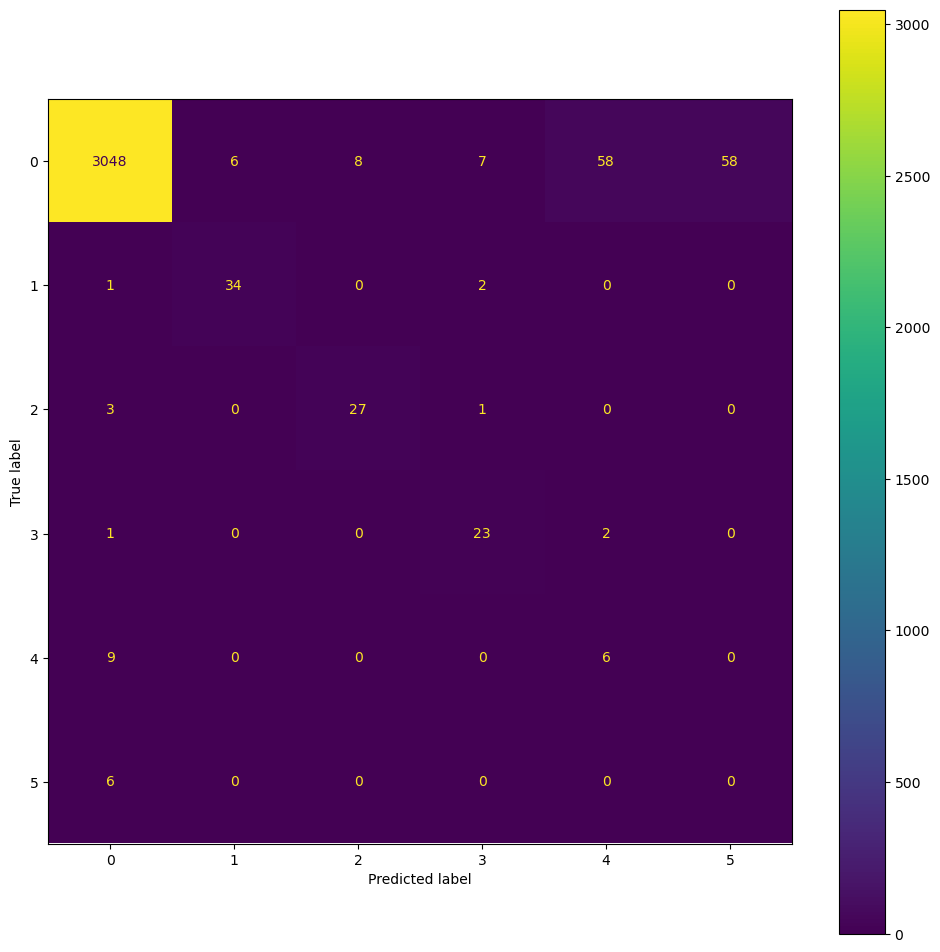

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3185
           1       0.85      0.92      0.88        37
           2       0.77      0.87      0.82        31
           3       0.70      0.88      0.78        26
           4       0.09      0.40      0.15        15
           5       0.00      0.00      0.00         6

    accuracy                           0.95      3300
   macro avg       0.57      0.67      0.60      3300
weighted avg       0.98      0.95      0.97      3300



In [68]:
fig, ax = plt.subplots(figsize=(12, 12))
cm = confusion_matrix(y_test, yhat_ovo)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)
plt.show();
print(classification_report(y_test, yhat_ovo))

In [69]:
print("Balanced Accuracy Score: %.4f" %(balanced_accuracy_score(y_test, yhat_ovo)))
print("Accuracy Score: %.4f" %(accuracy_score(y_test, yhat_ovo)))
print("Matthews correlation coefficient: %.4f" %(matthews_corrcoef(y_test, yhat_ovo)))

Balanced Accuracy Score: 0.6719
Accuracy Score: 0.9509
Matthews correlation coefficient: 0.5551


In [70]:
rfc_ov = RandomForestClassifier()

In [71]:
ovr = OneVsRestClassifier(rfc_ov)
ovr.fit(X1_res, y1_res)

OneVsRestClassifier(estimator=RandomForestClassifier())

In [72]:
yhat_ovr = ovr.predict(X_test)

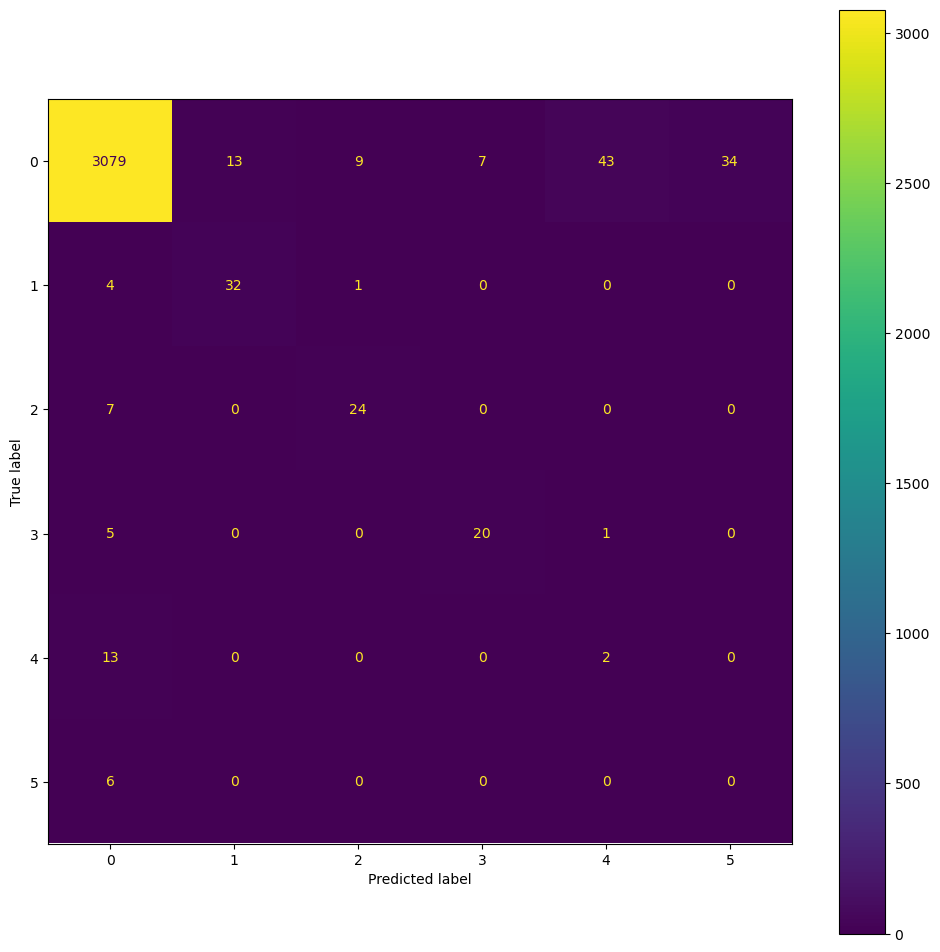

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3185
           1       0.71      0.86      0.78        37
           2       0.71      0.77      0.74        31
           3       0.74      0.77      0.75        26
           4       0.04      0.13      0.07        15
           5       0.00      0.00      0.00         6

    accuracy                           0.96      3300
   macro avg       0.53      0.58      0.55      3300
weighted avg       0.97      0.96      0.97      3300



In [73]:
fig, ax = plt.subplots(figsize=(12, 12))
cm = confusion_matrix(y_test, yhat_ovr)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)
plt.show();
print(classification_report(y_test, yhat_ovr))

In [74]:
print("Balanced Accuracy Score: %.4f" %(balanced_accuracy_score(y_test, yhat_ovr)))
print("Accuracy Score: %.4f" %(accuracy_score(y_test, yhat_ovr)))
print("Matthews correlation coefficient: %.4f" %(matthews_corrcoef(y_test, yhat_ovr)))

Balanced Accuracy Score: 0.5847
Accuracy Score: 0.9567
Matthews correlation coefficient: 0.5283


In [75]:
ovo = OneVsOneClassifier(rfc_ov)

In [76]:
ovo.fit(X1_res, y1_res)
yhat_ovo = ovo.predict(X_test)

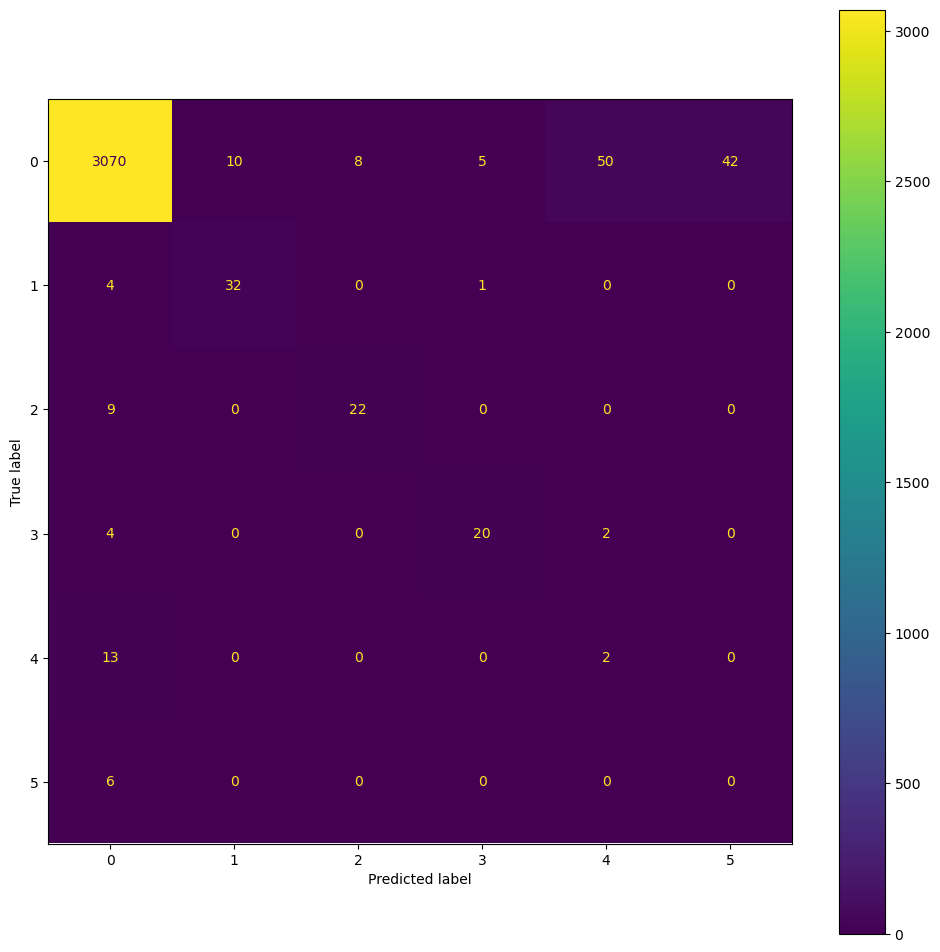

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      3185
           1       0.76      0.86      0.81        37
           2       0.73      0.71      0.72        31
           3       0.77      0.77      0.77        26
           4       0.04      0.13      0.06        15
           5       0.00      0.00      0.00         6

    accuracy                           0.95      3300
   macro avg       0.55      0.57      0.56      3300
weighted avg       0.98      0.95      0.96      3300



In [77]:
fig, ax = plt.subplots(figsize=(12, 12))
cm = confusion_matrix(y_test, yhat_ovo)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)
plt.show();
print(classification_report(y_test, yhat_ovo))

In [78]:
print("Balanced Accuracy Score: %.4f" %(balanced_accuracy_score(y_test, yhat_ovo)))
print("Accuracy Score: %.4f" %(accuracy_score(y_test, yhat_ovo)))
print("Matthews correlation coefficient: %.4f" %(matthews_corrcoef(y_test, yhat_ovo)))

Balanced Accuracy Score: 0.5735
Accuracy Score: 0.9533
Matthews correlation coefficient: 0.5065


In [79]:
print(X_train.columns) 

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype='object')


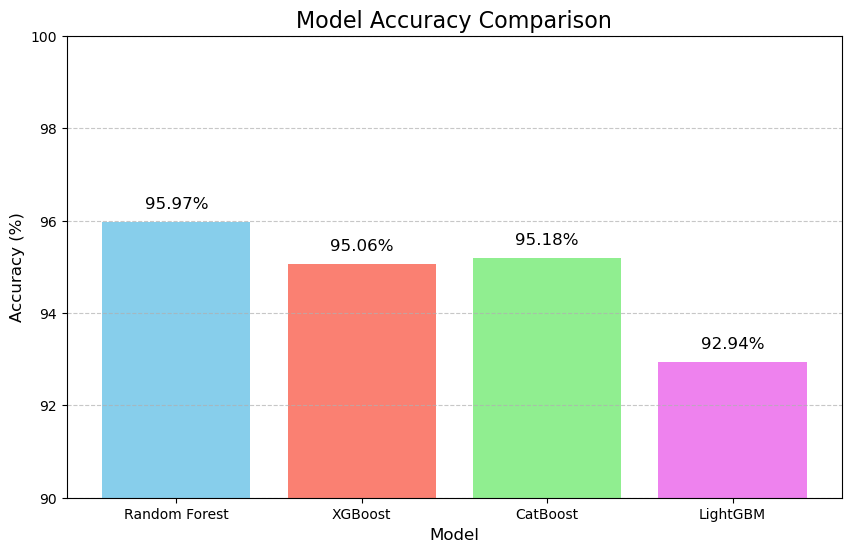

In [80]:
import matplotlib.pyplot as plt

accuracies = [
    rf_accuracy * 100,
    xgb_accuracy * 100,
    cat_accuracy * 100,
    lgb_accuracy * 100
]

model_names = ['Random Forest', 'XGBoost', 'CatBoost', 'LightGBM']

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'salmon', 'lightgreen', 'violet'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.3, f'{yval:.2f}%', ha='center', fontsize=12)

plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(90, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [81]:
import pandas as pd

machine_type_mapping = {"H": 0, "L": 1, "M": 2}

new_data = [[
    machine_type_mapping["M"],297,308.3,1399,46.4,132
]]

new_data_df = pd.DataFrame(new_data, columns=[
    'Type', 'Air temperature [K]', 'Process temperature [K]', 
    'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'
])

new_data_df = new_data_df[X_train.columns]  

predicted_class = model_rfc.predict(new_data_df)[0]

failure_mapping = {
    0: "No Failure ✅",
    1: "Heat Dissipation Failure 🔥",
    2: "Power Failure ⚡",
    3: "Overstrain Failure 💪",
    4: "Tool Wear Failure 🔧",
    5: "Random Failure ❓"
}

print(f"Predicted Failure Type: {failure_mapping[predicted_class]}")

Predicted Failure Type: Random Failure ❓
